In [1]:
# Parameters (overriden by papermill)
DATASET = 'short-linkers'

In [2]:
# Parameters
DATASET = "long-linkers-prom"


In [3]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm
sns.set_palette('Dark2')
sns.set_context('paper')
sns.set_style({'axes.axisbelow': True, 
               'axes.edgecolor': '.15',
               'axes.facecolor': 'white',
               'axes.grid': True, 
               'axes.labelcolor': '.15', 
               'figure.facecolor': 'white', 
               'grid.color': '.15',
               'grid.linestyle': ':', 
               'grid.alpha': .5, 
               'image.cmap': 'Greys', 
               'legend.frameon': False, 
               'legend.numpoints': 1, 
               'legend.scatterpoints': 1,
               'lines.solid_capstyle': 'butt', 
               'axes.spines.right': False, 
               'axes.spines.top': False,  
               'text.color': '.15',  
               'xtick.top': False, 
               'ytick.right': False, 
               'xtick.color': '.15',
               'xtick.direction': 'out', 
               'ytick.color': '.15', 
               'ytick.direction': 'out', 
              })


import matplotlib

FONT_SIZE_PT = 5
matplotlib.rcParams['font.family'] = 'Arial'
matplotlib.rcParams['font.size'] = FONT_SIZE_PT
matplotlib.rcParams['axes.labelsize'] = FONT_SIZE_PT
matplotlib.rcParams['axes.titlesize'] = FONT_SIZE_PT
matplotlib.rcParams['figure.titlesize'] = FONT_SIZE_PT
matplotlib.rcParams['xtick.labelsize'] = FONT_SIZE_PT
matplotlib.rcParams['ytick.labelsize'] = FONT_SIZE_PT
matplotlib.rcParams['legend.fontsize'] = FONT_SIZE_PT
matplotlib.rcParams['legend.title_fontsize'] = FONT_SIZE_PT

matplotlib.rcParams['xtick.major.size'] = matplotlib.rcParams['ytick.major.size'] = 2
matplotlib.rcParams['xtick.major.width'] = matplotlib.rcParams['ytick.major.width'] = 0.5


matplotlib.rcParams['xtick.minor.size'] = matplotlib.rcParams['ytick.minor.size'] = 1

matplotlib.rcParams['xtick.minor.width'] = matplotlib.rcParams['ytick.minor.width'] = 0.5

matplotlib.rcParams['axes.linewidth'] = 0.5
matplotlib.rcParams['lines.linewidth'] = 0.5
matplotlib.rcParams['grid.linewidth'] = 0.25
matplotlib.rcParams['patch.linewidth'] = 0.25
matplotlib.rcParams['lines.markeredgewidth'] = 0.25
matplotlib.rcParams['lines.markersize'] = 2

FIVE_MM_IN_INCH = 0.19685
DPI = 600
matplotlib.rcParams['figure.figsize'] = (10 * FIVE_MM_IN_INCH, 9 * FIVE_MM_IN_INCH)
matplotlib.rcParams['savefig.dpi'] = DPI
matplotlib.rcParams['figure.dpi'] = DPI // 4


#http://phyletica.org/matplotlib-fonts/
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# (02) Transformation and modeling

This notebook handles the core of the analysis:

Transformation of the numeric data into format that can be read by the model
Normalisation of the data
Modelling of differential enrichments

## Configuration

Input file (the numeric data from previous notebook):

In [4]:
import pathlib

INPUT_NUMERIC_DATA = pathlib.Path('outputs') / '01-extracting' / f'data_numeric.{DATASET}.csv'
assert INPUT_NUMERIC_DATA.is_file()

INPUT_METADATA = pathlib.Path('outputs') / '01-extracting' / f'data_metadata.{DATASET}.csv'
assert INPUT_METADATA.is_file()

output directory

In [5]:
import pathlib
OUTPUT_DIRECTORY = pathlib.Path('outputs') / '02-transformation-and-modelling' / DATASET

if not OUTPUT_DIRECTORY.is_dir():
    OUTPUT_DIRECTORY.mkdir(parents=True)

Parameters, constants:

In [6]:
# To do analysis, we will require that:
#- at least this many (below) values per condition are set (for the condition analysed)
MINIMUM_NUMBER_OF_OBSERVED_VALUES_PER_CONDITION = 2

# Cutoff for BH-adjusted p-values
FDR_THRESHOLD = 0.05

# FC threshold
FC_THRESHOLD = 1.0 # used to identify "strong" effects

## Reading metadata

In [7]:
data_metadata = pd.read_csv(INPUT_METADATA, index_col=0)
data_metadata.head()

# AAs  # PSMs  # Peptides  # Peptides (by Search Engine): Mascot  \
Label                                                                      
MYH9     1960    9223         158                                    158   
SPTAN1   2472    5575         203                                    203   
PRKDC    4128    5822         228                                    228   
SPTBN1   2364    4865         165                                    165   
ACTB      375    4951          29                                     29   

        # Unique Peptides Accession  Coverage [%]  \
Label                                               
MYH9                  137    P35579            69   
SPTAN1                201    Q13813            77   
PRKDC                 228    P78527            55   
SPTBN1                152    Q01082            75   
ACTB                   11    P60709            82   

                                              Description    Gene  MW [kDa]  \
Label                                                                         
MYH9    Myosin-9 OS=Homo sapiens OX=9606 GN=MYH9 PE=1 ...    MYH9     226.4   
SPTAN1  Spectrin alpha chain, non-erythrocytic 1 OS=Ho...  SPTAN1     284.4   
PRKDC   DNA-dependent protein kinase catalytic subunit...   PRKDC     468.8   
SPTBN1  Spectrin beta chain, non-erythrocytic 1 OS=Hom...  SPTBN1     274.4   
ACTB    Actin, cytoplasmic 1 OS=Homo sapiens OX=9606 G...    ACTB      41.7   

        Score Mascot: Mascot  unmodH3_unmodH5_200bp_scr_repl1  \
Label                                                           
MYH9                  297789                     2.617519e+09   
SPTAN1                189967                     8.809251e+08   
PRKDC                 175811                     8.800427e+08   
SPTBN1                167574                     9.849796e+08   
ACTB                  164631                     2.085801e+10   

        unmodH3_unmodH5_200bp_scr_repl2  unmodH3_unmodH5_200bp_scr_repl3  \
Label                                                                      
MYH9                       3.461079e+09                     2.035037e+09   
SPTAN1                     1.152325e+09                     8.427988e+08   
PRKDC                      8.223814e+08                     6.079810e+08   
SPTBN1                     1.188865e+09                     7.865917e+08   
ACTB                       2.567843e+10                     1.921924e+10   

        unmodH3_unmodH6_200bp_SV40prom_repl1  \
Label                                          
MYH9                            2.035759e+09   
SPTAN1                          7.448489e+08   
PRKDC                           6.159315e+08   
SPTBN1                          5.236452e+08   
ACTB                            1.792695e+10   

        unmodH3_unmodH6_200bp_SV40prom_repl2  \
Label                                          
MYH9                            1.853011e+09   
SPTAN1                          7.271738e+08   
PRKDC                           4.933144e+08   
SPTBN1                          5.496364e+08   
ACTB                            1.487529e+10   

        unmodH3_unmodH6_200bp_SV40prom_repl3  
Label                                         
MYH9                            1.776609e+09  
SPTAN1                          7.925378e+08  
PRKDC                           6.181795e+08  
SPTBN1                          8.272016e+08  
ACTB                            1.820500e+10

## Reading numeric data

In [8]:
data_numeric = pd.read_csv(INPUT_NUMERIC_DATA, index_col=0)
data_numeric.columns.name = 'Experiment_Linker_Replicate'
data_numeric.head()

Experiment_Linker_Replicate  Promoter_PTMs_50bp_repl1  \
Label                                                   
MYH9                                     1.281909e+09   
SPTAN1                                   5.248911e+08   
PRKDC                                    7.270430e+08   
SPTBN1                                   7.211787e+08   
ACTB                                     1.269655e+10   

Experiment_Linker_Replicate  Promoter_PTMs_200bp_scr_repl1  \
Label                                                        
MYH9                                          2.134530e+09   
SPTAN1                                        6.587411e+08   
PRKDC                                         5.506399e+08   
SPTBN1                                        1.222698e+09   
ACTB                                          1.720074e+10   

Experiment_Linker_Replicate  Promoter_PTMs_200bp_SV40prom_repl1  \
Label                                                             
MYH9                                               2.497327e+09   
SPTAN1                                             8.357382e+08   
PRKDC                                              7.164303e+08   
SPTBN1                                             1.586194e+09   
ACTB                                               1.922848e+10   

Experiment_Linker_Replicate  unmodH3_unmodH4_50bp_repl1  \
Label                                                     
MYH9                                       2.281093e+09   
SPTAN1                                     8.585309e+08   
PRKDC                                      8.096481e+08   
SPTBN1                                     8.392360e+08   
ACTB                                       1.889111e+10   

Experiment_Linker_Replicate  unmodH3_unmodH4_200bp_scr_repl1  \
Label                                                          
MYH9                                            2.617519e+09   
SPTAN1                                          8.809251e+08   
PRKDC                                           8.800427e+08   
SPTBN1                                          9.849796e+08   
ACTB                                            2.085801e+10   

Experiment_Linker_Replicate  unmodH3_unmodH4_200bp_SV40prom_repl1  \
Label                                                               
MYH9                                                 2.035759e+09   
SPTAN1                                               7.448489e+08   
PRKDC                                                6.159315e+08   
SPTBN1                                               5.236452e+08   
ACTB                                                 1.792695e+10   

Experiment_Linker_Replicate  Promoter_PTMs_50bp_repl2  \
Label                                                   
MYH9                                     2.860328e+09   
SPTAN1                                   9.913368e+08   
PRKDC                                    6.545611e+08   
SPTBN1                                   1.537787e+09   
ACTB                                     2.213478e+10   

Experiment_Linker_Replicate  Promoter_PTMs_200bp_scr_repl2  \
Label                                                        
MYH9                                          1.788147e+09   
SPTAN1                                        5.434298e+08   
PRKDC                                         3.778371e+08   
SPTBN1                                        1.079691e+09   
ACTB                                          1.323739e+10   

Experiment_Linker_Replicate  Promoter_PTMs_200bp_SV40prom_repl2  \
Label                                                             
MYH9                                               1.796727e+09   
SPTAN1                                             5.535093e+08   
PRKDC                                              4.057029e+08   
SPTBN1                                             1.061178e+09   
ACTB                                               1.255952e+10   

Experiment_Linker_Replicate  unmodH3_unmodH

For this notebook it will also help to establish a set of "Headers" which describe what each column means:

In [9]:
import re

    
_df_head = []
for col in data_numeric.columns:

    # The column headers are encoded a bit inconsistently
    # we thus them here in a hacky way, but it works (see below)
    experiment_linker, __, rep = col.rpartition('_')
    experiment_linker = experiment_linker.strip('_')
    experiment, linker, __ = re.split('_(\d+bp.*)', experiment_linker)
    
    # Special case for one typo
    if rep.startswith('scr'):
        linker += '_' + rep[:3]
        rep = rep[3:]
        
    if rep.startswith('repl'):
        rep = rep[4:]

    _df_head.append([col, experiment, linker, rep])

_df_head = pd.DataFrame(_df_head, columns=[data_numeric.columns.name, 'Experiment', 'Linker', 'Replicate']).set_index(data_numeric.columns.name)

_df_head['Experiment_Linker'] = _df_head['Experiment'].str.cat(_df_head['Linker'], sep='_')

headers_full = _df_head

In [10]:
headers_full

Experiment          Linker  \
Experiment_Linker_Replicate                                             
Promoter_PTMs_50bp_repl1                Promoter_PTMs            50bp   
Promoter_PTMs_200bp_scr_repl1           Promoter_PTMs       200bp_scr   
Promoter_PTMs_200bp_SV40prom_repl1      Promoter_PTMs  200bp_SV40prom   
unmodH3_unmodH4_50bp_repl1            unmodH3_unmodH4            50bp   
unmodH3_unmodH4_200bp_scr_repl1       unmodH3_unmodH4       200bp_scr   
unmodH3_unmodH4_200bp_SV40prom_repl1  unmodH3_unmodH4  200bp_SV40prom   
Promoter_PTMs_50bp_repl2                Promoter_PTMs            50bp   
Promoter_PTMs_200bp_scr_repl2           Promoter_PTMs       200bp_scr   
Promoter_PTMs_200bp_SV40prom_repl2      Promoter_PTMs  200bp_SV40prom   
unmodH3_unmodH4_50bp_repl2            unmodH3_unmodH4            50bp   
unmodH3_unmodH4_200bp_scr_repl2       unmodH3_unmodH4       200bp_scr   
unmodH3_unmodH4_200bp_SV40prom_repl2  unmodH3_unmodH4  200bp_SV40prom   
Promoter_PTMs_50bp_repl3                Promoter_PTMs            50bp   
Promoter_PTMs_200bp_scr_repl3           Promoter_PTMs       200bp_scr   
Promoter_PTMs_200bp_SV40prom_repl3      Promoter_PTMs  200bp_SV40prom   
unmodH3_unmodH4_50bp_repl3            unmodH3_unmodH4            50bp   
unmodH3_unmodH4_200bp_scr_repl3       unmodH3_unmodH4       200bp_scr   
unmodH3_unmodH4_200bp_SV40prom_repl3  unmodH3_unmodH4  200bp_SV40prom   

                                     Replicate               Experiment_Linker  
Experiment_Linker_Replicate                                                     
Promoter_PTMs_50bp_repl1                     1              Promoter_PTMs_50bp  
Promoter_PTMs_200bp_scr_repl1                1         Promoter_PTMs_200bp_scr  
Promoter_PTMs_200bp_SV40prom_repl1           1    Promoter_PTMs_200bp_SV40prom  
unmodH3_unmodH4_50bp_repl1                   1            unmodH3_unmodH4_50bp  
unmodH3_unmodH4_200bp_scr_repl1              1       unmodH3_unmodH4_200bp_scr  
unmodH3_unmodH4_200bp_SV40prom_repl1         1  unmodH3_unmodH4_200bp_SV40prom  
Promoter_PTMs_50bp_repl2                     2              Promoter_PTMs_50bp  
Promoter_PTMs_200bp_scr_repl2                2         Promoter_PTMs_200bp_scr  
Promoter_PTMs_200bp_SV40prom_repl2           2    Promoter_PTMs_200bp_SV40prom  
unmodH3_unmodH4_50bp_repl2                   2            unmodH3_unmodH4_50bp  
unmodH3_unmodH4_200bp_scr_repl2              2       unmodH3_unmodH4_200bp_scr  
unmodH3_unmodH4_200bp_SV40prom_repl2         2  unmodH3_unmodH4_200bp_SV40prom  
Promoter_PTMs_50bp_repl3                     3              Promoter_PTMs_50bp  
Promoter_PTMs_200bp_scr_repl3                3         Promoter_PTMs_200bp_scr  
Promoter_PTMs_200bp_SV40prom_repl3           3    Promoter_PTMs_200bp_SV40prom  
unmodH3_unmodH4_50bp_repl3                   3            unmodH3_unmodH4_50bp  
unmodH3_unmodH4_200bp_scr_repl3              3       unmodH3_unmodH4_200bp_scr  
unmodH3_unmodH4_200bp_SV40prom_repl3         3  unmodH3_unmodH4_200bp_SV40prom

In [11]:
headers_full['Linker'].value_counts()

50bp              6
200bp_scr         6
200bp_SV40prom    6
Name: Linker, dtype: int64

In [12]:
headers_full['Replicate'].value_counts()

1    6
2    6
3    6
Name: Replicate, dtype: int64

In [13]:
headers_full['Experiment'].value_counts()

Promoter_PTMs      9
unmodH3_unmodH4    9
Name: Experiment, dtype: int64

The data we are loading here is MS intensities; they generally make more sense in log scale. We will therefore transform the data to log2 here and work with that from now on:

In [14]:
data_numeric_log2 = data_numeric.apply(np.log2).replace([-np.inf, np.inf], np.nan)

# EDA (log2 transformed, unnormalised, unfiltered)

### Missing values

The first thing that is very obvious is that this data has many missing values:


Distribution of missing values in the log2-transformed, unnormalised, and unfiltered data (long-linkers-prom). 
The heatmap above displays all proteins in the data in rows, and all experiments in columns. Dark values indicate the presence of a value, while white space indicates the absence of one. The sparkline on the right hand side counts the number of values per protein.



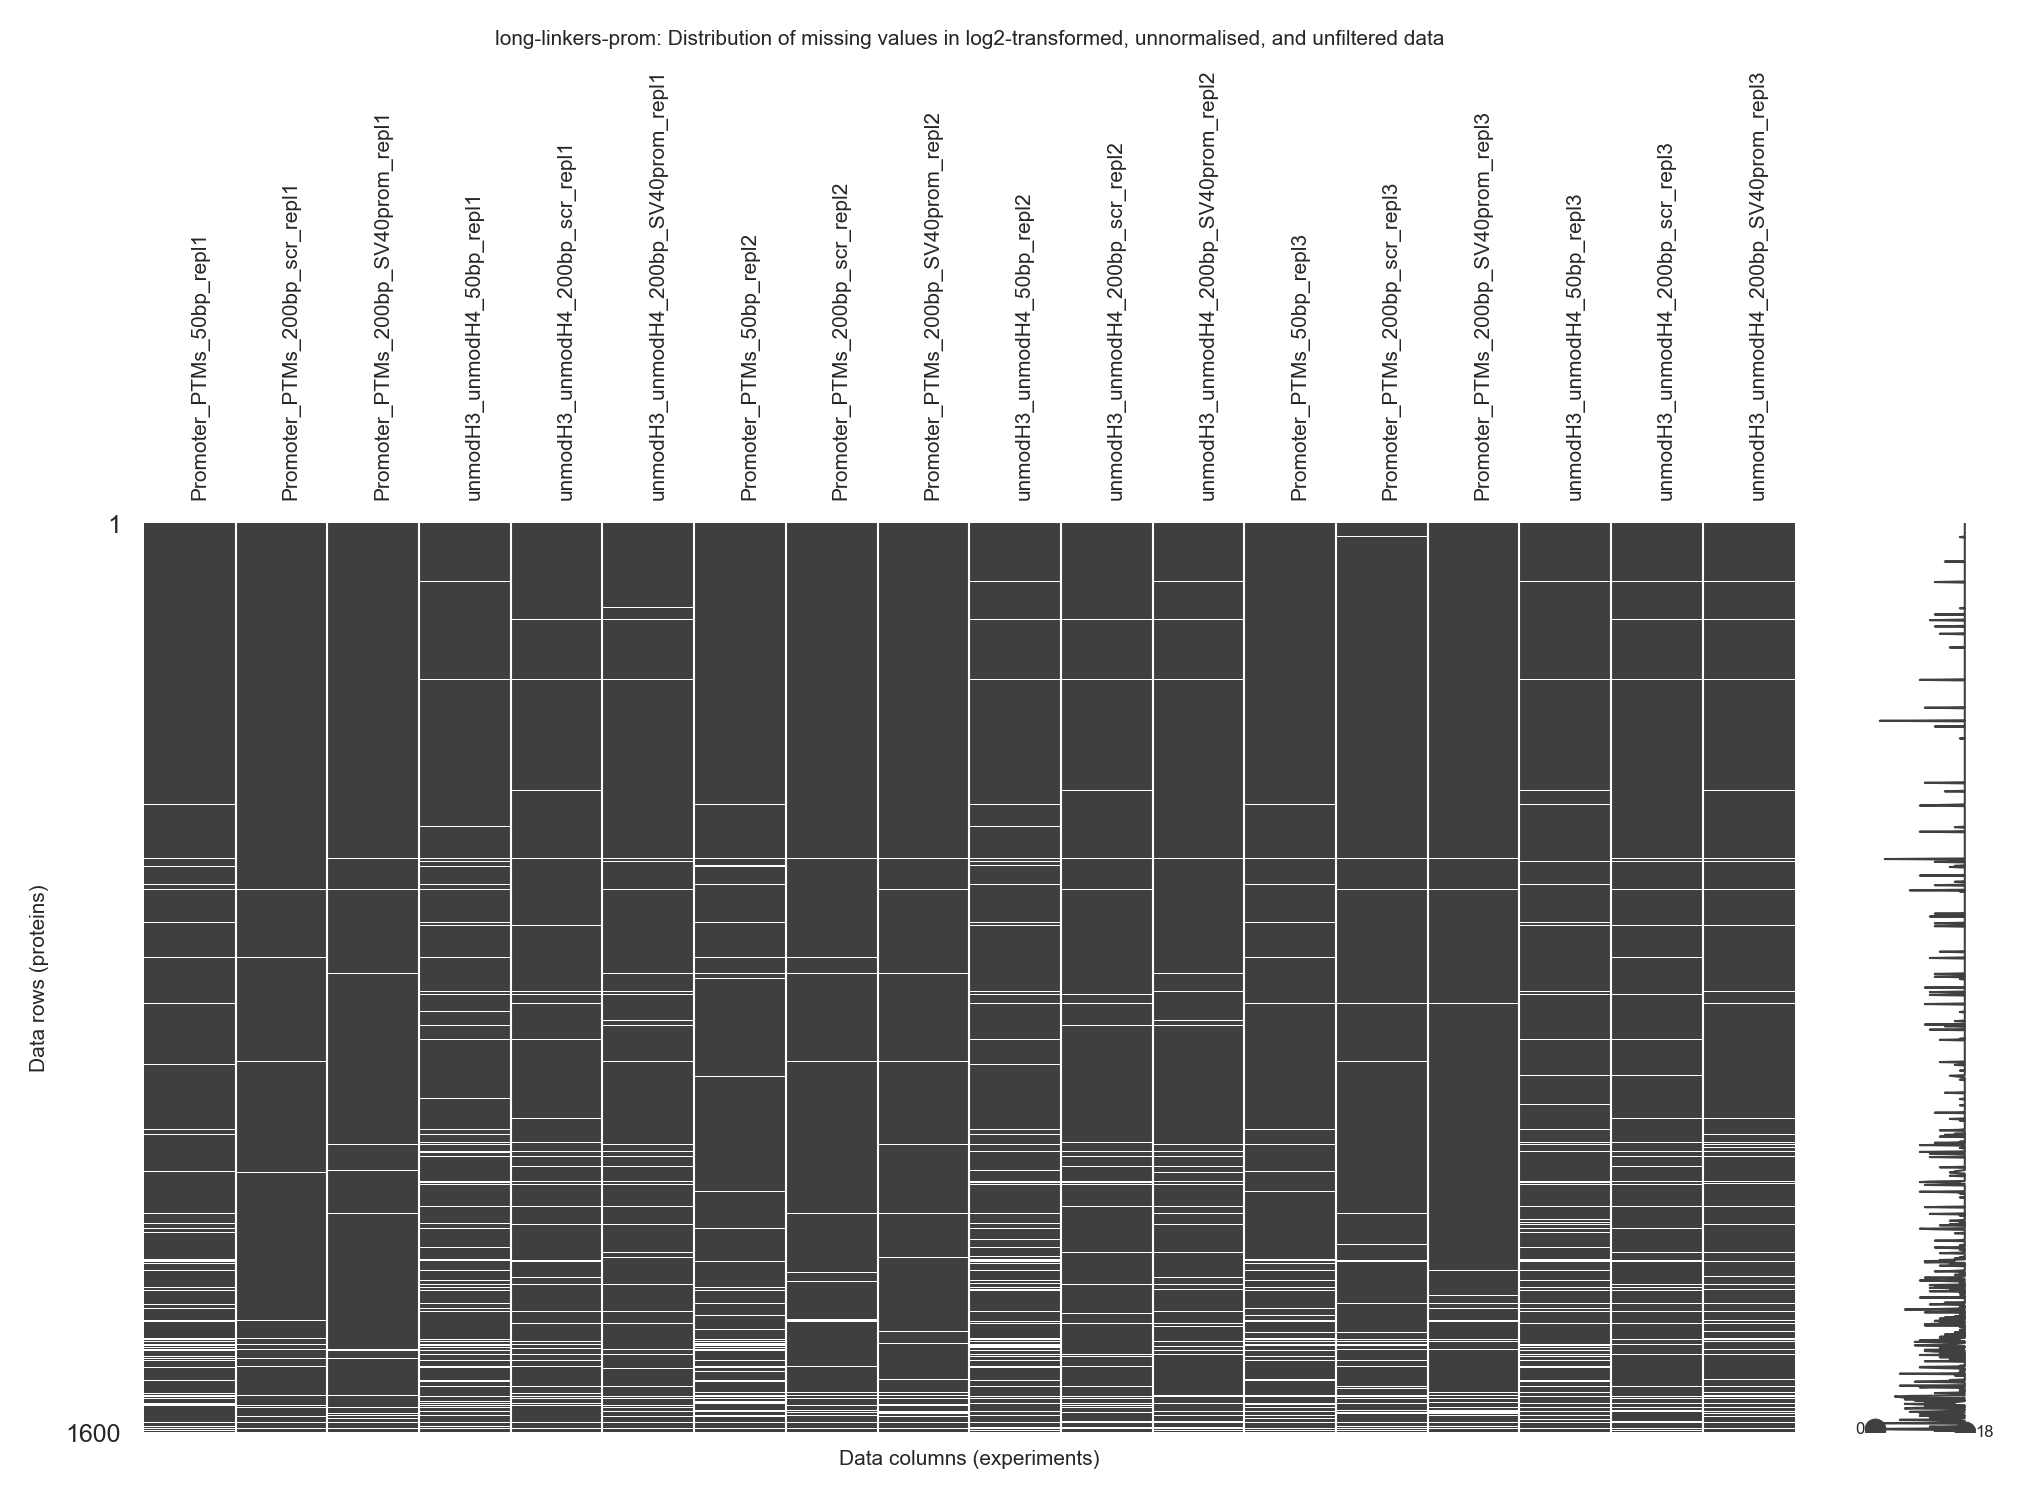

In [15]:
import missingno as msgno

msgno.matrix(data_numeric_log2, figsize=(40*FIVE_MM_IN_INCH, 20*FIVE_MM_IN_INCH), fontsize=5)

plt.title(f"{DATASET}: Distribution of missing values in log2-transformed, unnormalised, and unfiltered data")
plt.xlabel("Data columns (experiments)")
plt.ylabel("Data rows (proteins)")
plt.xticks(rotation=90)

_fname = OUTPUT_DIRECTORY / f'01-EDA-log2-transformed-unnormalised-unfiltered-missing-values.{DATASET}.png'
_caption = f"""
Distribution of missing values in the log2-transformed, unnormalised, and unfiltered data ({DATASET}). 
The heatmap above displays all proteins in the data in rows, and all experiments in columns. Dark values indicate the presence of a value, while white space indicates the absence of one. The sparkline on the right hand side counts the number of values per protein.
"""
plt.savefig(_fname, bbox_inches='tight', dpi=DPI)
with open(str(_fname) + '.caption.md', 'w') as f:
    f.write(_caption)
    print(_caption)

In [16]:
data_numeric_log2.isnull().mean().sort_values(ascending=False).head()

Experiment_Linker_Replicate
unmodH3_unmodH4_50bp_repl2    0.073125
unmodH3_unmodH4_50bp_repl1    0.071250
unmodH3_unmodH4_50bp_repl3    0.065625
Promoter_PTMs_50bp_repl1      0.053750
Promoter_PTMs_50bp_repl3      0.049375
dtype: float64

### Normality

The analyses below will assume that the log2-transformed data is approximately normal.

We can qualititatively verify this by plotting the data distributions.

We see that the fit is not perfect but is perhaps acceptable. We will therefore not worry about the normality of the data.

/usr/local/Caskroom/miniconda/base/envs/marcs-variable-linker-pds/lib/python3.10/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)



Distribution of non-null values of log2-transformed, unnormalised, and unfiltered dataset (long-linkers-prom). 
The rows facet the four experiment types, while the columns split the data per replicate.
The green distribution plot shows the histogram of observed log2 values in the data.
The black curve shows the corresponding normal distribution fit to the data, whose parameters are written in the top-right corner.
The black vertical line indicates the mean ($\mu$) estimate.



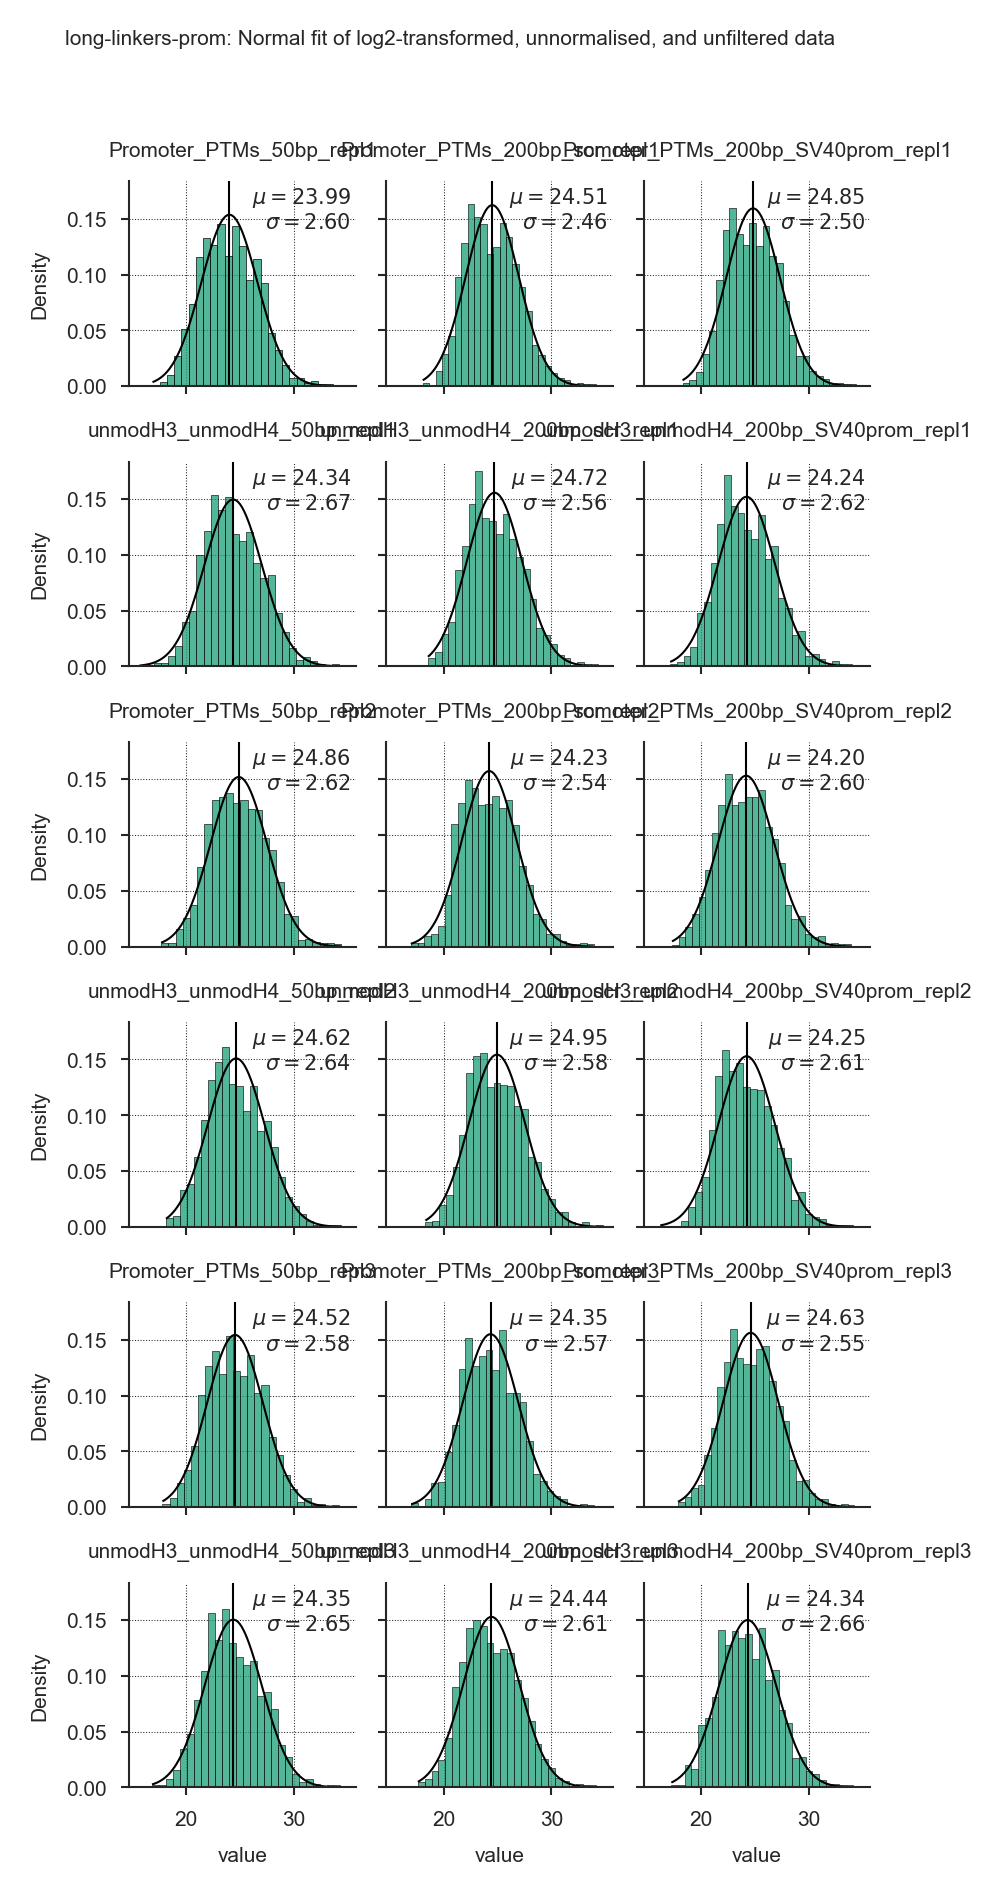

In [17]:
from scipy.stats import norm
def _plot_norm_fit(values, *args, color=None, **kwargs):
    """
    Fits a normal distribution to the data and plots its PDF
    """
    mu, std = norm.fit(values)

    min_ = values.min()
    max_ = values.max()
    
    ax = plt.gca()
    xs = np.linspace(min_, max_, 100)
    ys = norm.pdf(xs, mu, std)
    
    ax.plot(xs, ys, **kwargs, color='black', label='Normal fit')
    ax.axvline(mu, color='black')
    
    ax.text(
        0.98, 0.98, '\n'.join([r'$\mu = {:.2f}$'.format(mu),r'$\sigma = {:.2f}$'.format(std)]),
        ha='right', va='top', transform=ax.transAxes
    )
    
    

# Convert data to long format
_df = data_numeric_log2.copy()
_df = _df.stack(_df.columns.names)
_df.name = 'value'
_df = _df.reset_index()

# Plot the histograms and normal distribution fits
fgrid = sns.FacetGrid(col='Experiment_Linker_Replicate', col_wrap=3, col_order=data_numeric_log2.columns, data=_df, size=FIVE_MM_IN_INCH*5)
fgrid.map(sns.histplot, 'value', stat='density')
fgrid.map(_plot_norm_fit, 'value')
fgrid.set_titles('{col_name}')

plt.suptitle(f"{DATASET}: Normal fit of log2-transformed, unnormalised, and unfiltered data", y=1.05)

_fname = OUTPUT_DIRECTORY / f'01-EDA-log2-transformed-unnormalised-unfiltered-normal-fit.{DATASET}.pdf'
_caption = f"""
Distribution of non-null values of log2-transformed, unnormalised, and unfiltered dataset ({DATASET}). 
The rows facet the four experiment types, while the columns split the data per replicate.
The green distribution plot shows the histogram of observed log2 values in the data.
The black curve shows the corresponding normal distribution fit to the data, whose parameters are written in the top-right corner.
The black vertical line indicates the mean ($\mu$) estimate.
"""
plt.savefig(_fname, bbox_inches='tight', dpi=DPI)
with open(str(_fname) + '.caption.md', 'w') as f:
    f.write(_caption)
    print(_caption)

## PCA

And finally the PCA of unnormalised data


Principal Component embedding of log2-transformed, unnormalised, and unfiltered dataset (long-linkers-prom), including only the rows which have no missing values.
The principal component 1 (PC1) is plotted on the X axis, while the PC2 is plotted on the Y. 
The explained variance ratio is highlighted in parentheses.




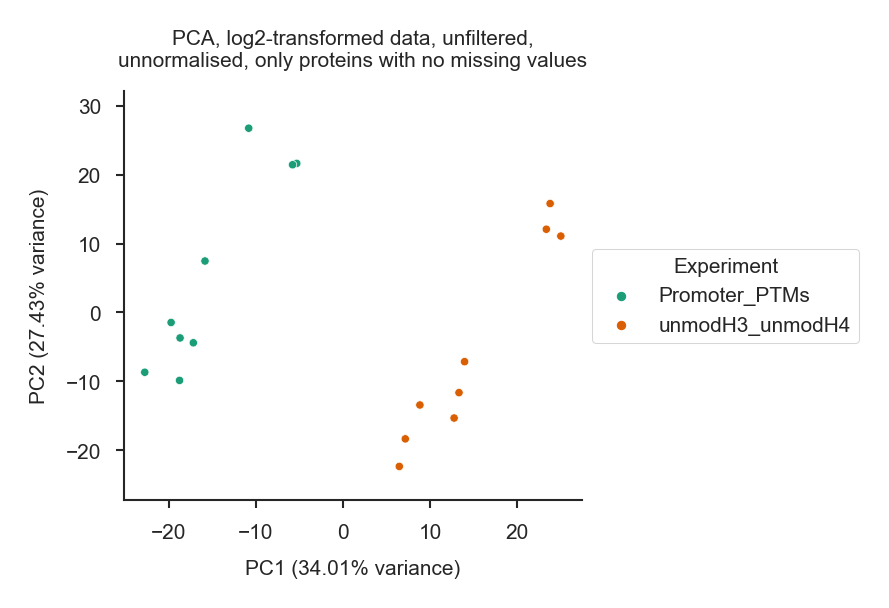

In [18]:
from adjustText import adjust_text
from sklearn.decomposition import PCA

_df = data_numeric_log2

plt.figure()
pca = PCA(n_components=2)

# Note that we only look at the rows that are all not null:
projected = pca.fit_transform(_df.dropna(axis=0).T)

projected = pd.DataFrame(projected, index=_df.columns, columns=['PC1', 'PC2'])
explained_variance = pd.Series(pca.explained_variance_ratio_, index=projected.columns)

ax = plt.gca()

sns.scatterplot(x='PC1', y='PC2', hue='Experiment', data=projected.join(headers_full))

#     texts = []
#     for ix, row in projected.iterrows():
#         texts.append(ax.text(row['PC1'], row['PC2'], ix, ha='center', va='center'))

xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Increasing ylim helps place the H3K4me3 labels
ax.set_ylim(ylim[0]*1.1, ylim[1] * 1.1)

#     adjust_text(texts, projected['PC1'].values, projected['PC2'].values, arrowprops=dict(arrowstyle='-'))

ax.set_xlabel("PC1 ({:.2%} variance)".format(explained_variance.loc['PC1']))
ax.set_ylabel("PC2 ({:.2%} variance)".format(explained_variance.loc['PC2']))
ax.grid(False)
ax.set_title("PCA, log2-transformed data, unfiltered,\nunnormalised, only proteins with no missing values")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Experiment')


_fname = OUTPUT_DIRECTORY / f'01-EDA-log2-transformed-unnormalised-unfiltered-PCA.{DATASET}.pdf'
_caption = f"""
Principal Component embedding of log2-transformed, unnormalised, and unfiltered dataset ({DATASET}), including only the rows which have no missing values.
The principal component 1 (PC1) is plotted on the X axis, while the PC2 is plotted on the Y. 
The explained variance ratio is highlighted in parentheses.

"""
plt.savefig(_fname, bbox_inches='tight', dpi=DPI)
with open(str(_fname) + '.caption.md', 'w') as f:
    f.write(_caption)
    print(_caption)


Principal Component embedding of log2-transformed, unnormalised, and unfiltered dataset (long-linkers-prom), including only the rows which have no missing values.
The principal component 1 (PC1) is plotted on the X axis, while the PC2 is plotted on the Y. 
The explained variance ratio is highlighted in parentheses.




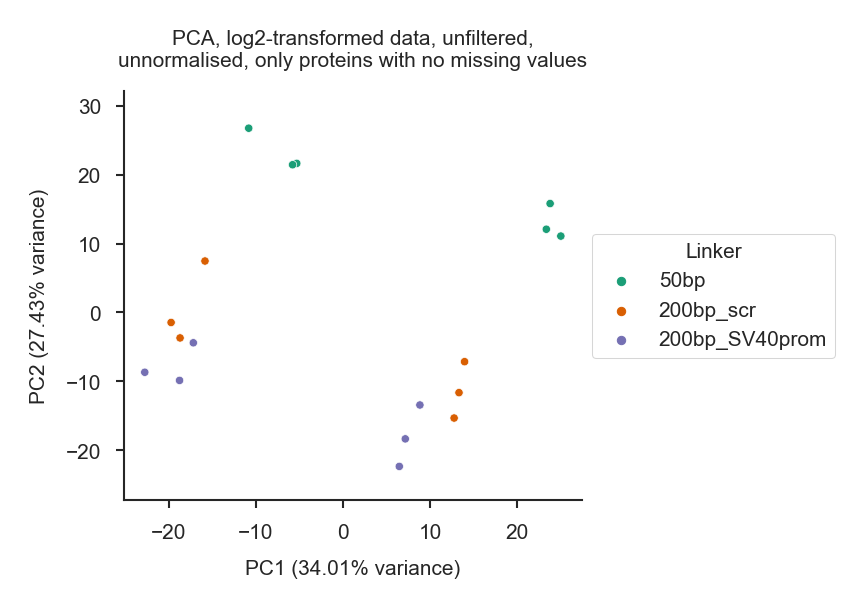

In [19]:
from adjustText import adjust_text
from sklearn.decomposition import PCA

_df = data_numeric_log2

plt.figure()
pca = PCA(n_components=2)

# Note that we only look at the rows that are all not null:
projected = pca.fit_transform(_df.dropna(axis=0).T)

projected = pd.DataFrame(projected, index=_df.columns, columns=['PC1', 'PC2'])
explained_variance = pd.Series(pca.explained_variance_ratio_, index=projected.columns)

ax = plt.gca()

sns.scatterplot(x='PC1', y='PC2', hue='Linker', data=projected.join(headers_full))

#     texts = []
#     for ix, row in projected.iterrows():
#         texts.append(ax.text(row['PC1'], row['PC2'], ix, ha='center', va='center'))

xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Increasing ylim helps place the H3K4me3 labels
ax.set_ylim(ylim[0]*1.1, ylim[1] * 1.1)

#     adjust_text(texts, projected['PC1'].values, projected['PC2'].values, arrowprops=dict(arrowstyle='-'))

ax.set_xlabel("PC1 ({:.2%} variance)".format(explained_variance.loc['PC1']))
ax.set_ylabel("PC2 ({:.2%} variance)".format(explained_variance.loc['PC2']))
ax.grid(False)
ax.set_title("PCA, log2-transformed data, unfiltered,\nunnormalised, only proteins with no missing values")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Linker')


_fname = OUTPUT_DIRECTORY / f'01-EDA-log2-transformed-unnormalised-unfiltered-PCA.Linker.{DATASET}.pdf'
_caption = f"""
Principal Component embedding of log2-transformed, unnormalised, and unfiltered dataset ({DATASET}), including only the rows which have no missing values.
The principal component 1 (PC1) is plotted on the X axis, while the PC2 is plotted on the Y. 
The explained variance ratio is highlighted in parentheses.

"""
plt.savefig(_fname, bbox_inches='tight', dpi=DPI)
with open(str(_fname) + '.caption.md', 'w') as f:
    f.write(_caption)
    print(_caption)

In [20]:
# Clean up memory a bit
plt.close('all')

## Normalisation

For normalisation of these intensities, it makes most sense to normalise to the histone amounts.
The histone proteins that are present in our data:

In [21]:
_df = data_metadata.reset_index()
_df = _df[['Label', 'Description']].drop_duplicates().set_index('Label')

_mask = _df['Description'].str.lower().str.contains('histone')
_mask &= ~(_df['Description'].str.lower().str.contains('transferase'))
_mask &= ~(_df['Description'].str.lower().str.contains('acetylase'))
_mask &= ~(_df['Description'].str.lower().str.contains('methylase'))
_mask &= ~(_df['Description'].str.lower().str.contains('methylation'))
_mask &= ~(_df['Description'].str.lower().str.contains('histone-binding protein'))
_mask &= ~(_df['Description'].str.lower().str.contains('non-histone'))
histone_like_proteins = _df[_mask].sort_index()
histone_like_proteins

Description
Label                                                       
H1-0       Histone H1.0 OS=Homo sapiens OX=9606 GN=H1-0 P...
H1-10      Histone H1.10 OS=Homo sapiens OX=9606 GN=H1-10...
H1-2       Histone H1.2 OS=Homo sapiens OX=9606 GN=H1-2 P...
H1-4       Histone H1.4 OS=Homo sapiens OX=9606 GN=H1-4 P...
H2AC7      Histone H2A type 1-D OS=Homo sapiens OX=9606 G...
H2AZ2      Histone H2A.V OS=Homo sapiens OX=9606 GN=H2AZ2...
H2BC12     Histone H2B type 1-K OS=Homo sapiens OX=9606 G...
H3-3A      Histone H3.3 OS=Homo sapiens OX=9606 GN=H3-3A ...
H3-7       Histone H3-7 OS=Homo sapiens OX=9606 GN=H3-7 P...
H4C1       Histone H4 OS=Homo sapiens OX=9606 GN=H4C1 PE=...
MACROH2A1  Core histone macro-H2A.1 OS=Homo sapiens OX=96...

In [22]:
HISTONES = histone_like_proteins.index

Out of which the most abundant ones are:

In [23]:
data_numeric_log2.reindex(histone_like_proteins.index).mean(axis=1).sort_values(ascending=False)

Label
H4C1         34.017037
H2BC12       33.174311
H3-3A        32.290787
H2AC7        30.049118
H2AZ2        29.484925
H1-10        28.159528
H1-0         27.400042
H1-2         25.732999
H1-4         25.344423
H3-7         25.243580
MACROH2A1    22.567566
dtype: float64

We take a small set of core histone proteins to use for normalisation

In [24]:
# By dataset

NORMALISATION_PROTEINS_BY_DATASET = {
    'short-linkers': ['HIST1H4A', 'HIST2H2BF'],
    'long-linkers-enh': ['H4C1', 'H2BC12'],
    'long-linkers-prom': ['H4C1', 'H2BC12']
}

NORMALISATION_PROTEINS = NORMALISATION_PROTEINS_BY_DATASET[DATASET]

In [25]:
data_numeric_log2_histones = data_numeric_log2.loc[histone_like_proteins.index]

In [26]:
data_numeric_log2_histones

Experiment_Linker_Replicate  Promoter_PTMs_50bp_repl1  \
Label                                                   
H1-0                                        26.516012   
H1-10                                       27.447644   
H1-2                                        24.834117   
H1-4                                        24.315311   
H2AC7                                       27.559068   
H2AZ2                                       32.276391   
H2BC12                                      32.159099   
H3-3A                                       31.609700   
H3-7                                        24.099328   
H4C1                                        33.210049   
MACROH2A1                                   21.682685   

Experiment_Linker_Replicate  Promoter_PTMs_200bp_scr_repl1  \
Label                                                        
H1-0                                             27.317427   
H1-10                                            27.993293   
H1-2                                             25.730242   
H1-4                                             25.334600   
H2AC7                                            28.673134   
H2AZ2                                            33.340493   
H2BC12                                           33.339702   
H3-3A                                            32.127643   
H3-7                                             24.838095   
H4C1                                             34.117520   
MACROH2A1                                        21.988389   

Experiment_Linker_Replicate  Promoter_PTMs_200bp_SV40prom_repl1  \
Label                                                             
H1-0                                                  27.896596   
H1-10                                                 28.403147   
H1-2                                                  26.361997   
H1-4                                                  26.014860   
H2AC7                                                 29.194879   
H2AZ2                                                 33.692039   
H2BC12                                                33.693802   
H3-3A                                                 32.638330   
H3-7                                                  25.308220   
H4C1                                                  34.415068   
MACROH2A1                                             22.280500   

Experiment_Linker_Replicate  unmodH3_unmodH4_50bp_repl1  \
Label                                                     
H1-0                                          26.937817   
H1-10                                         28.252883   
H1-2                                          25.267252   
H1-4                                          24.794285   
H2AC7                                         31.114433   
H2AZ2                                         25.870849   
H2BC12                                        32.712518   
H3-3A                                         32.063626   
H3-7                                          25.466141   
H4C1                                          33.600541   
MACROH2A1                                     23.138216   

Experiment_Linker_Replicate  unmodH3_unmodH4_200bp_scr_repl1  \
Label                                                          
H1-0                                               27.815639   
H1-10                                              28.343222   
H1-2                                               26.041585   
H1-4                                               25.662973   
H2AC7                                              32.611598   
H2AZ2                                              25.863407   
H2BC12                                             33.468605   
H3-3A                                              32.488068   
H3-7                                               25.896977   
H4C1                                               34.273008   
MACROH2A1                                  


Boxplot showing the unnormalised log2 data for histone proteins only (long-linkers-prom).
The proteins are plotted on the Y axis, and the experiments on the X.

Proteins selected as normalisation factors are highlighted in red.



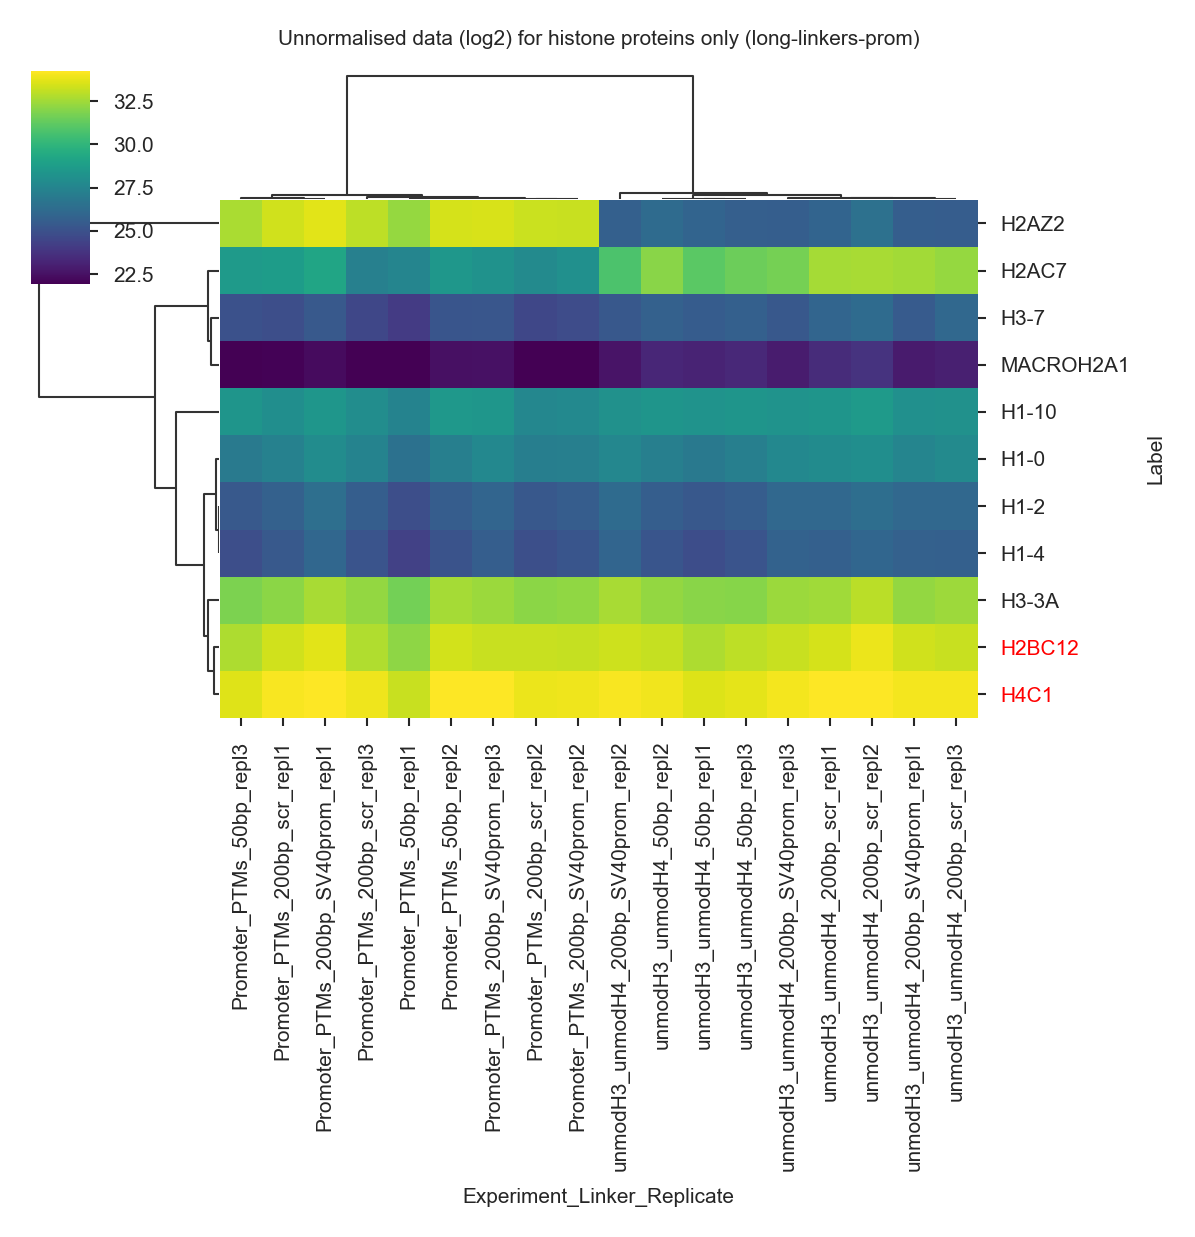

In [27]:
_cmap = sns.clustermap(
    data_numeric_log2_histones.fillna(0),
    mask=data_numeric_log2_histones.isnull(),
    cmap='viridis', robust=True, 
    figsize=(20*FIVE_MM_IN_INCH, 20*FIVE_MM_IN_INCH),
    metric='correlation',
    method='complete',
)
_cmap.ax_col_dendrogram.set_title(f"Unnormalised data (log2) for histone proteins only ({DATASET})")

for tick in _cmap.ax_heatmap.get_yticklabels():
    tick_text = tick.get_text()
    if tick_text in NORMALISATION_PROTEINS:
        tick.set_color('red')

_fname = OUTPUT_DIRECTORY / f'02-normalisation-histones-heatmap-unnormalised.{DATASET}.pdf'
_caption = f"""
Boxplot showing the unnormalised log2 data for histone proteins only ({DATASET}).
The proteins are plotted on the Y axis, and the experiments on the X.

Proteins selected as normalisation factors are highlighted in red.
"""
plt.savefig(_fname, bbox_inches='tight', dpi=DPI)
with open(str(_fname) + '.caption.md', 'w') as f:
    f.write(_caption)
    print(_caption)

Let's Mark NORMALISATION_PROTEINS as "Used for normalisation"

In [28]:
comments_norm = pd.Series(None, dtype=object, index=data_numeric_log2.index)
for norm_prot in NORMALISATION_PROTEINS:
    try:
        comments_norm.loc[norm_prot] = 'Used for normalisation'
    except KeyError:
        continue

To normalise we will take a median of M-offsets from the data, the M-offsets can obtained by subtracting the row-wise mean from the data:

In [29]:
data_numeric_log2.sub(data_numeric_log2.mean(axis=1), axis=0)

Experiment_Linker_Replicate  Promoter_PTMs_50bp_repl1  \
Label                                                   
MYH9                                        -0.725270   
SPTAN1                                      -0.545522   
PRKDC                                        0.158992   
SPTBN1                                      -0.408303   
ACTB                                        -0.489826   
...                                               ...   
ADD1                                        -0.161436   
CCNK                                        -0.734927   
DCAF13                                            NaN   
YTHDF2                                      -1.481113   
BAX                                         -0.119907   

Experiment_Linker_Replicate  Promoter_PTMs_200bp_scr_repl1  \
Label                                                        
MYH9                                              0.010354   
SPTAN1                                           -0.217829   
PRKDC                                            -0.241940   
SPTBN1                                            0.353336   
ACTB                                             -0.051792   
...                                                    ...   
ADD1                                              0.295478   
CCNK                                             -0.277468   
DCAF13                                            0.696041   
YTHDF2                                            0.319902   
BAX                                              -1.304772   

Experiment_Linker_Replicate  Promoter_PTMs_200bp_SV40prom_repl1  \
Label                                                             
MYH9                                                   0.236820   
SPTAN1                                                 0.125511   
PRKDC                                                  0.137778   
SPTBN1                                                 0.728838   
ACTB                                                   0.108983   
...                                                         ...   
ADD1                                                   0.006156   
CCNK                                                   1.020875   
DCAF13                                                 0.658329   
YTHDF2                                                 0.420039   
BAX                                                   -0.194509   

Experiment_Linker_Replicate  unmodH3_unmodH4_50bp_repl1  \
Label                                                     
MYH9                                           0.106161   
SPTAN1                                         0.164330   
PRKDC                                          0.314246   
SPTBN1                                        -0.189583   
ACTB                                           0.083445   
...                                                 ...   
ADD1                                          -1.939902   
CCNK                                          -1.104076   
DCAF13                                        -0.691446   
YTHDF2                                        -0.538794   
BAX                                            0.452159   

Experiment_Linker_Replicate  unmodH3_unmodH4_200bp_scr_repl1  \
Label                                                          
MYH9                                                0.304636   
SPTAN1                                              0.201479   
PRKDC                                               0.434525   
SPTBN1                                              0.041434   
ACTB                                                0.226339   
...                                                      ...   
ADD1                                               -0.109253   
CCNK                                               -0.082821   
DCAF13                                              0.619015   
YTHDF2                                              0.760689   
BAX                                        

## Normalisation factors calculation

We will now compute the MA statistics from the unnormalised data.

MA statistics are simply row-wise averages of the data (avg column, the A part) And the log2 offsets from this average (log2_diff column, the M part)

In [30]:
data_numeric_log2_row_averages = data_numeric_log2.mean(axis=1)
data_numeric_log2_row_averages.name = 'avg'
    
data_numeric_log2_row_averages

Label
MYH9      30.980917
SPTAN1    29.512965
PRKDC     29.278474
SPTBN1    29.834084
ACTB      34.053543
            ...    
ADD1      23.118290
CCNK      20.279897
DCAF13    19.333179
YTHDF2    26.300167
BAX       21.690138
Name: avg, Length: 1600, dtype: float64

In [31]:
data_numeric_log2.head()

Experiment_Linker_Replicate  Promoter_PTMs_50bp_repl1  \
Label                                                   
MYH9                                        30.255647   
SPTAN1                                      28.967443   
PRKDC                                       29.437465   
SPTBN1                                      29.425781   
ACTB                                        33.563718   

Experiment_Linker_Replicate  Promoter_PTMs_200bp_scr_repl1  \
Label                                                        
MYH9                                             30.991271   
SPTAN1                                           29.295136   
PRKDC                                            29.036534   
SPTBN1                                           30.187421   
ACTB                                             34.001752   

Experiment_Linker_Replicate  Promoter_PTMs_200bp_SV40prom_repl1  \
Label                                                             
MYH9                                                  31.217738   
SPTAN1                                                29.638476   
PRKDC                                                 29.416251   
SPTBN1                                                30.562922   
ACTB                                                  34.162526   

Experiment_Linker_Replicate  unmodH3_unmodH4_50bp_repl1  \
Label                                                     
MYH9                                          31.087078   
SPTAN1                                        29.677295   
PRKDC                                         29.592720   
SPTBN1                                        29.644501   
ACTB                                          34.136988   

Experiment_Linker_Replicate  unmodH3_unmodH4_200bp_scr_repl1  \
Label                                                          
MYH9                                               31.285553   
SPTAN1                                             29.714444   
PRKDC                                              29.712998   
SPTBN1                                             29.875519   
ACTB                                               34.279882   

Experiment_Linker_Replicate  unmodH3_unmodH4_200bp_SV40prom_repl1  \
Label                                                               
MYH9                                                    30.922919   
SPTAN1                                                  29.472373   
PRKDC                                                   29.198195   
SPTBN1                                                  28.964014   
ACTB                                                    34.061411   

Experiment_Linker_Replicate  Promoter_PTMs_50bp_repl2  \
Label                                                   
MYH9                                        31.413533   
SPTAN1                                      29.884800   
PRKDC                                       29.285953   
SPTBN1                                      30.518209   
ACTB                                        34.365596   

Experiment_Linker_Replicate  Promoter_PTMs_200bp_scr_repl2  \
Label                                                        
MYH9                                             30.735818   
SPTAN1                                           29.017519   
PRKDC                                            28.493189   
SPTBN1                                           30.007972   
ACTB                                             33.623899   

Experiment_Linker_Replicate  Promoter_PTMs_200bp_SV40prom_repl2  \
Label                                                             
MYH9                                                  30.742724   
SPTAN1                                                29.044032   
PRKDC                                                 28.595848   
SPTBN1                                                29.983020   
ACTB                                                  33.548062   

Experiment_Linker_Replicate  unmodH3_unmodH

In [32]:
data_numeric_log2_diffs = data_numeric_log2.sub(data_numeric_log2_row_averages, axis=0)
data_numeric_log2_diffs

Experiment_Linker_Replicate  Promoter_PTMs_50bp_repl1  \
Label                                                   
MYH9                                        -0.725270   
SPTAN1                                      -0.545522   
PRKDC                                        0.158992   
SPTBN1                                      -0.408303   
ACTB                                        -0.489826   
...                                               ...   
ADD1                                        -0.161436   
CCNK                                        -0.734927   
DCAF13                                            NaN   
YTHDF2                                      -1.481113   
BAX                                         -0.119907   

Experiment_Linker_Replicate  Promoter_PTMs_200bp_scr_repl1  \
Label                                                        
MYH9                                              0.010354   
SPTAN1                                           -0.217829   
PRKDC                                            -0.241940   
SPTBN1                                            0.353336   
ACTB                                             -0.051792   
...                                                    ...   
ADD1                                              0.295478   
CCNK                                             -0.277468   
DCAF13                                            0.696041   
YTHDF2                                            0.319902   
BAX                                              -1.304772   

Experiment_Linker_Replicate  Promoter_PTMs_200bp_SV40prom_repl1  \
Label                                                             
MYH9                                                   0.236820   
SPTAN1                                                 0.125511   
PRKDC                                                  0.137778   
SPTBN1                                                 0.728838   
ACTB                                                   0.108983   
...                                                         ...   
ADD1                                                   0.006156   
CCNK                                                   1.020875   
DCAF13                                                 0.658329   
YTHDF2                                                 0.420039   
BAX                                                   -0.194509   

Experiment_Linker_Replicate  unmodH3_unmodH4_50bp_repl1  \
Label                                                     
MYH9                                           0.106161   
SPTAN1                                         0.164330   
PRKDC                                          0.314246   
SPTBN1                                        -0.189583   
ACTB                                           0.083445   
...                                                 ...   
ADD1                                          -1.939902   
CCNK                                          -1.104076   
DCAF13                                        -0.691446   
YTHDF2                                        -0.538794   
BAX                                            0.452159   

Experiment_Linker_Replicate  unmodH3_unmodH4_200bp_scr_repl1  \
Label                                                          
MYH9                                                0.304636   
SPTAN1                                              0.201479   
PRKDC                                               0.434525   
SPTBN1                                              0.041434   
ACTB                                                0.226339   
...                                                      ...   
ADD1                                               -0.109253   
CCNK                                               -0.082821   
DCAF13                                              0.619015   
YTHDF2                                              0.760689   
BAX                                        

In [33]:

data_numeric_log2_ma = data_numeric_log2_diffs.stack()
data_numeric_log2_ma.name = 'log2_diff'
data_numeric_log2_ma = data_numeric_log2_ma.reset_index().join(data_numeric_log2_row_averages, on='Label')
data_numeric_log2_ma

Label           Experiment_Linker_Replicate  log2_diff        avg
0      MYH9              Promoter_PTMs_50bp_repl1  -0.725270  30.980917
1      MYH9         Promoter_PTMs_200bp_scr_repl1   0.010354  30.980917
2      MYH9    Promoter_PTMs_200bp_SV40prom_repl1   0.236820  30.980917
3      MYH9            unmodH3_unmodH4_50bp_repl1   0.106161  30.980917
4      MYH9       unmodH3_unmodH4_200bp_scr_repl1   0.304636  30.980917
...     ...                                   ...        ...        ...
27537   BAX         Promoter_PTMs_200bp_scr_repl3  -0.463793  21.690138
27538   BAX    Promoter_PTMs_200bp_SV40prom_repl3  -0.062240  21.690138
27539   BAX            unmodH3_unmodH4_50bp_repl3   1.001953  21.690138
27540   BAX       unmodH3_unmodH4_200bp_scr_repl3   0.651873  21.690138
27541   BAX  unmodH3_unmodH4_200bp_SV40prom_repl3   1.054603  21.690138

[27542 rows x 4 columns]

We will now compute the normalisation factors from the NORMALISATION_PROTEINS.

We take the median of the M offsets of the NORMALISATION_PROTEINS

In [34]:
# Get the normfactors from MA offsets
_ma_data_for_normalisation_proteins = data_numeric_log2_ma[
    data_numeric_log2_ma['Label'].isin(NORMALISATION_PROTEINS)
]

normalisation_factors = _ma_data_for_normalisation_proteins.groupby('Experiment_Linker_Replicate')['log2_diff'].median()


In [35]:
normalisation_factors

Experiment_Linker_Replicate
Promoter_PTMs_200bp_SV40prom_repl1      0.458761
Promoter_PTMs_200bp_SV40prom_repl2     -0.032480
Promoter_PTMs_200bp_SV40prom_repl3      0.136210
Promoter_PTMs_200bp_scr_repl1           0.132937
Promoter_PTMs_200bp_scr_repl2          -0.033421
Promoter_PTMs_200bp_scr_repl3          -0.215188
Promoter_PTMs_50bp_repl1               -0.911100
Promoter_PTMs_50bp_repl2                0.248871
Promoter_PTMs_50bp_repl3               -0.390838
unmodH3_unmodH4_200bp_SV40prom_repl1    0.103627
unmodH3_unmodH4_200bp_SV40prom_repl2    0.130720
unmodH3_unmodH4_200bp_SV40prom_repl3    0.041206
unmodH3_unmodH4_200bp_scr_repl1         0.275133
unmodH3_unmodH4_200bp_scr_repl2         0.712261
unmodH3_unmodH4_200bp_scr_repl3         0.035507
unmodH3_unmodH4_50bp_repl1             -0.439145
unmodH3_unmodH4_50bp_repl2             -0.032792
unmodH3_unmodH4_50bp_repl3             -0.220269
Name: log2_diff, dtype: float64

## Plots (before)

## MA

To illustrate the normalisation behaviour it is helpful to make some MA plots:

In [36]:
# Clean up memory a bit
plt.close('all')

/usr/local/Caskroom/miniconda/base/envs/marcs-variable-linker-pds/lib/python3.10/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


(11, 4)


(11, 4)


(11, 4)


(11, 4)


(11, 4)


(11, 4)


(11, 4)


(11, 4)


(11, 4)


(11, 4)


(11, 4)


(11, 4)


(11, 4)


(11, 4)


(11, 4)


(11, 4)


(11, 4)


(11, 4)



MA-like plot for log2-transformed, unnormalised and unfiltered data (long-linkers-prom).

X axis plots mean(log2_intensity) across data rows (proteins). X axis is the same in every plot.
Y axis plots log2_intensity - mean(log2_intensity) offsets for individual samples

Histone proteins are highlighted in green.
Red line indicates the normalisation factor estimate.



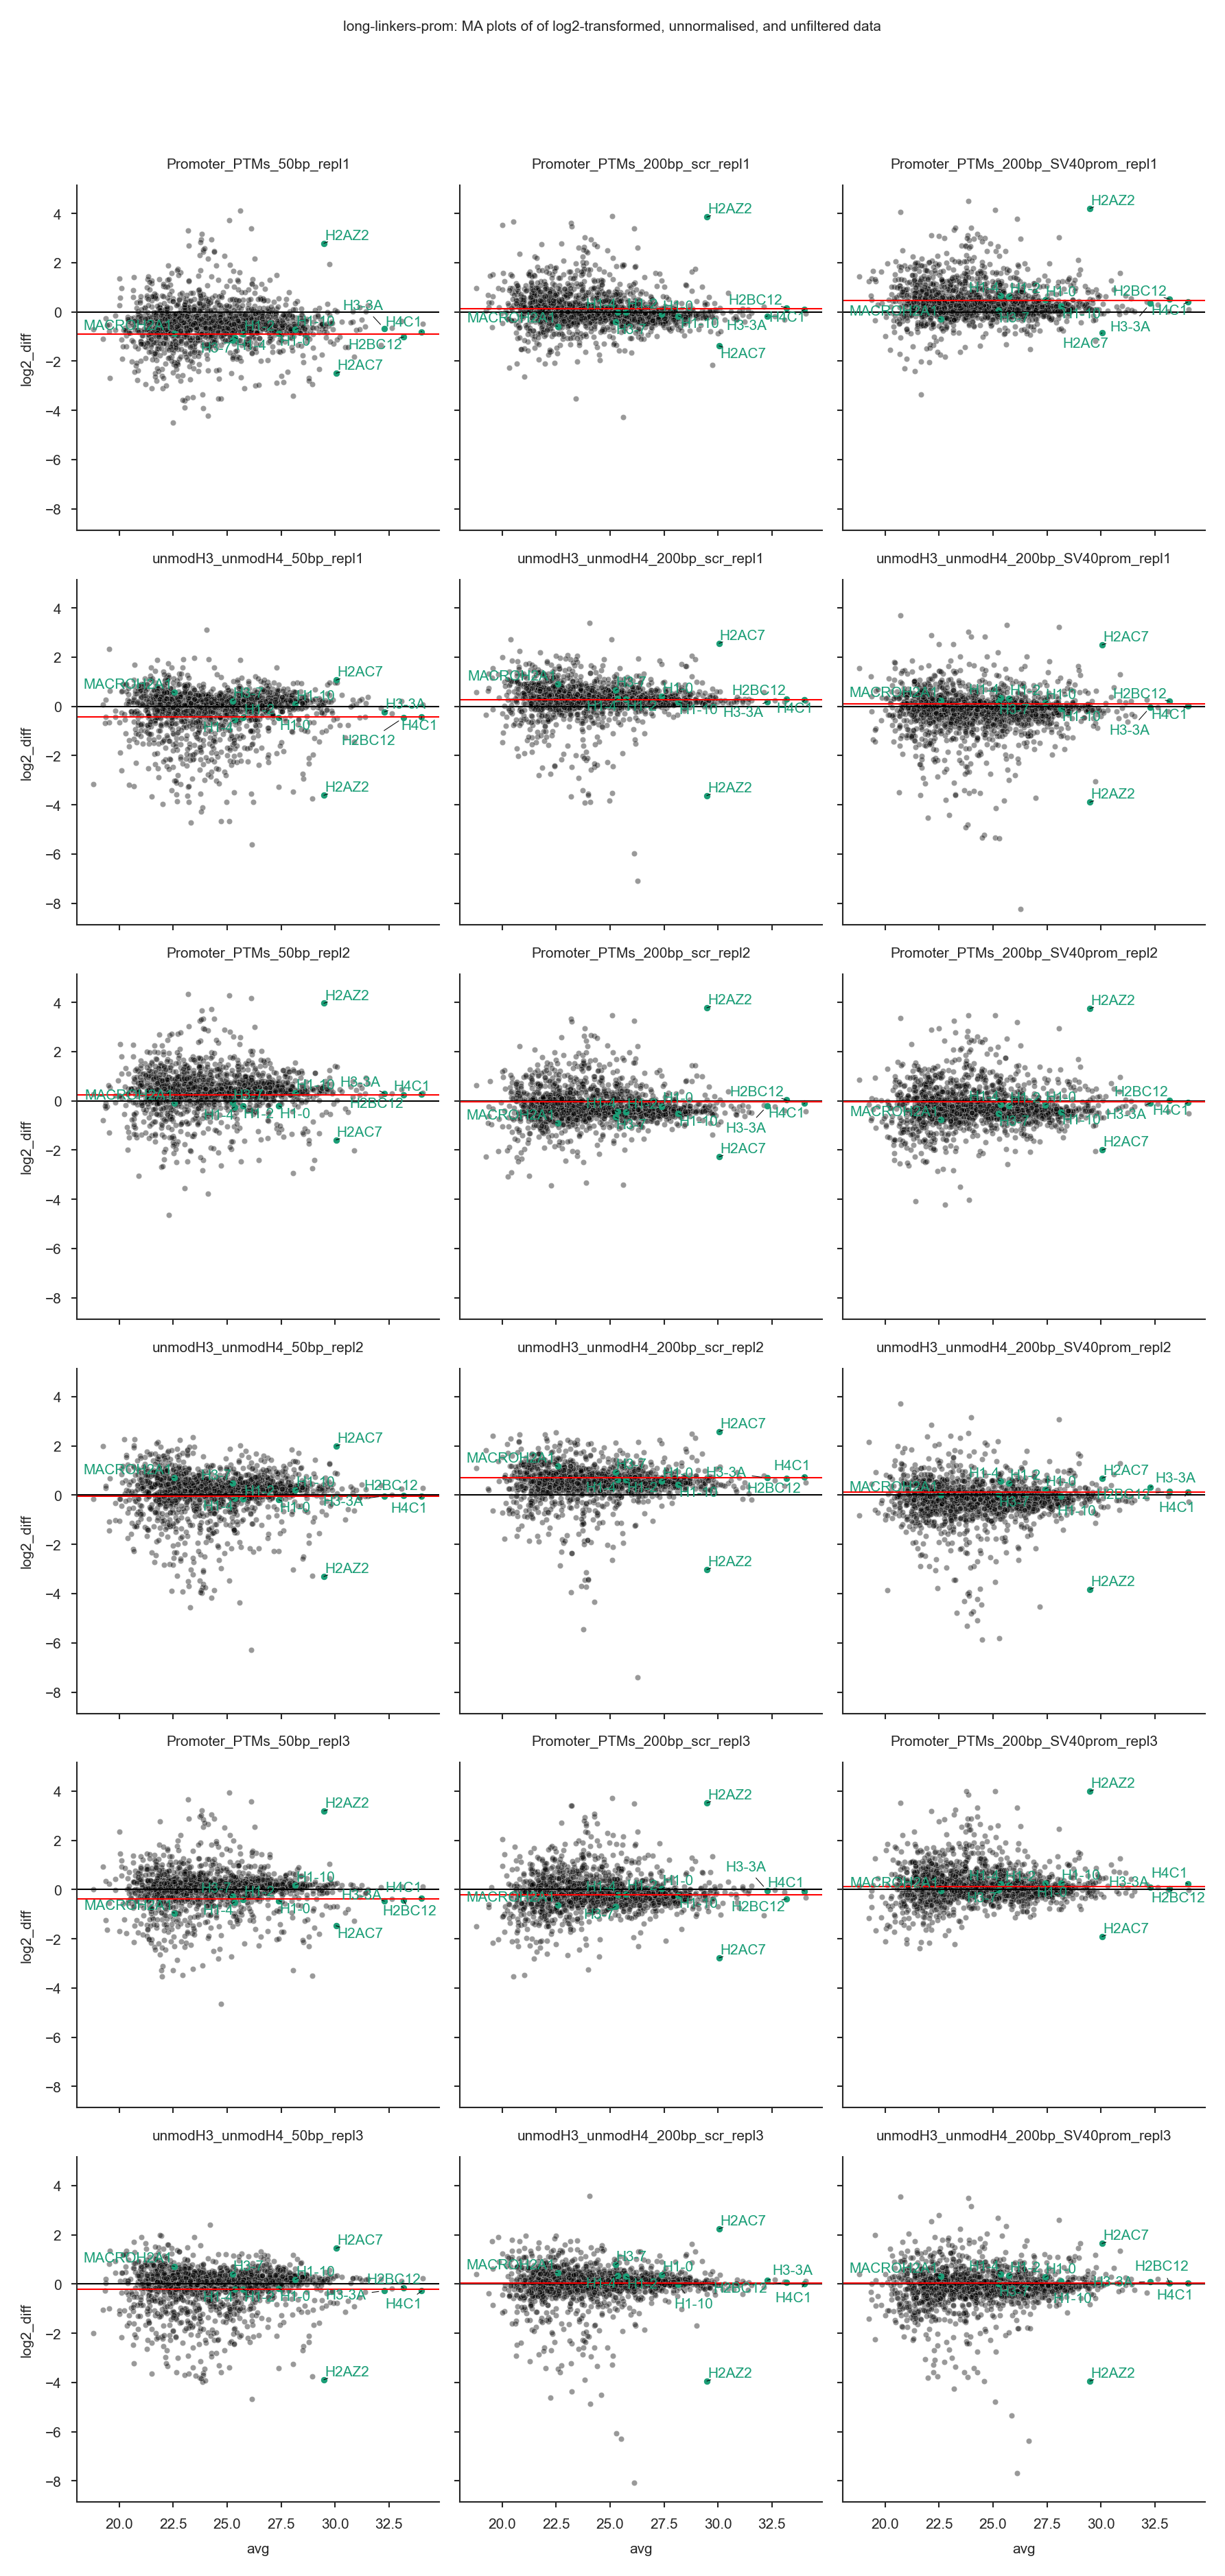

In [37]:
from adjustText import adjust_text
def annotate_histones(x, y, *, color=None, data=None):
    data_histones = data[data['Label'].isin(HISTONES)]
    ax = plt.gca()
    
    print(data_histones.shape)
    ax.scatter(data_histones[x], data_histones[y], color=color)
    
    texts = []
    for __, row in data_histones.iterrows():
        texts.append(ax.text(row[x], row[y], row['Label'], color=color))
        
    adjust_text(texts, arrowprops=dict(arrowstyle='-'), ax=ax)
    
def add_horizontal_line(*args, color=None, data=None):
    ax = plt.gca()
    ax.axhline(0, linestyle='-',color='black', zorder=1)

    
fgrid = sns.FacetGrid(col='Experiment_Linker_Replicate', col_wrap=3,
                      size=FIVE_MM_IN_INCH*10,
                      col_order=data_numeric_log2.columns, data=data_numeric_log2_ma)
fgrid.map(sns.scatterplot, 'avg', 'log2_diff', alpha=.4, color='black', rasterized=True)
fgrid.map_dataframe(annotate_histones, 'avg', 'log2_diff')
fgrid.map_dataframe(add_horizontal_line)
fgrid.set_titles('{col_name}')

for experiment, ax in fgrid.axes_dict.items():
    ax.axhline(normalisation_factors.loc[experiment], color='r', linestyle='-')
    ax.grid(False)

plt.suptitle(f"{DATASET}: MA plots of of log2-transformed, unnormalised, and unfiltered data", y=1.05)

_fname = OUTPUT_DIRECTORY / f'02-normalisation-log2-transformed-unnormalised-unfiltered-ma-plot.{DATASET}.pdf'
_caption = f"""
MA-like plot for log2-transformed, unnormalised and unfiltered data ({DATASET}).

X axis plots mean(log2_intensity) across data rows (proteins). X axis is the same in every plot.
Y axis plots log2_intensity - mean(log2_intensity) offsets for individual samples

Histone proteins are highlighted in green.
Red line indicates the normalisation factor estimate.
"""
plt.savefig(_fname, bbox_inches='tight', dpi=DPI)
with open(str(_fname) + '.caption.md', 'w') as f:
    f.write(_caption)
    print(_caption)

# Boxplot

Alternatively, we can plot all of this in a boxplot format:


Boxplot showing the distribution of signal intensities for non-histone proteins (green), and the histone proteins (orange), prior to normalisation (long-linkers-prom).
The intensity is plotted on the X axis, while the samples are facetted on the Y. The outliers ("fliers") are hidden.

Black line shows the estimated normalisation offsets centred around the mean of normalisation proteins.



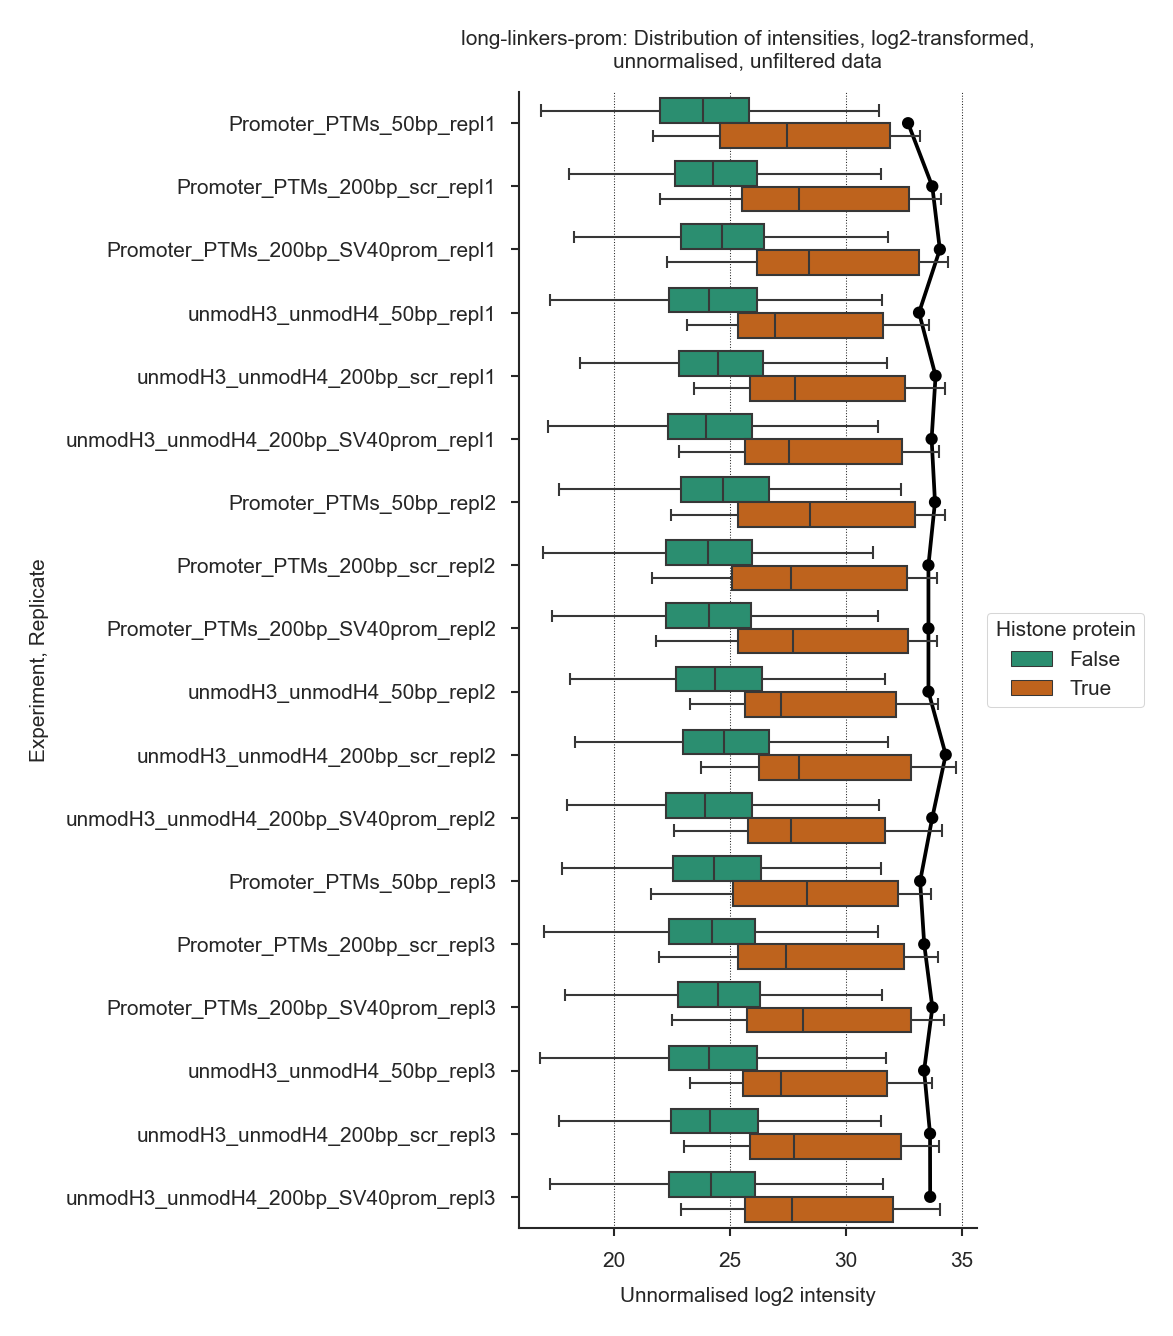

In [38]:

_df = data_numeric_log2.stack(list(data_numeric_log2.columns.names)).copy()
_df.name = 'log2_intensity_unnormalised'
_df = _df.reset_index()

_df['is_histone'] = False
_df.loc[_df['Label'].isin(HISTONES), 'is_histone'] = True

_df_cov = pd.DataFrame(
    # The + below recentres the normalisation factors around the mean of normalisation proteins
    {'normalisation_factors': normalisation_factors + data_numeric_log2.reindex(NORMALISATION_PROTEINS).mean(axis=1).mean()}, 
)

fig = plt.figure(figsize=(10*FIVE_MM_IN_INCH, 25*FIVE_MM_IN_INCH))
ax = plt.gca()

sns.pointplot(
    y='Experiment_Linker_Replicate', x='normalisation_factors', 
    data=_df_cov.reset_index(),
    order=data_numeric_log2.columns,
    marker='.',
    color='black',
    label="Estimated covariates",
)

sns.boxplot(
    y='Experiment_Linker_Replicate', x='log2_intensity_unnormalised', 
    data=_df, hue='is_histone', showfliers=False,
    order=data_numeric_log2.columns,
)


ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Histone protein")
ax.set_xlabel("Unnormalised log2 intensity")
ax.set_ylabel("Experiment, Replicate")
ax.set_title(f"{DATASET}: Distribution of intensities, log2-transformed,\nunnormalised, unfiltered data")

_fname = OUTPUT_DIRECTORY / f'02-normalisation-boxplot.{DATASET}.pdf'
_caption = f"""
Boxplot showing the distribution of signal intensities for non-histone proteins (green), and the histone proteins (orange), prior to normalisation ({DATASET}).
The intensity is plotted on the X axis, while the samples are facetted on the Y. The outliers ("fliers") are hidden.

Black line shows the estimated normalisation offsets centred around the mean of normalisation proteins.
"""
plt.savefig(_fname, bbox_inches='tight', dpi=DPI)
with open(str(_fname) + '.caption.md', 'w') as f:
    f.write(_caption)
    print(_caption)

## The bit where normalisation is performed

To perform the normalisation we simply subtract the normalisation factors from the dataset.

Note that as we are using (zero-centred) offsets for the normalisation, the intuitive meaning of the normalised intensities stays more or less the same.

In [39]:
data_numeric_log2_normalised = data_numeric_log2 - normalisation_factors
# In the row below we need to make sure column order stays the same
data_numeric_log2_normalised = data_numeric_log2_normalised[data_numeric_log2.columns]

Sanity check:

In [40]:
from numpy.testing import assert_array_equal

# The minus operator above works columnwise, we can confirm this
for col in data_numeric_log2_normalised:
    assert_array_equal(data_numeric_log2_normalised[col], data_numeric_log2[col] - normalisation_factors.loc[col])

    

The normalisation has the effect of making the normalisation protein M-offsets constant (though not necessarily zero, as median is used, not mean):

In [41]:
data_numeric_log2_normalised.sub(data_numeric_log2_normalised.mean(axis=1), axis=0).reindex(NORMALISATION_PROTEINS).dropna(how='all')

Experiment_Linker_Replicate  Promoter_PTMs_50bp_repl1  \
Label                                                   
H4C1                                         0.104112   
H2BC12                                      -0.104112   

Experiment_Linker_Replicate  Promoter_PTMs_200bp_scr_repl1  \
Label                                                        
H4C1                                             -0.032454   
H2BC12                                            0.032454   

Experiment_Linker_Replicate  Promoter_PTMs_200bp_SV40prom_repl1  \
Label                                                             
H4C1                                                   -0.06073   
H2BC12                                                  0.06073   

Experiment_Linker_Replicate  unmodH3_unmodH4_50bp_repl1  \
Label                                                     
H4C1                                           0.022649   
H2BC12                                        -0.022649   

Experiment_Linker_Replicate  unmodH3_unmodH4_200bp_scr_repl1  \
Label                                                          
H4C1                                               -0.019161   
H2BC12                                              0.019161   

Experiment_Linker_Replicate  unmodH3_unmodH4_200bp_SV40prom_repl1  \
Label                                                               
H4C1                                                     -0.09855   
H2BC12                                                    0.09855   

Experiment_Linker_Replicate  Promoter_PTMs_50bp_repl2  \
Label                                                   
H4C1                                         0.013401   
H2BC12                                      -0.013401   

Experiment_Linker_Replicate  Promoter_PTMs_200bp_scr_repl2  \
Label                                                        
H4C1                                             -0.072549   
H2BC12                                            0.072549   

Experiment_Linker_Replicate  Promoter_PTMs_200bp_SV40prom_repl2  \
Label                                                             
H4C1                                                  -0.045295   
H2BC12                                                 0.045295   

Experiment_Linker_Replicate  unmodH3_unmodH4_50bp_repl2  \
Label                                                     
H4C1                                          -0.009429   
H2BC12                                         0.009429   

Experiment_Linker_Replicate  unmodH3_unmodH4_200bp_scr_repl2  \
Label                                                          
H4C1                                                0.019272   
H2BC12                                             -0.019272   

Experiment_Linker_Replicate  unmodH3_unmodH4_200bp_SV40prom_repl2  \
Label                                                               
H4C1                                                    -0.008831   
H2BC12                                                   0.008831   

Experiment_Linker_Replicate  Promoter_PTMs_50bp_repl3  \
Label                                                   
H4C1                                         0.030787   
H2BC12                                      -0.030787   

Experiment_Linker_Replicate  Promoter_PTMs_200bp_scr_repl3  \
Label                                                        
H4C1                                              0.154949   
H2BC12                                           -0.154949   

Experiment_Linker_Replicate  Promoter_PTMs_200bp_SV40prom_repl3  \
Label                                                             
H4C1                                                   0.092926   
H2BC12                                                -0.092926   

Experiment_Linker_Replicate  unmodH3_unmodH4_50bp_repl3  \
Label                                                     
H4C1                                          -0.060798   
H2BC12                                  

In [42]:
data_numeric_log2_normalised.sub(data_numeric_log2_normalised.mean(axis=1), axis=0).reindex(NORMALISATION_PROTEINS).dropna(how='all').median()

Experiment_Linker_Replicate
Promoter_PTMs_50bp_repl1                3.552714e-15
Promoter_PTMs_200bp_scr_repl1           3.552714e-15
Promoter_PTMs_200bp_SV40prom_repl1      1.065814e-14
unmodH3_unmodH4_50bp_repl1              3.552714e-15
unmodH3_unmodH4_200bp_scr_repl1         1.065814e-14
unmodH3_unmodH4_200bp_SV40prom_repl1    3.552714e-15
Promoter_PTMs_50bp_repl2                7.105427e-15
Promoter_PTMs_200bp_scr_repl2           3.552714e-15
Promoter_PTMs_200bp_SV40prom_repl2      7.105427e-15
unmodH3_unmodH4_50bp_repl2              7.105427e-15
unmodH3_unmodH4_200bp_scr_repl2         3.552714e-15
unmodH3_unmodH4_200bp_SV40prom_repl2    3.552714e-15
Promoter_PTMs_50bp_repl3                1.065814e-14
Promoter_PTMs_200bp_scr_repl3           7.105427e-15
Promoter_PTMs_200bp_SV40prom_repl3      1.065814e-14
unmodH3_unmodH4_50bp_repl3              7.105427e-15
unmodH3_unmodH4_200bp_scr_repl3         3.552714e-15
unmodH3_unmodH4_200bp_SV40prom_repl3    1.065814e-14
dtype: float64

## Plots (After)


Boxplot showing the distribution of signal intensities for non-histone proteins (green), and the histone proteins (orange), after  normalisation by the mean of histone protein intensities (long-linkers-prom).
The intensity is plotted on the X axis, while the samples are facetted on the Y. The outliers ("fliers") are hidden.



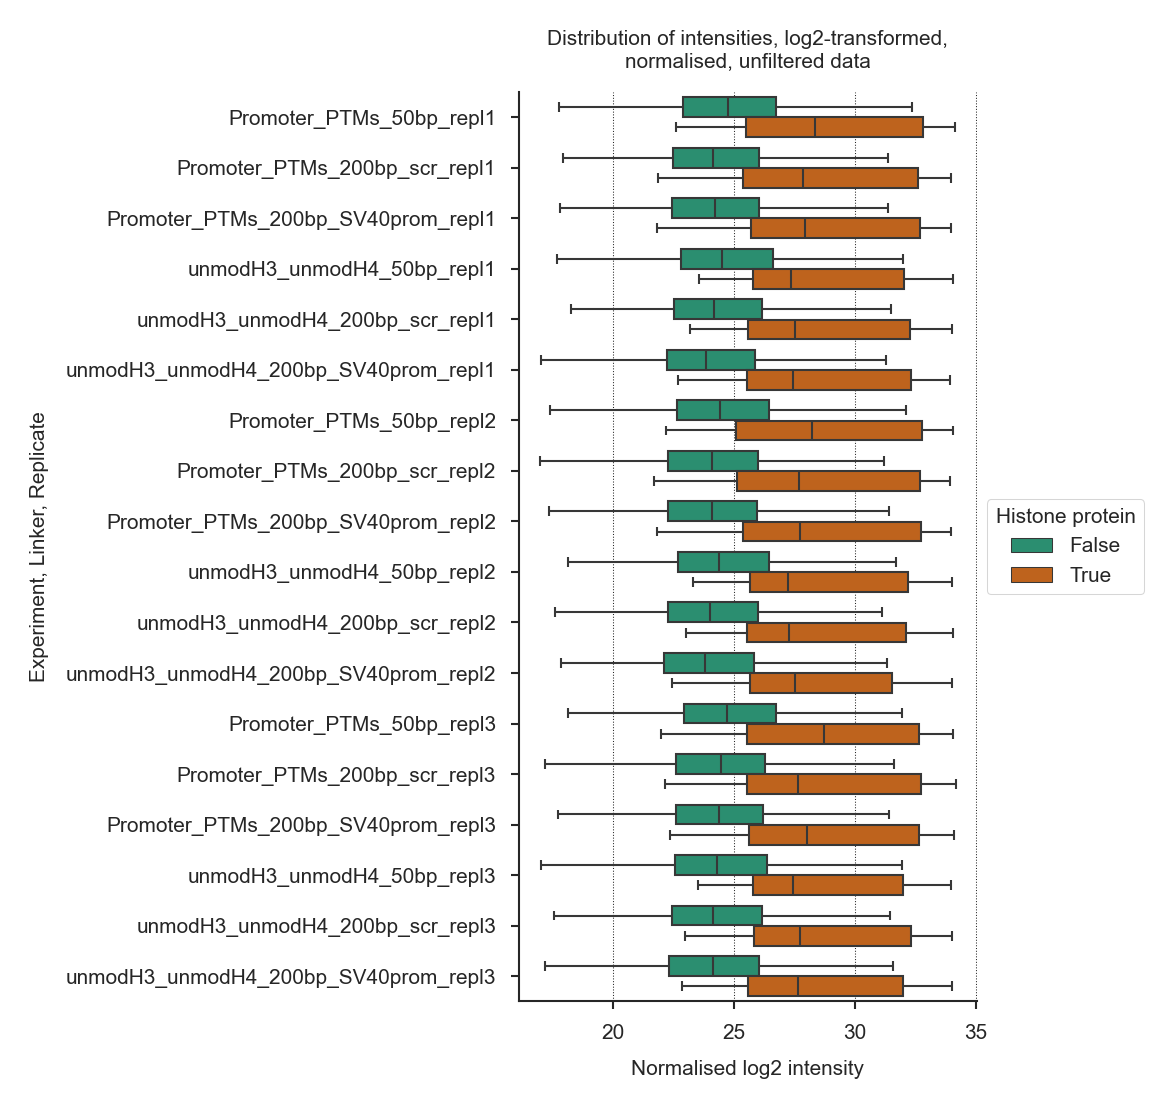

In [43]:

_df = data_numeric_log2_normalised.stack(list(data_numeric_log2.columns.names)).copy()
_df.name = 'log2_intensity_normalised'
_df = _df.reset_index()

_df['is_histone'] = False
_df.loc[_df['Label'].isin(HISTONES), 'is_histone'] = True


fig = plt.figure(figsize=(10*FIVE_MM_IN_INCH, 20*FIVE_MM_IN_INCH))
ax = plt.gca()

sns.boxplot(
    y='Experiment_Linker_Replicate', x='log2_intensity_normalised', 
    data=_df, hue='is_histone', showfliers=False,
    order=data_numeric_log2.columns,
)


ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Histone protein")
ax.set_xlabel("Normalised log2 intensity")
ax.set_ylabel("Experiment, Linker, Replicate")
ax.set_title("Distribution of intensities, log2-transformed,\nnormalised, unfiltered data")

_fname = OUTPUT_DIRECTORY / f'02-normalisation-boxplot-post-normalisation.{DATASET}.pdf'
_caption = f"""
Boxplot showing the distribution of signal intensities for non-histone proteins (green), and the histone proteins (orange), after  normalisation by the mean of histone protein intensities ({DATASET}).
The intensity is plotted on the X axis, while the samples are facetted on the Y. The outliers ("fliers") are hidden.
"""
plt.savefig(_fname, bbox_inches='tight', dpi=DPI)
with open(str(_fname) + '.caption.md', 'w') as f:
    f.write(_caption)
    print(_caption)

#### Histone heatmap
Let's replot histone heatmap after normalisation


Boxplot showing the unnormalised log2 data for histone proteins only (long-linkers-prom).
The proteins are plotted on the Y axis, and the experiments on the X.

Proteins selected as normalisation factors are highlighted in red.



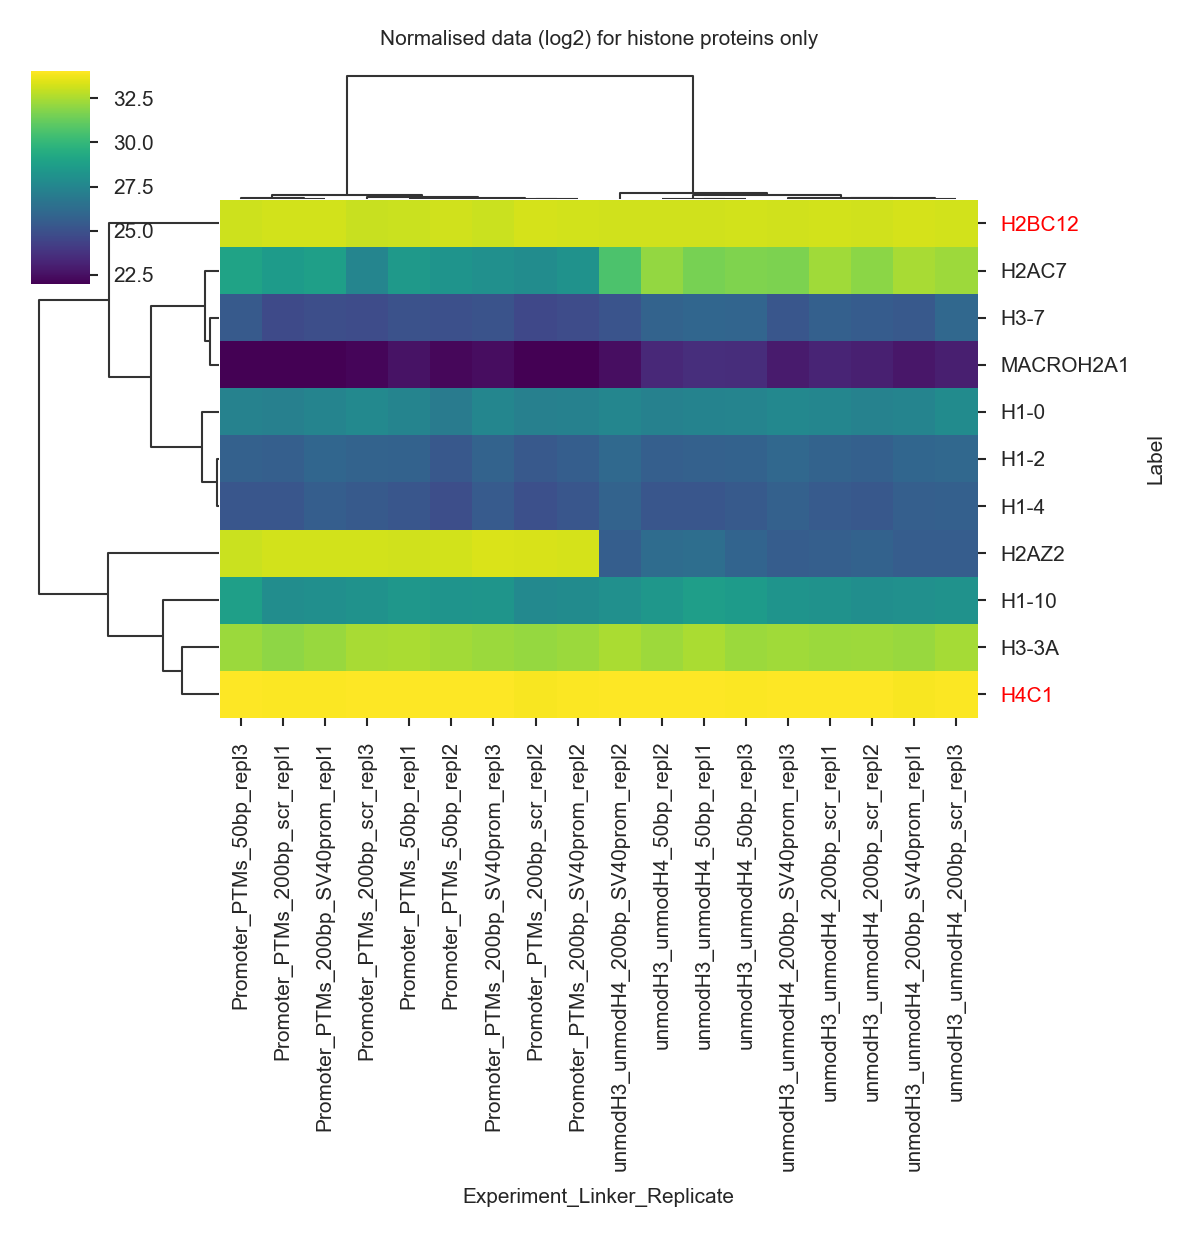

In [44]:
_mtrix = data_numeric_log2_normalised.reindex(HISTONES).dropna(how='all')
_cmap = sns.clustermap(
    _mtrix.fillna(0),
    mask=_mtrix.isnull(),
    cmap='viridis', robust=True, 
    figsize=(20*FIVE_MM_IN_INCH, 20*FIVE_MM_IN_INCH),
    metric='correlation',
    method='complete',
)
_cmap.ax_col_dendrogram.set_title("Normalised data (log2) for histone proteins only")

for tick in _cmap.ax_heatmap.get_yticklabels():
    tick_text = tick.get_text()
    if tick_text in NORMALISATION_PROTEINS:
        tick.set_color('red')

_fname = OUTPUT_DIRECTORY / f'02-normalisation-histones-heatmap-post-normalisation.{DATASET}.pdf'
_caption = f"""
Boxplot showing the unnormalised log2 data for histone proteins only ({DATASET}).
The proteins are plotted on the Y axis, and the experiments on the X.

Proteins selected as normalisation factors are highlighted in red.
"""
plt.savefig(_fname, bbox_inches='tight', dpi=DPI)
with open(str(_fname) + '.caption.md', 'w') as f:
    f.write(_caption)
    print(_caption)

#### MA 

In [45]:
data_numeric_log2_normalised_row_averages = data_numeric_log2_normalised.mean(axis=1)
data_numeric_log2_normalised_row_averages.name = 'avg'
  

In [46]:
data_numeric_log2_normalised_row_averages

Label
MYH9      30.980917
SPTAN1    29.512965
PRKDC     29.278474
SPTBN1    29.834084
ACTB      34.053543
            ...    
ADD1      23.118290
CCNK      20.261947
DCAF13    19.217871
YTHDF2    26.300167
BAX       21.690138
Name: avg, Length: 1600, dtype: float64

In [47]:
data_numeric_log2_normalised_diffs = data_numeric_log2_normalised.sub(data_numeric_log2_normalised_row_averages, axis=0)


In [48]:

data_numeric_log2_normalised_ma = data_numeric_log2_normalised_diffs.stack()
data_numeric_log2_normalised_ma.name = 'log2_diff'
data_numeric_log2_normalised_ma = data_numeric_log2_normalised_ma.reset_index().join(data_numeric_log2_normalised_row_averages, on='Label')


/usr/local/Caskroom/miniconda/base/envs/marcs-variable-linker-pds/lib/python3.10/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


(11, 4)


(11, 4)


(11, 4)


(11, 4)


(11, 4)


(11, 4)


(11, 4)


(11, 4)


(11, 4)


(11, 4)


(11, 4)


(11, 4)


(11, 4)


(11, 4)


(11, 4)


(11, 4)


(11, 4)


(11, 4)



MA-like plot for log2-transformed, normalised and unfiltered data (long-linkers-prom)

X axis plots mean(log2_intensity) across data rows (proteins). X axis is the same in every plot.
Y axis plots log2_intensity - mean(log2_intensity) offsets for individual samples

Histone proteins are highlighted in green.

Red line indicates x=0 line around which the data is centered now.



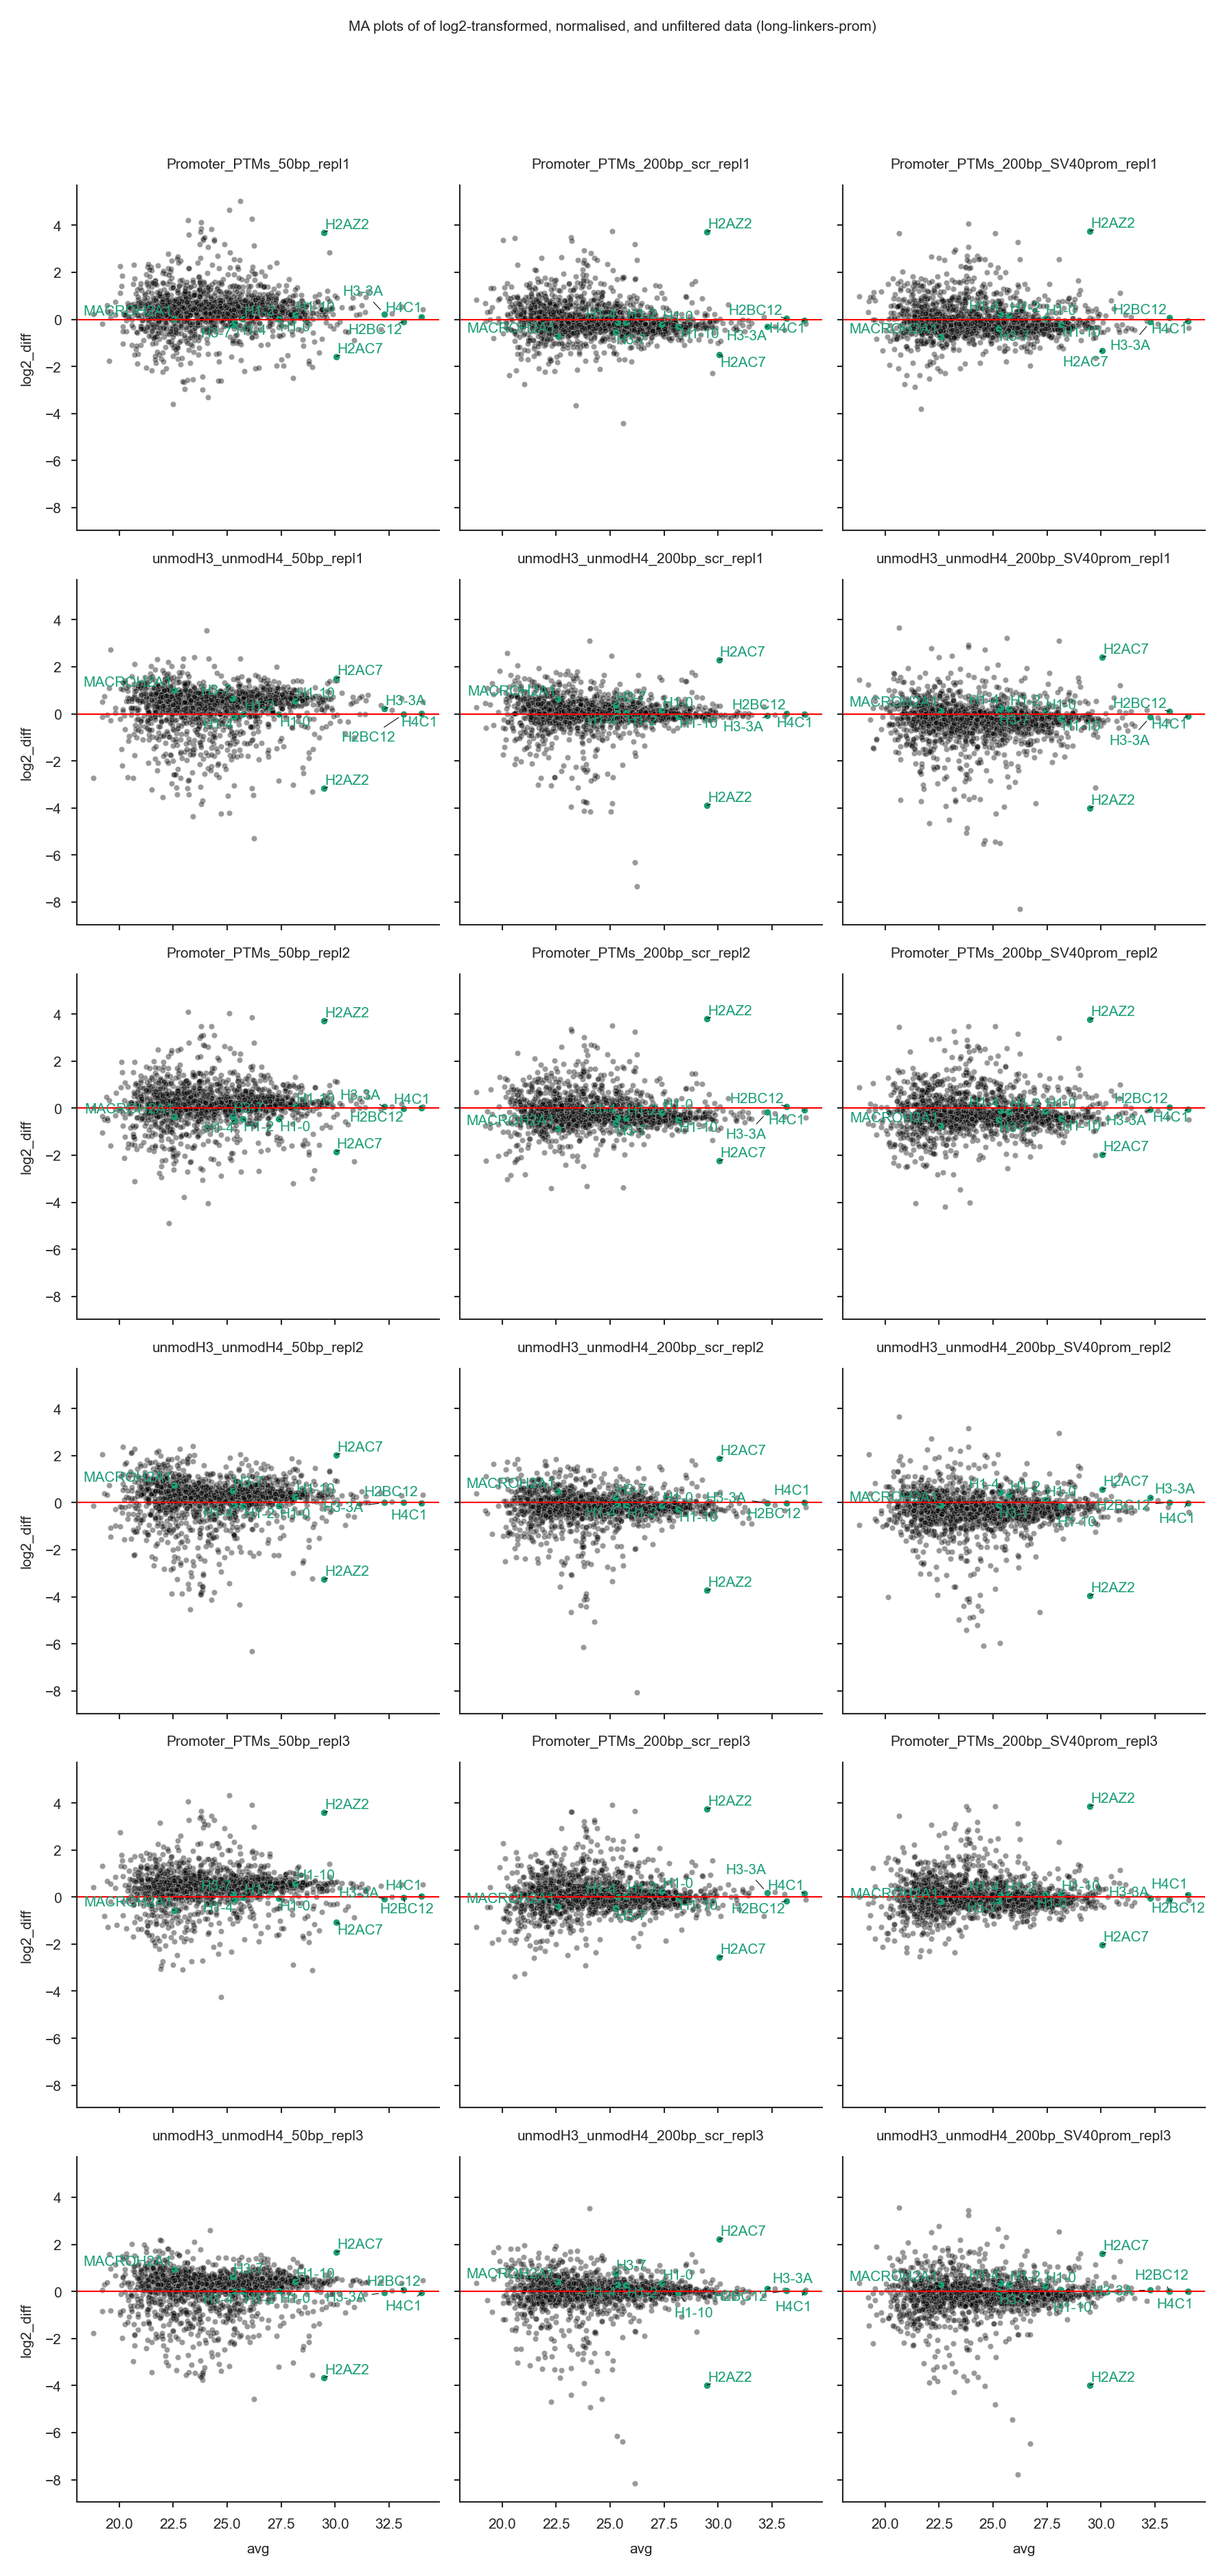

In [49]:
fgrid = sns.FacetGrid(col='Experiment_Linker_Replicate', col_wrap=3,
                      size=FIVE_MM_IN_INCH*10,
                      col_order=data_numeric_log2.columns, data=data_numeric_log2_normalised_ma)
fgrid.map(sns.scatterplot, 'avg', 'log2_diff', alpha=.4, color='black')
fgrid.map_dataframe(annotate_histones, 'avg', 'log2_diff')
# fgrid.map_dataframe(add_horizontal_line)
fgrid.set_titles('{col_name}')
for experiment, ax in fgrid.axes_dict.items():
    ax.axhline(0, linestyle='-', color='red', zorder=1)
    ax.grid(False)

plt.suptitle(f"MA plots of of log2-transformed, normalised, and unfiltered data ({DATASET})", y=1.05)

_fname = OUTPUT_DIRECTORY / f'02-normalisation-log2-transformed-normalised-unfiltered-ma-plot.{DATASET}.pdf'
_caption = f"""
MA-like plot for log2-transformed, normalised and unfiltered data ({DATASET})

X axis plots mean(log2_intensity) across data rows (proteins). X axis is the same in every plot.
Y axis plots log2_intensity - mean(log2_intensity) offsets for individual samples

Histone proteins are highlighted in green.

Red line indicates x=0 line around which the data is centered now.
"""
plt.savefig(_fname, bbox_inches='tight', dpi=DPI)
with open(str(_fname) + '.caption.md', 'w') as f:
    f.write(_caption)
    print(_caption)

#### Correlation matrix


A Pearson correlation matrix showing the coerrelation coefficient estimate,
for the datasets, after normalisation (long-linkers-prom). 



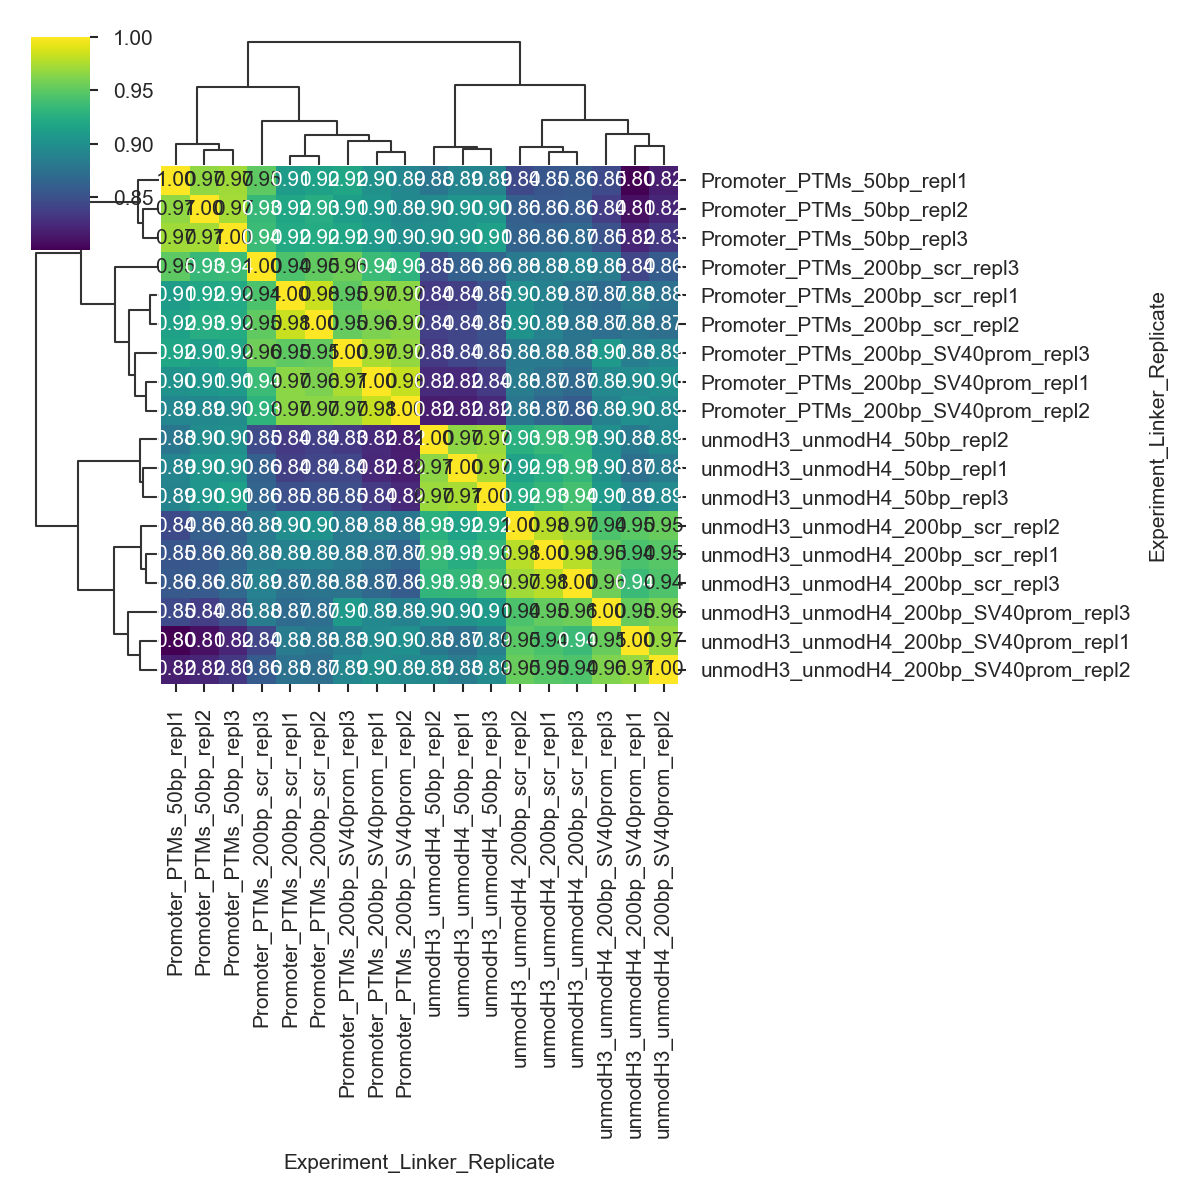

In [50]:
sns.clustermap(data_numeric_log2_normalised.corr(), 
           cmap='viridis', 
           annot=True, fmt='.2f',
           figsize=(FIVE_MM_IN_INCH*20, FIVE_MM_IN_INCH*20))

_fname = OUTPUT_DIRECTORY / f'02-correlation-matrix-of-normalised-data.{DATASET}.pdf'
_caption = f"""
A Pearson correlation matrix showing the coerrelation coefficient estimate,
for the datasets, after normalisation ({DATASET}). 
"""
plt.savefig(_fname, bbox_inches='tight', dpi=DPI)
with open(str(_fname) + '.caption.md', 'w') as f:
    f.write(_caption)
    print(_caption)

#### PCA

We can also observe how the PCA plot changes after the normalisation


Principal Component embedding of log2-transformed, normalised, and unfiltered dataset (long-linkers-prom), including only the rows which have no missing values.
The principal component 1 (PC1) is plotted on the X axis, while the PC2 is plotted on the Y. 
The explained variance ratio is highlighted in parentheses.



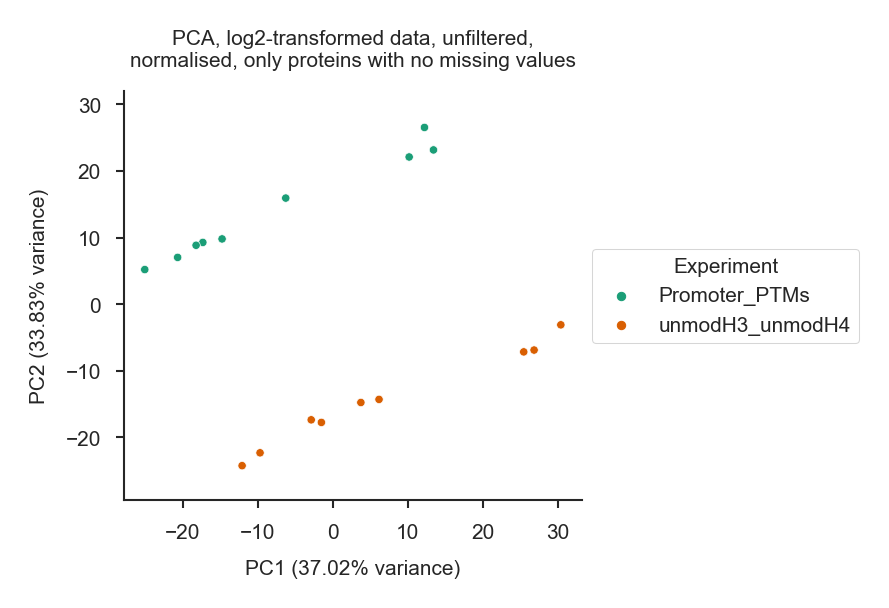

In [51]:
from adjustText import adjust_text
from sklearn.decomposition import PCA

    
plt.figure()
pca = PCA(n_components=2)

# Note that we only look at the rows that are all not null:
projected = pca.fit_transform(data_numeric_log2_normalised.dropna(axis=0).T)

projected = pd.DataFrame(projected, index=data_numeric_log2_normalised.columns, columns=['PC1', 'PC2'])
explained_variance = pd.Series(pca.explained_variance_ratio_, index=projected.columns)

ax = plt.gca()

sns.scatterplot(x='PC1', y='PC2', hue='Experiment', data=projected.join(headers_full))

texts = []
#     for ix, row in projected.iterrows():
#         texts.append(ax.text(row['PC1'], row['PC2'], ix, ha='center', va='center'))

xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Increasing ylim helps place the H3K4me3 labels
ax.set_ylim(ylim[0]*1.1, ylim[1] * 1.1)

adjust_text(texts, projected['PC1'].values, projected['PC2'].values, arrowprops=dict(arrowstyle='-'))

ax.set_xlabel("PC1 ({:.2%} variance)".format(explained_variance.loc['PC1']))
ax.set_ylabel("PC2 ({:.2%} variance)".format(explained_variance.loc['PC2']))
ax.grid(False)
ax.set_title("PCA, log2-transformed data, unfiltered,\nnormalised, only proteins with no missing values")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Experiment')


_fname = OUTPUT_DIRECTORY / f'02-normalisation-PCA-post-normalisation.{DATASET}.pdf'
_caption = f"""
Principal Component embedding of log2-transformed, normalised, and unfiltered dataset ({DATASET}), including only the rows which have no missing values.
The principal component 1 (PC1) is plotted on the X axis, while the PC2 is plotted on the Y. 
The explained variance ratio is highlighted in parentheses.
"""
plt.savefig(_fname, bbox_inches='tight', dpi=DPI)
with open(str(_fname) + '.caption.md', 'w') as f:
    f.write(_caption)
    print(_caption)


Principal Component embedding of log2-transformed, normalised, and unfiltered dataset (long-linkers-prom), including only the rows which have no missing values.
The principal component 1 (PC1) is plotted on the X axis, while the PC2 is plotted on the Y. 
The explained variance ratio is highlighted in parentheses.



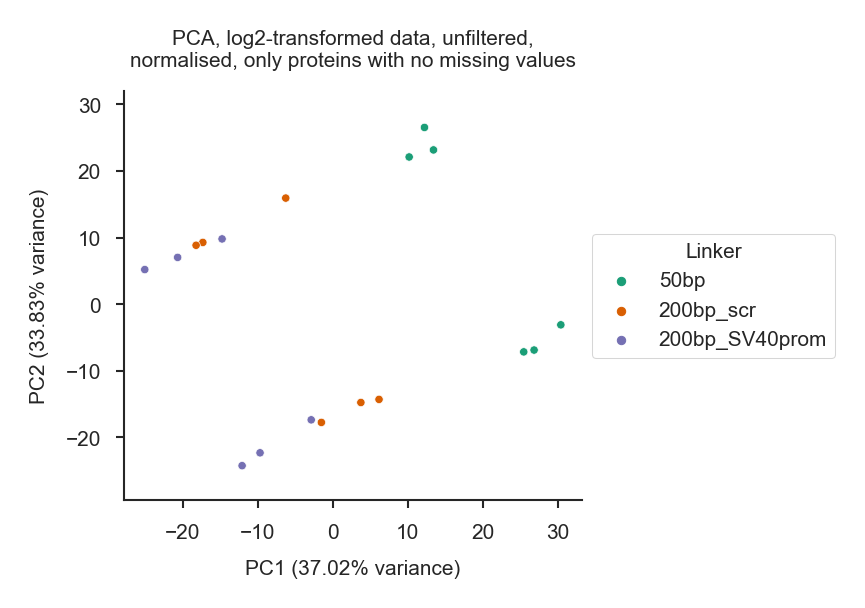

In [52]:
from adjustText import adjust_text
from sklearn.decomposition import PCA

    
plt.figure()
pca = PCA(n_components=2)

# Note that we only look at the rows that are all not null:
projected = pca.fit_transform(data_numeric_log2_normalised.dropna(axis=0).T)

projected = pd.DataFrame(projected, index=data_numeric_log2_normalised.columns, columns=['PC1', 'PC2'])
explained_variance = pd.Series(pca.explained_variance_ratio_, index=projected.columns)

ax = plt.gca()

sns.scatterplot(x='PC1', y='PC2', hue='Linker', data=projected.join(headers_full))

texts = []
#     for ix, row in projected.iterrows():
#         texts.append(ax.text(row['PC1'], row['PC2'], ix, ha='center', va='center'))

xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Increasing ylim helps place the H3K4me3 labels
ax.set_ylim(ylim[0]*1.1, ylim[1] * 1.1)

adjust_text(texts, projected['PC1'].values, projected['PC2'].values, arrowprops=dict(arrowstyle='-'))

ax.set_xlabel("PC1 ({:.2%} variance)".format(explained_variance.loc['PC1']))
ax.set_ylabel("PC2 ({:.2%} variance)".format(explained_variance.loc['PC2']))
ax.grid(False)
ax.set_title("PCA, log2-transformed data, unfiltered,\nnormalised, only proteins with no missing values")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Linker')


_fname = OUTPUT_DIRECTORY / f'02-normalisation-PCA-post-normalisation.Linker.{DATASET}.pdf'
_caption = f"""
Principal Component embedding of log2-transformed, normalised, and unfiltered dataset ({DATASET}), including only the rows which have no missing values.
The principal component 1 (PC1) is plotted on the X axis, while the PC2 is plotted on the Y. 
The explained variance ratio is highlighted in parentheses.
"""
plt.savefig(_fname, bbox_inches='tight', dpi=DPI)
with open(str(_fname) + '.caption.md', 'w') as f:
    f.write(_caption)
    print(_caption)

In [53]:
# Clean up memory a bit
plt.close('all')

## Reference-normalised data

For some visualisations it will also be beneficial to have data normalised to the reference experiment as well.

The reference experiment will be:

In [54]:
headers_full

Experiment          Linker  \
Experiment_Linker_Replicate                                             
Promoter_PTMs_50bp_repl1                Promoter_PTMs            50bp   
Promoter_PTMs_200bp_scr_repl1           Promoter_PTMs       200bp_scr   
Promoter_PTMs_200bp_SV40prom_repl1      Promoter_PTMs  200bp_SV40prom   
unmodH3_unmodH4_50bp_repl1            unmodH3_unmodH4            50bp   
unmodH3_unmodH4_200bp_scr_repl1       unmodH3_unmodH4       200bp_scr   
unmodH3_unmodH4_200bp_SV40prom_repl1  unmodH3_unmodH4  200bp_SV40prom   
Promoter_PTMs_50bp_repl2                Promoter_PTMs            50bp   
Promoter_PTMs_200bp_scr_repl2           Promoter_PTMs       200bp_scr   
Promoter_PTMs_200bp_SV40prom_repl2      Promoter_PTMs  200bp_SV40prom   
unmodH3_unmodH4_50bp_repl2            unmodH3_unmodH4            50bp   
unmodH3_unmodH4_200bp_scr_repl2       unmodH3_unmodH4       200bp_scr   
unmodH3_unmodH4_200bp_SV40prom_repl2  unmodH3_unmodH4  200bp_SV40prom   
Promoter_PTMs_50bp_repl3                Promoter_PTMs            50bp   
Promoter_PTMs_200bp_scr_repl3           Promoter_PTMs       200bp_scr   
Promoter_PTMs_200bp_SV40prom_repl3      Promoter_PTMs  200bp_SV40prom   
unmodH3_unmodH4_50bp_repl3            unmodH3_unmodH4            50bp   
unmodH3_unmodH4_200bp_scr_repl3       unmodH3_unmodH4       200bp_scr   
unmodH3_unmodH4_200bp_SV40prom_repl3  unmodH3_unmodH4  200bp_SV40prom   

                                     Replicate               Experiment_Linker  
Experiment_Linker_Replicate                                                     
Promoter_PTMs_50bp_repl1                     1              Promoter_PTMs_50bp  
Promoter_PTMs_200bp_scr_repl1                1         Promoter_PTMs_200bp_scr  
Promoter_PTMs_200bp_SV40prom_repl1           1    Promoter_PTMs_200bp_SV40prom  
unmodH3_unmodH4_50bp_repl1                   1            unmodH3_unmodH4_50bp  
unmodH3_unmodH4_200bp_scr_repl1              1       unmodH3_unmodH4_200bp_scr  
unmodH3_unmodH4_200bp_SV40prom_repl1         1  unmodH3_unmodH4_200bp_SV40prom  
Promoter_PTMs_50bp_repl2                     2              Promoter_PTMs_50bp  
Promoter_PTMs_200bp_scr_repl2                2         Promoter_PTMs_200bp_scr  
Promoter_PTMs_200bp_SV40prom_repl2           2    Promoter_PTMs_200bp_SV40prom  
unmodH3_unmodH4_50bp_repl2                   2            unmodH3_unmodH4_50bp  
unmodH3_unmodH4_200bp_scr_repl2              2       unmodH3_unmodH4_200bp_scr  
unmodH3_unmodH4_200bp_SV40prom_repl2         2  unmodH3_unmodH4_200bp_SV40prom  
Promoter_PTMs_50bp_repl3                     3              Promoter_PTMs_50bp  
Promoter_PTMs_200bp_scr_repl3                3         Promoter_PTMs_200bp_scr  
Promoter_PTMs_200bp_SV40prom_repl3           3    Promoter_PTMs_200bp_SV40prom  
unmodH3_unmodH4_50bp_repl3                   3            unmodH3_unmodH4_50bp  
unmodH3_unmodH4_200bp_scr_repl3              3       unmodH3_unmodH4_200bp_scr  
unmodH3_unmodH4_200bp_SV40prom_repl3         3  unmodH3_unmodH4_200bp_SV40prom

In [55]:
REFS = {
    'long-linkers-prom': ('unmodH3_unmodH4', '50bp'),
    'long-linkers-enh': ('H3unmod', '50bp'),
    'short-linkers': ('H3unmod', '50bp'),
}

ref_experiment, ref_linker = REFS[DATASET]
ref_experiment_linker = '_'.join([ref_experiment, ref_linker])

In [56]:
ref_experiment_linker

'unmodH3_unmodH4_50bp'

Particularly we will normalise to the mean of the following experiments:

In [57]:
reference_experiment_names = list(headers_full[headers_full['Experiment_Linker'] == ref_experiment_linker].index)
reference_experiment_names

['unmodH3_unmodH4_50bp_repl1',
 'unmodH3_unmodH4_50bp_repl2',
 'unmodH3_unmodH4_50bp_repl3']

In [58]:
mean_reference_experiments = data_numeric_log2_normalised[reference_experiment_names].mean(axis=1)
mean_reference_experiments

Label
MYH9      31.406897
SPTAN1    29.966362
PRKDC     29.731809
SPTBN1    29.774202
ACTB      34.495103
            ...    
ADD1      22.529504
CCNK      20.299477
DCAF13    19.176176
YTHDF2    26.584758
BAX       22.725114
Length: 1600, dtype: float64

In [59]:
data_numeric_log2_normalised_reference_normalised = data_numeric_log2_normalised.sub(mean_reference_experiments, axis=0)

Sanity check

In [60]:
assert np.isclose(data_numeric_log2_normalised_reference_normalised.iloc[0], data_numeric_log2_normalised.iloc[0] - mean_reference_experiments.iloc[0]).all()

In [61]:
data_numeric_log2_normalised_reference_normalised

Experiment_Linker_Replicate  Promoter_PTMs_50bp_repl1  \
Label                                                   
MYH9                                        -0.240150   
SPTAN1                                      -0.087818   
PRKDC                                        0.616757   
SPTBN1                                       0.562680   
ACTB                                        -0.020285   
...                                               ...   
ADD1                                         1.338451   
CCNK                                         0.156593   
DCAF13                                            NaN   
YTHDF2                                      -0.854604   
BAX                                         -0.243783   

Experiment_Linker_Replicate  Promoter_PTMs_200bp_scr_repl1  \
Label                                                        
MYH9                                             -0.548563   
SPTAN1                                           -0.804162   
PRKDC                                            -0.828211   
SPTBN1                                            0.280282   
ACTB                                             -0.626288   
...                                                    ...   
ADD1                                              0.751329   
CCNK                                             -0.429984   
DCAF13                                            0.720108   
YTHDF2                                           -0.097625   
BAX                                              -2.472685   

Experiment_Linker_Replicate  Promoter_PTMs_200bp_SV40prom_repl1  \
Label                                                             
MYH9                                                  -0.647921   
SPTAN1                                                -0.786647   
PRKDC                                                 -0.774319   
SPTBN1                                                 0.329959   
ACTB                                                  -0.791338   
...                                                         ...   
ADD1                                                   0.136181   
CCNK                                                   0.542533   
DCAF13                                                 0.356571   
YTHDF2                                                -0.323313   
BAX                                                   -1.688246   

Experiment_Linker_Replicate  unmodH3_unmodH4_50bp_repl1  \
Label                                                     
MYH9                                           0.119326   
SPTAN1                                         0.150078   
PRKDC                                          0.300056   
SPTBN1                                         0.309444   
ACTB                                           0.081029   
...                                                 ...   
ADD1                                          -0.911970   
CCNK                                          -0.684511   
DCAF13                                        -0.095298   
YTHDF2                                        -0.384240   
BAX                                           -0.143672   

Experiment_Linker_Replicate  unmodH3_unmodH4_200bp_scr_repl1  \
Label                                                          
MYH9                                               -0.396477   
SPTAN1                                             -0.527050   
PRKDC                                              -0.293943   
SPTBN1                                             -0.173816   
ACTB                                               -0.490354   
...                                                      ...   
ADD1                                                0.204401   
CCNK                                               -0.377534   
DCAF13                                              0.500886   
YTHDF2                                              0.200965   
BAX                                        

# Filtering

It is counterproductive to throw all of the data into the model. 

Some datasets are clear outliers in our experimental set. We will not consider them:

In [62]:
COLUMNS_TO_DROP = {
    'short-linkers': {'H3K27me3_35bp__2'},
    'long-linkers-enh': {},
    'long-linkers-prom': {},
}

In [63]:
_blacklist = COLUMNS_TO_DROP[DATASET]

print("Dropping these columns: {}".format(_blacklist))
data_to_model_pre = data_numeric_log2_normalised[[c for c in data_numeric_log2_normalised.columns if c not in _blacklist]]
headers_pre = headers_full.loc[[ix for ix in headers_full.index if ix not in _blacklist]]
data_to_model_pre.head()

Dropping these columns: {}


Experiment_Linker_Replicate  Promoter_PTMs_50bp_repl1  \
Label                                                   
MYH9                                        31.166748   
SPTAN1                                      29.878543   
PRKDC                                       30.348566   
SPTBN1                                      30.336882   
ACTB                                        34.474818   

Experiment_Linker_Replicate  Promoter_PTMs_200bp_scr_repl1  \
Label                                                        
MYH9                                             30.858335   
SPTAN1                                           29.162200   
PRKDC                                            28.903597   
SPTBN1                                           30.054484   
ACTB                                             33.868815   

Experiment_Linker_Replicate  Promoter_PTMs_200bp_SV40prom_repl1  \
Label                                                             
MYH9                                                  30.758976   
SPTAN1                                                29.179715   
PRKDC                                                 28.957490   
SPTBN1                                                30.104161   
ACTB                                                  33.703765   

Experiment_Linker_Replicate  unmodH3_unmodH4_50bp_repl1  \
Label                                                     
MYH9                                          31.526223   
SPTAN1                                        30.116440   
PRKDC                                         30.031864   
SPTBN1                                        30.083646   
ACTB                                          34.576133   

Experiment_Linker_Replicate  unmodH3_unmodH4_200bp_scr_repl1  \
Label                                                          
MYH9                                               31.010420   
SPTAN1                                             29.439311   
PRKDC                                              29.437866   
SPTBN1                                             29.600386   
ACTB                                               34.004750   

Experiment_Linker_Replicate  unmodH3_unmodH4_200bp_SV40prom_repl1  \
Label                                                               
MYH9                                                    30.819292   
SPTAN1                                                  29.368745   
PRKDC                                                   29.094567   
SPTBN1                                                  28.860387   
ACTB                                                    33.957784   

Experiment_Linker_Replicate  Promoter_PTMs_50bp_repl2  \
Label                                                   
MYH9                                        31.164662   
SPTAN1                                      29.635929   
PRKDC                                       29.037081   
SPTBN1                                      30.269337   
ACTB                                        34.116724   

Experiment_Linker_Replicate  Promoter_PTMs_200bp_scr_repl2  \
Label                                                        
MYH9                                             30.769239   
SPTAN1                                           29.050939   
PRKDC                                            28.526610   
SPTBN1                                           30.041392   
ACTB                                             33.657320   

Experiment_Linker_Replicate  Promoter_PTMs_200bp_SV40prom_repl2  \
Label                                                             
MYH9                                                  30.775204   
SPTAN1                                                29.076512   
PRKDC                                                 28.628328   
SPTBN1                                                30.015499   
ACTB                                                  33.580542   

Experiment_Linker_Replicate  unmodH3_unmodH

In [64]:
headers_pre

Experiment          Linker  \
Experiment_Linker_Replicate                                             
Promoter_PTMs_50bp_repl1                Promoter_PTMs            50bp   
Promoter_PTMs_200bp_scr_repl1           Promoter_PTMs       200bp_scr   
Promoter_PTMs_200bp_SV40prom_repl1      Promoter_PTMs  200bp_SV40prom   
unmodH3_unmodH4_50bp_repl1            unmodH3_unmodH4            50bp   
unmodH3_unmodH4_200bp_scr_repl1       unmodH3_unmodH4       200bp_scr   
unmodH3_unmodH4_200bp_SV40prom_repl1  unmodH3_unmodH4  200bp_SV40prom   
Promoter_PTMs_50bp_repl2                Promoter_PTMs            50bp   
Promoter_PTMs_200bp_scr_repl2           Promoter_PTMs       200bp_scr   
Promoter_PTMs_200bp_SV40prom_repl2      Promoter_PTMs  200bp_SV40prom   
unmodH3_unmodH4_50bp_repl2            unmodH3_unmodH4            50bp   
unmodH3_unmodH4_200bp_scr_repl2       unmodH3_unmodH4       200bp_scr   
unmodH3_unmodH4_200bp_SV40prom_repl2  unmodH3_unmodH4  200bp_SV40prom   
Promoter_PTMs_50bp_repl3                Promoter_PTMs            50bp   
Promoter_PTMs_200bp_scr_repl3           Promoter_PTMs       200bp_scr   
Promoter_PTMs_200bp_SV40prom_repl3      Promoter_PTMs  200bp_SV40prom   
unmodH3_unmodH4_50bp_repl3            unmodH3_unmodH4            50bp   
unmodH3_unmodH4_200bp_scr_repl3       unmodH3_unmodH4       200bp_scr   
unmodH3_unmodH4_200bp_SV40prom_repl3  unmodH3_unmodH4  200bp_SV40prom   

                                     Replicate               Experiment_Linker  
Experiment_Linker_Replicate                                                     
Promoter_PTMs_50bp_repl1                     1              Promoter_PTMs_50bp  
Promoter_PTMs_200bp_scr_repl1                1         Promoter_PTMs_200bp_scr  
Promoter_PTMs_200bp_SV40prom_repl1           1    Promoter_PTMs_200bp_SV40prom  
unmodH3_unmodH4_50bp_repl1                   1            unmodH3_unmodH4_50bp  
unmodH3_unmodH4_200bp_scr_repl1              1       unmodH3_unmodH4_200bp_scr  
unmodH3_unmodH4_200bp_SV40prom_repl1         1  unmodH3_unmodH4_200bp_SV40prom  
Promoter_PTMs_50bp_repl2                     2              Promoter_PTMs_50bp  
Promoter_PTMs_200bp_scr_repl2                2         Promoter_PTMs_200bp_scr  
Promoter_PTMs_200bp_SV40prom_repl2           2    Promoter_PTMs_200bp_SV40prom  
unmodH3_unmodH4_50bp_repl2                   2            unmodH3_unmodH4_50bp  
unmodH3_unmodH4_200bp_scr_repl2              2       unmodH3_unmodH4_200bp_scr  
unmodH3_unmodH4_200bp_SV40prom_repl2         2  unmodH3_unmodH4_200bp_SV40prom  
Promoter_PTMs_50bp_repl3                     3              Promoter_PTMs_50bp  
Promoter_PTMs_200bp_scr_repl3                3         Promoter_PTMs_200bp_scr  
Promoter_PTMs_200bp_SV40prom_repl3           3    Promoter_PTMs_200bp_SV40prom  
unmodH3_unmodH4_50bp_repl3                   3            unmodH3_unmodH4_50bp  
unmodH3_unmodH4_200bp_scr_repl3              3       unmodH3_unmodH4_200bp_scr  
unmodH3_unmodH4_200bp_SV40prom_repl3         3  unmodH3_unmodH4_200bp_SV40prom

For better performance we will also filter out some of the proteins.

Particularly, we will only keep the proteins which have at least MINIMUM_NUMBER_OF_OBSERVED_VALUES_PER_CONDITION in any of the  experimental conditions

In [65]:
MINIMUM_NUMBER_OF_OBSERVED_VALUES_PER_CONDITION

2

First count how many non-null values does each protein have:

In [66]:
# Make a long-format DF with non-null values
_df = (~data_to_model_pre.isnull()).stack()
_df.name = 'is_not_null'

# Join with headers
_df = _df.reset_index().join(headers_pre, on='Experiment_Linker_Replicate')

# Groupby label and experiment and count
number_non_null_per_condition = _df.groupby(['Label', 'Experiment_Linker'])['is_not_null'].sum().unstack(['Experiment_Linker'])


In [67]:
number_non_null_per_condition.mean()

Experiment_Linker
Promoter_PTMs_200bp_SV40prom      2.928750
Promoter_PTMs_200bp_scr           2.916250
Promoter_PTMs_50bp                2.851875
unmodH3_unmodH4_200bp_SV40prom    2.863750
unmodH3_unmodH4_200bp_scr         2.863125
unmodH3_unmodH4_50bp              2.790000
dtype: float64

Now check which labels match our condition:

In [68]:
sufficient_number_of_values = (number_non_null_per_condition >= MINIMUM_NUMBER_OF_OBSERVED_VALUES_PER_CONDITION).any(axis=1)


We will throw away all of the proteins which have the value set to False, in hte series above. There are this many of them:

In [69]:
sufficient_number_of_values.value_counts()

True     1595
False       5
dtype: int64

In order to stay civilised we will create a new series called "Comment" and mark the reason of filtering out in there:

In [70]:
data_comment = pd.Series(None, index=data_numeric_log2_normalised.index, name='Comment', dtype=str)
data_comment.loc[~sufficient_number_of_values] = "Insufficient number of non-null values"

In [71]:
data_comment.value_counts()

Insufficient number of non-null values    5
Name: Comment, dtype: int64

# Modelling
Now we can move to modelling

### The inputs

We will model the only the normalised data which has a sufficient number of values:

In [72]:
data_to_model = data_to_model_pre.loc[sufficient_number_of_values]
headers = headers_pre
data_to_model

Experiment_Linker_Replicate  Promoter_PTMs_50bp_repl1  \
Label                                                   
MYH9                                        31.166748   
SPTAN1                                      29.878543   
PRKDC                                       30.348566   
SPTBN1                                      30.336882   
ACTB                                        34.474818   
...                                               ...   
ADD1                                        23.867955   
CCNK                                        20.456071   
DCAF13                                            NaN   
YTHDF2                                      25.730154   
BAX                                         22.481332   

Experiment_Linker_Replicate  Promoter_PTMs_200bp_scr_repl1  \
Label                                                        
MYH9                                             30.858335   
SPTAN1                                           29.162200   
PRKDC                                            28.903597   
SPTBN1                                           30.054484   
ACTB                                             33.868815   
...                                                    ...   
ADD1                                             23.280832   
CCNK                                             19.869493   
DCAF13                                           19.896284   
YTHDF2                                           26.487132   
BAX                                              20.252429   

Experiment_Linker_Replicate  Promoter_PTMs_200bp_SV40prom_repl1  \
Label                                                             
MYH9                                                  30.758976   
SPTAN1                                                29.179715   
PRKDC                                                 28.957490   
SPTBN1                                                30.104161   
ACTB                                                  33.703765   
...                                                         ...   
ADD1                                                  22.665685   
CCNK                                                  20.842011   
DCAF13                                                19.532747   
YTHDF2                                                26.261445   
BAX                                                   21.036868   

Experiment_Linker_Replicate  unmodH3_unmodH4_50bp_repl1  \
Label                                                     
MYH9                                          31.526223   
SPTAN1                                        30.116440   
PRKDC                                         30.031864   
SPTBN1                                        30.083646   
ACTB                                          34.576133   
...                                                 ...   
ADD1                                          21.617533   
CCNK                                          19.614966   
DCAF13                                        19.080878   
YTHDF2                                        26.200518   
BAX                                           22.581442   

Experiment_Linker_Replicate  unmodH3_unmodH4_200bp_scr_repl1  \
Label                                                          
MYH9                                               31.010420   
SPTAN1                                             29.439311   
PRKDC                                              29.437866   
SPTBN1                                             29.600386   
ACTB                                               34.004750   
...                                                      ...   
ADD1                                               22.733905   
CCNK                                               19.921943   
DCAF13                                             19.677062   
YTHDF2                                             26.785723   
BAX                                        


Distribution of missing values in the log2-transformed, normalised, and filtered data which will be used for modelling. 
The heatmap above displays all  929 proteins remaining in the data after filtering in rows, and all experiments in columns. 
Dark values indicate the presence of a value, while white space indicates the absence of one. 
The sparkline on the right hand side counts the number of values per protein, which ranges from zero to 12 in this dataset.



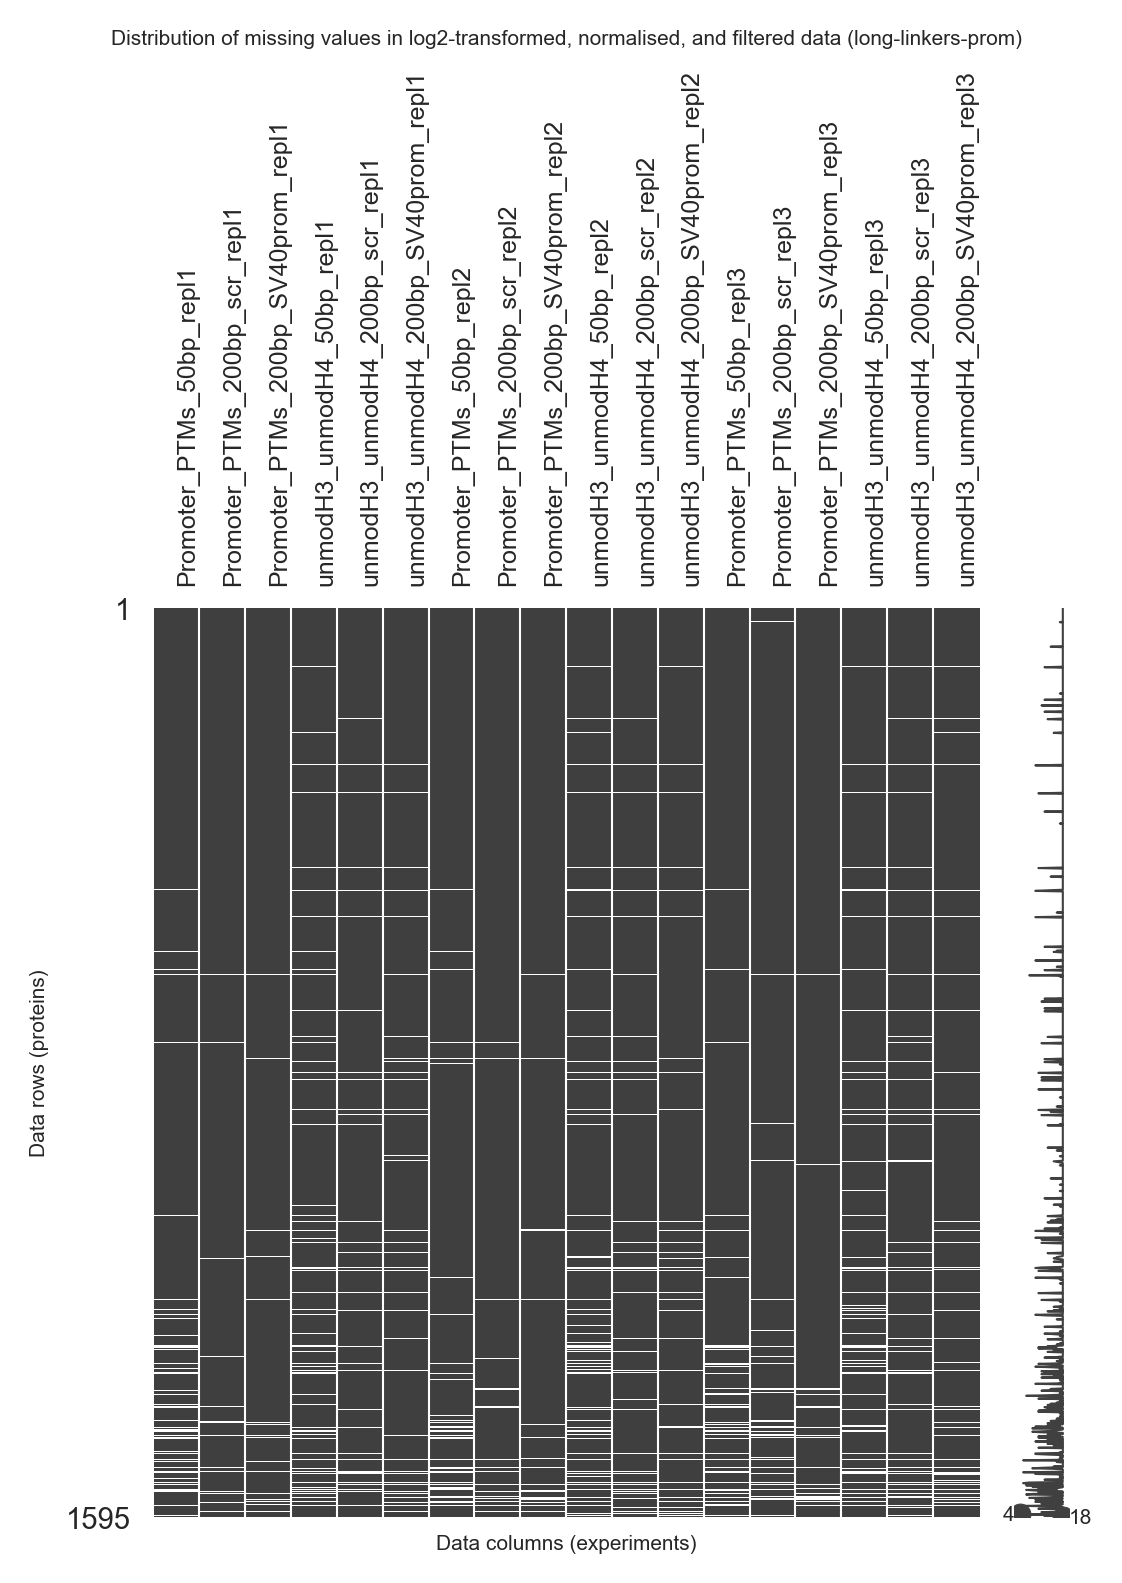

In [73]:
import missingno as msgno
msgno.matrix(data_to_model, figsize=(20*FIVE_MM_IN_INCH, 20*FIVE_MM_IN_INCH), fontsize=6)

plt.title(f"Distribution of missing values in log2-transformed, normalised, and filtered data ({DATASET})")
plt.xlabel("Data columns (experiments)")
plt.ylabel("Data rows (proteins)")
plt.xticks(rotation=90)

_fname = OUTPUT_DIRECTORY / f'03-modelling-log2-transformed-normalised-filtered-missing-values.{DATASET}.png'
_caption = """
Distribution of missing values in the log2-transformed, normalised, and filtered data which will be used for modelling. 
The heatmap above displays all  929 proteins remaining in the data after filtering in rows, and all experiments in columns. 
Dark values indicate the presence of a value, while white space indicates the absence of one. 
The sparkline on the right hand side counts the number of values per protein, which ranges from zero to 12 in this dataset.
"""
plt.savefig(_fname, bbox_inches='tight', dpi=DPI)
with open(str(_fname) + '.caption.md', 'w') as f:
    f.write(_caption)
    print(_caption)

The special cases here are the proteins which have all zero values in some of the conditions:

In [74]:
all_zero_in_some_condition = (number_non_null_per_condition == 0).any(axis=1)
all_zero_in_some_condition = all_zero_in_some_condition.loc[data_to_model.index]
all_zero_in_some_condition.value_counts()

False    1496
True       99
dtype: int64

These proteins are special cases. To visualise them better let's establish a consistent sort order which is based on which condition is missing

In [75]:
all_zero_in_some_condition_sort_order = number_non_null_per_condition.loc[
    all_zero_in_some_condition[all_zero_in_some_condition].index
].sort_values(by=list(number_non_null_per_condition.columns)).index



Let's plot these special cases


Distribution of missing values in the log2-transformed, normalised, and filtered data of proteins that correspond to "special cases" in the modeling as they have all zero values in at least one of the conditions.
The heatmap above displays all of such proteins, sorted by their missing value pattern. 
Dark values indicate the presence of a value, while white space indicates the absence of one. 
The sparkline on the right hand side counts the number of values per protein, which ranges from zero to 12 in this dataset.



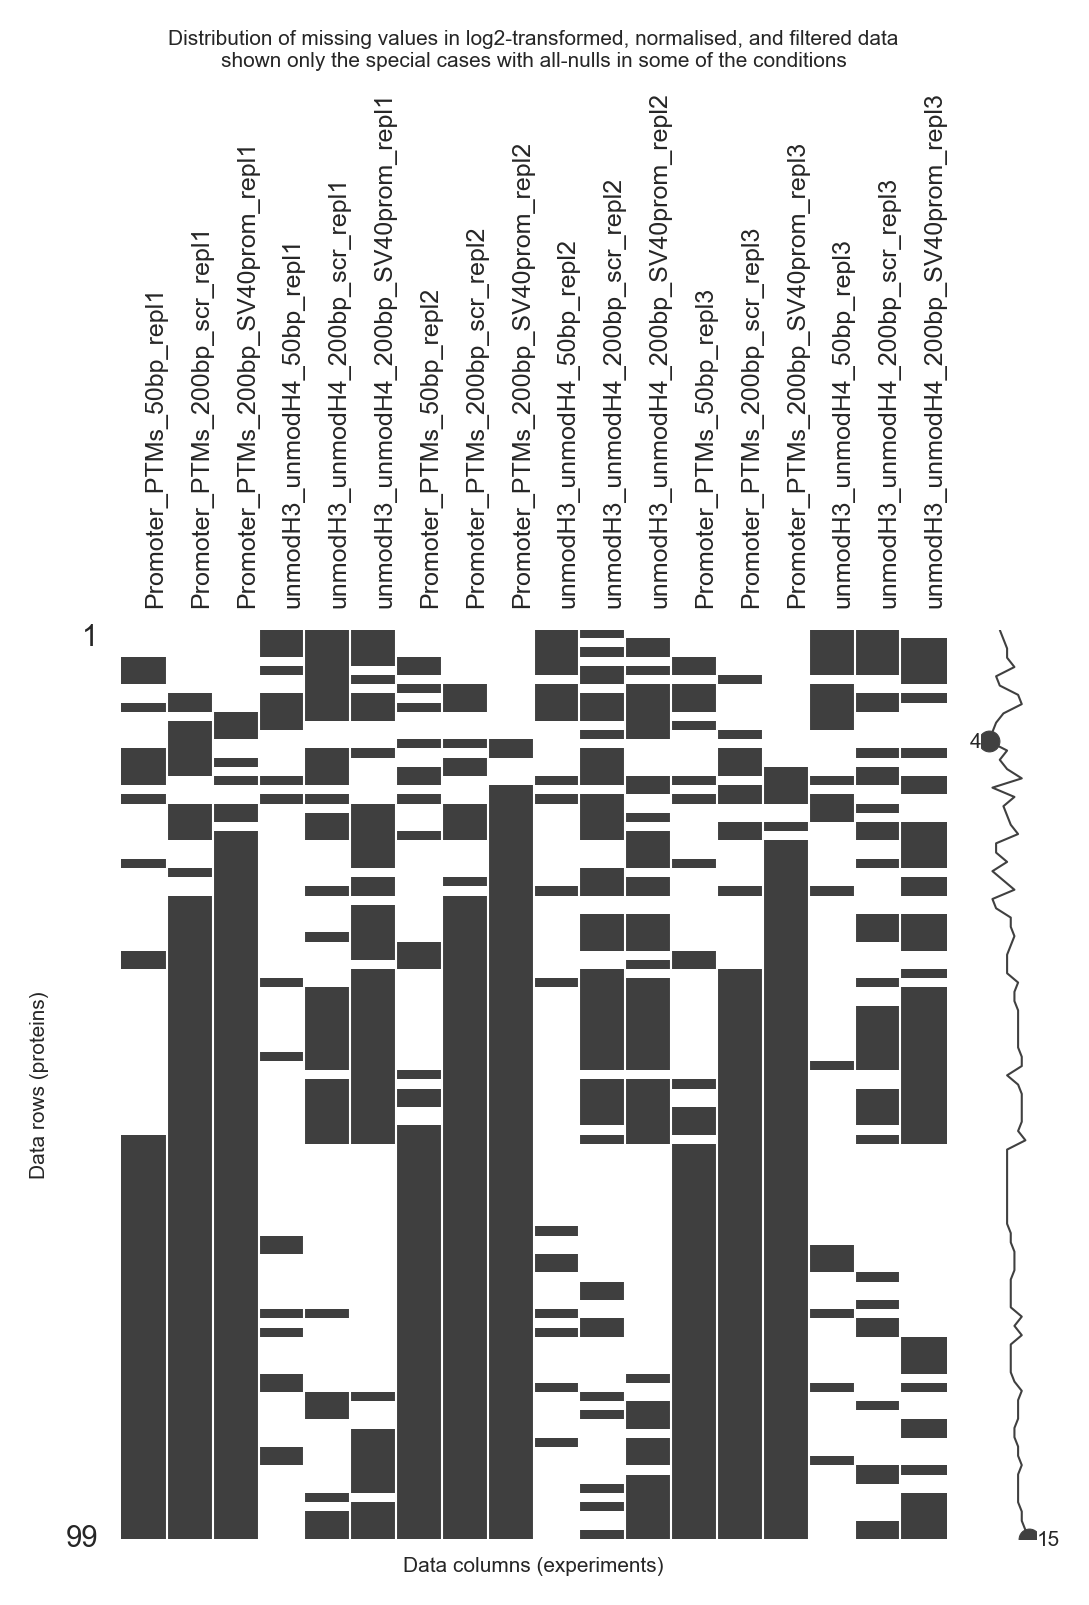

In [76]:
import missingno as msgno
msgno.matrix(
    data_to_model.loc[all_zero_in_some_condition_sort_order], figsize=(20*FIVE_MM_IN_INCH, 20*FIVE_MM_IN_INCH), fontsize=6)

plt.title("Distribution of missing values in log2-transformed, normalised, and filtered data\nshown only the special cases with all-nulls in some of the conditions")
plt.xlabel("Data columns (experiments)")
plt.ylabel("Data rows (proteins)")
plt.xticks(rotation=90)

# For some reason this plot does not rasterize well..
_fname = OUTPUT_DIRECTORY / f'03-modelling-log2-transformed-normalised-filtered-missing-values-all_zero_in_some_condition.{DATASET}.png'
_caption = """
Distribution of missing values in the log2-transformed, normalised, and filtered data of proteins that correspond to "special cases" in the modeling as they have all zero values in at least one of the conditions.
The heatmap above displays all of such proteins, sorted by their missing value pattern. 
Dark values indicate the presence of a value, while white space indicates the absence of one. 
The sparkline on the right hand side counts the number of values per protein, which ranges from zero to 12 in this dataset.
"""
plt.savefig(_fname, bbox_inches='tight', dpi=DPI)
with open(str(_fname) + '.caption.md', 'w') as f:
    f.write(_caption)
    print(_caption)

We can also get a few representative special cases of proteins from that list

In [77]:
import numpy as np

In [78]:
REPRESENTATIVE_NULLS = np.random.RandomState(42).choice(all_zero_in_some_condition_sort_order, 5)

/usr/local/Caskroom/miniconda/base/envs/marcs-variable-linker-pds/lib/python3.10/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)



Distribution of non-null values of log2-transformed, normalised, and filtered dataset. 
The rows facet the four experiment types, while the columns split the data per replicate.
The green distribution plot shows the histogram of observed log2 values in the data.
The black curve shows the corresponding normal distribution fit to the data, whose parameters are written in the top-right corner.
The black vertical line indicates the mean ($\mu$) estimate.



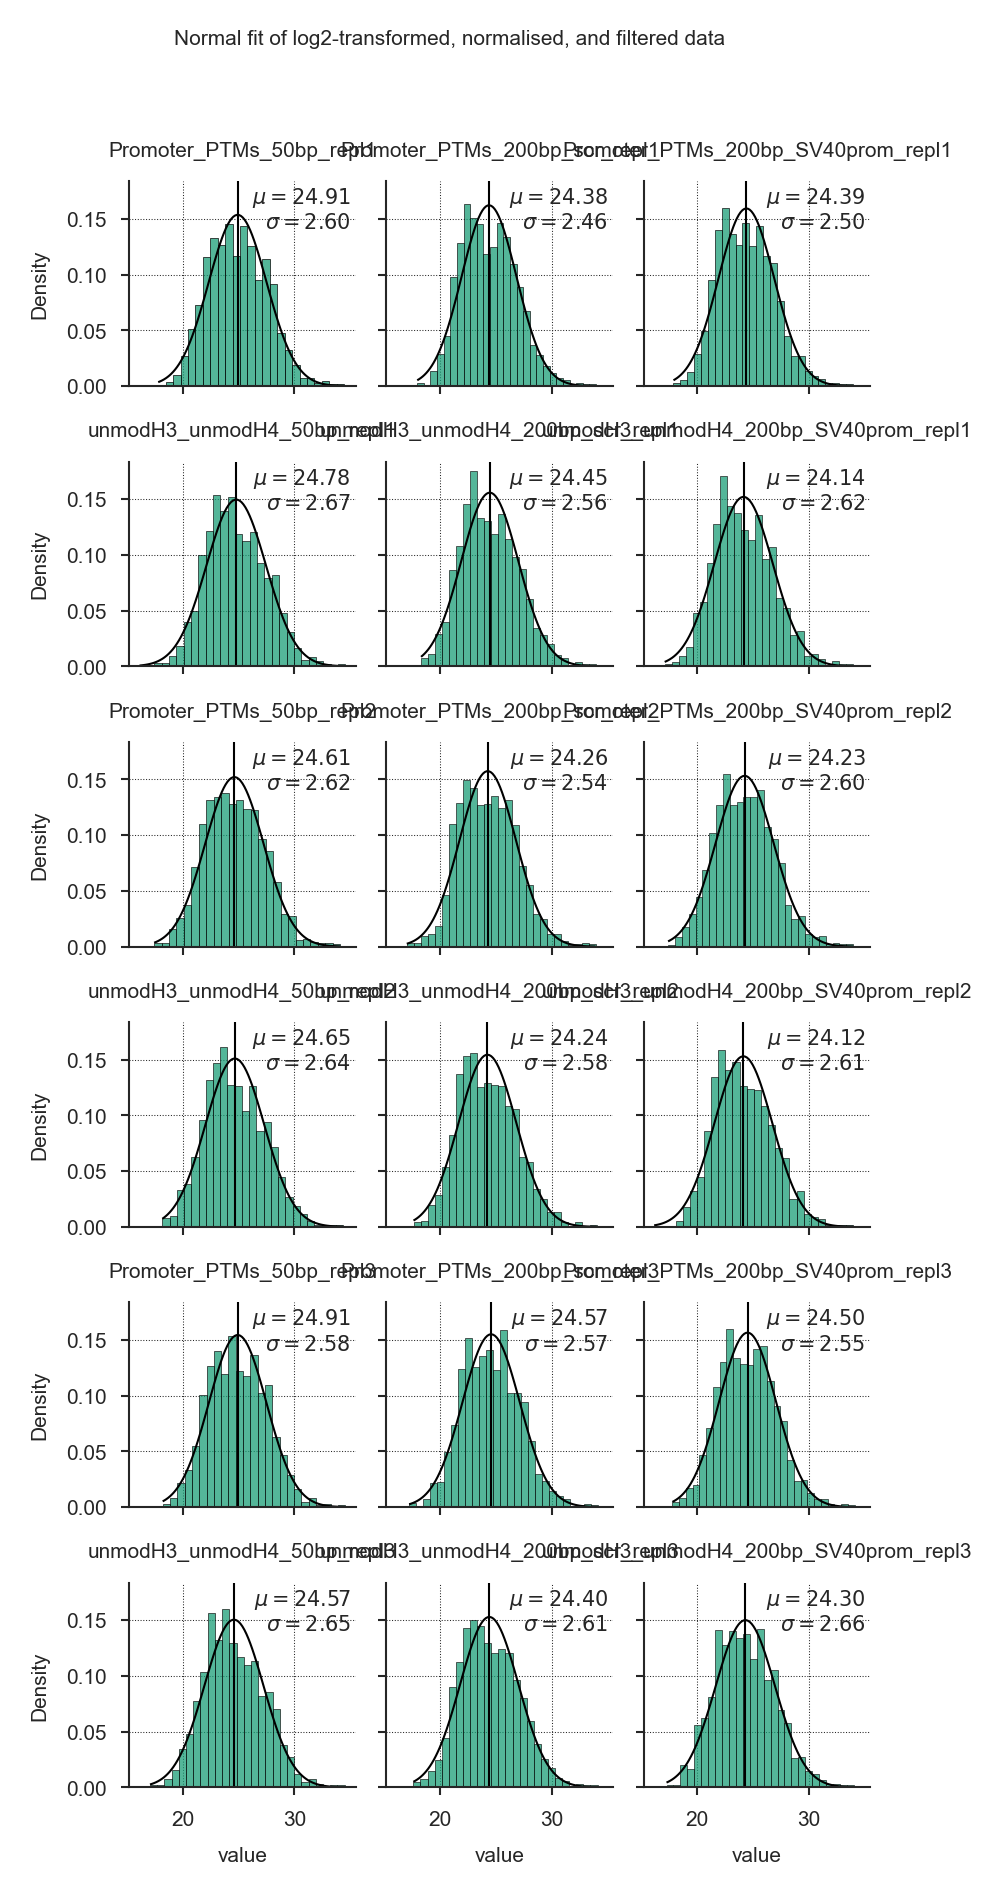

In [79]:
# Convert data to long format
_df = data_to_model.copy()
_df = _df.stack(_df.columns.names)
_df.name = 'value'
_df = _df.reset_index()

# Plot the histograms and normal distribution fits
fgrid = sns.FacetGrid(col='Experiment_Linker_Replicate', col_wrap=3, col_order=data_to_model.columns, data=_df, size=FIVE_MM_IN_INCH*5)
fgrid.map(sns.histplot, 'value', stat='density')
fgrid.map(_plot_norm_fit, 'value')
fgrid.set_titles('{col_name}')

plt.suptitle("Normal fit of log2-transformed, normalised, and filtered data", y=1.05)

_fname = OUTPUT_DIRECTORY / '03-modelling-log2-transformed-normalised-filtered-normal-fit.pdf'
_caption = """
Distribution of non-null values of log2-transformed, normalised, and filtered dataset. 
The rows facet the four experiment types, while the columns split the data per replicate.
The green distribution plot shows the histogram of observed log2 values in the data.
The black curve shows the corresponding normal distribution fit to the data, whose parameters are written in the top-right corner.
The black vertical line indicates the mean ($\mu$) estimate.
"""
plt.savefig(_fname, bbox_inches='tight', dpi=DPI)
with open(str(_fname) + '.caption.md', 'w') as f:
    f.write(_caption)
    print(_caption)

### Design matrix

For modeling we will use limma and encode the data as a "means" model.

We first need to load the limma into rpy2 environment:

In [80]:
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri, numpy2ri

%load_ext rpy2.ipython

Time to load data into R, we will use limma for most tastks:

In [81]:
%%R

library("limma")
packageVersion("limma")

[1]

 ‘3.50.1’

Now we load the header data and make sure that it's columns are interpreted as factors correctly:

In [82]:
assert headers.index.equals(data_to_model.columns), "Make sure that headers_to_model index matches data_to_model columns!"

In [83]:
headers

Experiment          Linker  \
Experiment_Linker_Replicate                                             
Promoter_PTMs_50bp_repl1                Promoter_PTMs            50bp   
Promoter_PTMs_200bp_scr_repl1           Promoter_PTMs       200bp_scr   
Promoter_PTMs_200bp_SV40prom_repl1      Promoter_PTMs  200bp_SV40prom   
unmodH3_unmodH4_50bp_repl1            unmodH3_unmodH4            50bp   
unmodH3_unmodH4_200bp_scr_repl1       unmodH3_unmodH4       200bp_scr   
unmodH3_unmodH4_200bp_SV40prom_repl1  unmodH3_unmodH4  200bp_SV40prom   
Promoter_PTMs_50bp_repl2                Promoter_PTMs            50bp   
Promoter_PTMs_200bp_scr_repl2           Promoter_PTMs       200bp_scr   
Promoter_PTMs_200bp_SV40prom_repl2      Promoter_PTMs  200bp_SV40prom   
unmodH3_unmodH4_50bp_repl2            unmodH3_unmodH4            50bp   
unmodH3_unmodH4_200bp_scr_repl2       unmodH3_unmodH4       200bp_scr   
unmodH3_unmodH4_200bp_SV40prom_repl2  unmodH3_unmodH4  200bp_SV40prom   
Promoter_PTMs_50bp_repl3                Promoter_PTMs            50bp   
Promoter_PTMs_200bp_scr_repl3           Promoter_PTMs       200bp_scr   
Promoter_PTMs_200bp_SV40prom_repl3      Promoter_PTMs  200bp_SV40prom   
unmodH3_unmodH4_50bp_repl3            unmodH3_unmodH4            50bp   
unmodH3_unmodH4_200bp_scr_repl3       unmodH3_unmodH4       200bp_scr   
unmodH3_unmodH4_200bp_SV40prom_repl3  unmodH3_unmodH4  200bp_SV40prom   

                                     Replicate               Experiment_Linker  
Experiment_Linker_Replicate                                                     
Promoter_PTMs_50bp_repl1                     1              Promoter_PTMs_50bp  
Promoter_PTMs_200bp_scr_repl1                1         Promoter_PTMs_200bp_scr  
Promoter_PTMs_200bp_SV40prom_repl1           1    Promoter_PTMs_200bp_SV40prom  
unmodH3_unmodH4_50bp_repl1                   1            unmodH3_unmodH4_50bp  
unmodH3_unmodH4_200bp_scr_repl1              1       unmodH3_unmodH4_200bp_scr  
unmodH3_unmodH4_200bp_SV40prom_repl1         1  unmodH3_unmodH4_200bp_SV40prom  
Promoter_PTMs_50bp_repl2                     2              Promoter_PTMs_50bp  
Promoter_PTMs_200bp_scr_repl2                2         Promoter_PTMs_200bp_scr  
Promoter_PTMs_200bp_SV40prom_repl2           2    Promoter_PTMs_200bp_SV40prom  
unmodH3_unmodH4_50bp_repl2                   2            unmodH3_unmodH4_50bp  
unmodH3_unmodH4_200bp_scr_repl2              2       unmodH3_unmodH4_200bp_scr  
unmodH3_unmodH4_200bp_SV40prom_repl2         2  unmodH3_unmodH4_200bp_SV40prom  
Promoter_PTMs_50bp_repl3                     3              Promoter_PTMs_50bp  
Promoter_PTMs_200bp_scr_repl3                3         Promoter_PTMs_200bp_scr  
Promoter_PTMs_200bp_SV40prom_repl3           3    Promoter_PTMs_200bp_SV40prom  
unmodH3_unmodH4_50bp_repl3                   3            unmodH3_unmodH4_50bp  
unmodH3_unmodH4_200bp_scr_repl3              3       unmodH3_unmodH4_200bp_scr  
unmodH3_unmodH4_200bp_SV40prom_repl3         3  unmodH3_unmodH4_200bp_SV40prom

In [84]:
%%R -i headers -i DATASET -i ref_experiment -i ref_linker -i ref_experiment_linker

headers$Experiment_Linker <- as.factor(headers$Experiment_Linker)

headers$Experiment_linker <- relevel(headers$Experiment_Linker, ref=ref_experiment_linker)

headers$Experiment <- as.factor(headers$Experiment)
headers$Experiment <- relevel(headers$Experiment, ref=ref_experiment)

headers$Linker <- as.factor(headers$Linker)
headers$Linker <- relevel(headers$Linker, ref=ref_linker)

headers$Replicate <- as.factor(headers$Replicate)
headers

      Experiment

         Linker

 Replicate


Promoter_PTMs_50bp_repl1            

   Promoter_PTMs

           50bp

         1


Promoter_PTMs_200bp_scr_repl1       

   Promoter_PTMs

      200bp_scr

         1


Promoter_PTMs_200bp_SV40prom_repl1  

   Promoter_PTMs

 200bp_SV40prom

         1


unmodH3_unmodH4_50bp_repl1          

 unmodH3_unmodH4

           50bp

         1


unmodH3_unmodH4_200bp_scr_repl1     

 unmodH3_unmodH4

      200bp_scr

         1


unmodH3_unmodH4_200bp_SV40prom_repl1

 unmodH3_unmodH4

 200bp_SV40prom

         1


Promoter_PTMs_50bp_repl2            

   Promoter_PTMs

           50bp

         2


Promoter_PTMs_200bp_scr_repl2       

   Promoter_PTMs

      200bp_scr

         2


Promoter_PTMs_200bp_SV40prom_repl2  

   Promoter_PTMs

 200bp_SV40prom

         2


unmodH3_unmodH4_50bp_repl2          

 unmodH3_unmodH4

           50bp

         2


unmodH3_unmodH4_200bp_scr_repl2     

 unmodH3_unmodH4

      200bp_scr

         2


unmodH3_unmodH4_200bp_SV40prom_repl2

 unmodH3_unmodH4

 200bp_SV40prom

         2


Promoter_PTMs_50bp_repl3            

   Promoter_PTMs

           50bp

         3


Promoter_PTMs_200bp_scr_repl3       

   Promoter_PTMs

      200bp_scr

         3


Promoter_PTMs_200bp_SV40prom_repl3  

   Promoter_PTMs

 200bp_SV40prom

         3


unmodH3_unmodH4_50bp_repl3          

 unmodH3_unmodH4

           50bp

         3


unmodH3_unmodH4_200bp_scr_repl3     

 unmodH3_unmodH4

      200bp_scr

         3


unmodH3_unmodH4_200bp_SV40prom_repl3

 unmodH3_unmodH4

 200bp_SV40prom

         3

              Experiment_Linker


Promoter_PTMs_50bp_repl1            

             Promoter_PTMs_50bp


Promoter_PTMs_200bp_scr_repl1       

        Promoter_PTMs_200bp_scr


Promoter_PTMs_200bp_SV40prom_repl1  

   Promoter_PTMs_200bp_SV40prom


unmodH3_unmodH4_50bp_repl1          

           unmodH3_unmodH4_50bp


unmodH3_unmodH4_200bp_scr_repl1     

      unmodH3_unmodH4_200bp_scr


unmodH3_unmodH4_200bp_SV40prom_repl1

 unmodH3_unmodH4_200bp_SV40prom


Promoter_PTMs_50bp_repl2            

             Promoter_PTMs_50bp


Promoter_PTMs_200bp_scr_repl2       

        Promoter_PTMs_200bp_scr


Promoter_PTMs_200bp_SV40prom_repl2  

   Promoter_PTMs_200bp_SV40prom


unmodH3_unmodH4_50bp_repl2          

           unmodH3_unmodH4_50bp


unmodH3_unmodH4_200bp_scr_repl2     

      unmodH3_unmodH4_200bp_scr


unmodH3_unmodH4_200bp_SV40prom_repl2

 unmodH3_unmodH4_200bp_SV40prom


Promoter_PTMs_50bp_repl3            

             Promoter_PTMs_50bp


Promoter_PTMs_200bp_scr_repl3       

        Promoter_PTMs_200bp_scr


Promoter_PTMs_200bp_SV40prom_repl3  

   Promoter_PTMs_200bp_SV40prom


unmodH3_unmodH4_50bp_repl3          

           unmodH3_unmodH4_50bp


unmodH3_unmodH4_200bp_scr_repl3     

      unmodH3_unmodH4_200bp_scr


unmodH3_unmodH4_200bp_SV40prom_repl3

 unmodH3_unmodH4_200bp_SV40prom

              Experiment_linker


Promoter_PTMs_50bp_repl1            

             Promoter_PTMs_50bp


Promoter_PTMs_200bp_scr_repl1       

        Promoter_PTMs_200bp_scr


Promoter_PTMs_200bp_SV40prom_repl1  

   Promoter_PTMs_200bp_SV40prom


unmodH3_unmodH4_50bp_repl1          

           unmodH3_unmodH4_50bp


unmodH3_unmodH4_200bp_scr_repl1     

      unmodH3_unmodH4_200bp_scr


unmodH3_unmodH4_200bp_SV40prom_repl1

 unmodH3_unmodH4_200bp_SV40prom


Promoter_PTMs_50bp_repl2            

             Promoter_PTMs_50bp


Promoter_PTMs_200bp_scr_repl2       

        Promoter_PTMs_200bp_scr


Promoter_PTMs_200bp_SV40prom_repl2  

   Promoter_PTMs_200bp_SV40prom


unmodH3_unmodH4_50bp_repl2          

           unmodH3_unmodH4_50bp


unmodH3_unmodH4_200bp_scr_repl2     

      unmodH3_unmodH4_200bp_scr


unmodH3_unmodH4_200bp_SV40prom_repl2

 unmodH3_unmodH4_200bp_SV40prom


Promoter_PTMs_50bp_repl3            

             Promoter_PTMs_50bp


Promoter_PTMs_200bp_scr_repl3       

        Promoter_PTMs_200bp_scr


Promoter_PTMs_200bp_SV40prom_repl3  

   Promoter_PTMs_200bp_SV40prom


unmodH3_unmodH4_50bp_repl3          

           unmodH3_unmodH4_50bp


unmodH3_unmodH4_200bp_scr_repl3     

      unmodH3_unmodH4_200bp_scr


unmodH3_unmodH4_200bp_SV40prom_repl3

 unmodH3_unmodH4_200bp_SV40prom

To create the design matrix, we will use a Means (no intercept) design

In [85]:
%%R

# Do not use intercept:
design <- model.matrix(~0 + Experiment_Linker, headers)
design

 Experiment_LinkerPromoter_PTMs_200bp_SV40prom


Promoter_PTMs_50bp_repl1            

                                             0


Promoter_PTMs_200bp_scr_repl1       

                                             0


Promoter_PTMs_200bp_SV40prom_repl1  

                                             1


unmodH3_unmodH4_50bp_repl1          

                                             0


unmodH3_unmodH4_200bp_scr_repl1     

                                             0


unmodH3_unmodH4_200bp_SV40prom_repl1

                                             0


Promoter_PTMs_50bp_repl2            

                                             0


Promoter_PTMs_200bp_scr_repl2       

                                             0


Promoter_PTMs_200bp_SV40prom_repl2  

                                             1


unmodH3_unmodH4_50bp_repl2          

                                             0


unmodH3_unmodH4_200bp_scr_repl2     

                                             0


unmodH3_unmodH4_200bp_SV40prom_repl2

                                             0


Promoter_PTMs_50bp_repl3            

                                             0


Promoter_PTMs_200bp_scr_repl3       

                                             0


Promoter_PTMs_200bp_SV40prom_repl3  

                                             1


unmodH3_unmodH4_50bp_repl3          

                                             0


unmodH3_unmodH4_200bp_scr_repl3     

                                             0


unmodH3_unmodH4_200bp_SV40prom_repl3

                                             0

 Experiment_LinkerPromoter_PTMs_200bp_scr


Promoter_PTMs_50bp_repl1            

                                        0


Promoter_PTMs_200bp_scr_repl1       

                                        1


Promoter_PTMs_200bp_SV40prom_repl1  

                                        0


unmodH3_unmodH4_50bp_repl1          

                                        0


unmodH3_unmodH4_200bp_scr_repl1     

                                        0


unmodH3_unmodH4_200bp_SV40prom_repl1

                                        0


Promoter_PTMs_50bp_repl2            

                                        0


Promoter_PTMs_200bp_scr_repl2       

                                        1


Promoter_PTMs_200bp_SV40prom_repl2  

                                        0


unmodH3_unmodH4_50bp_repl2          

                                        0


unmodH3_unmodH4_200bp_scr_repl2     

                                        0


unmodH3_unmodH4_200bp_SV40prom_repl2

                                        0


Promoter_PTMs_50bp_repl3            

                                        0


Promoter_PTMs_200bp_scr_repl3       

                                        1


Promoter_PTMs_200bp_SV40prom_repl3  

                                        0


unmodH3_unmodH4_50bp_repl3          

                                        0


unmodH3_unmodH4_200bp_scr_repl3     

                                        0


unmodH3_unmodH4_200bp_SV40prom_repl3

                                        0

 Experiment_LinkerPromoter_PTMs_50bp


Promoter_PTMs_50bp_repl1            

                                   1


Promoter_PTMs_200bp_scr_repl1       

                                   0


Promoter_PTMs_200bp_SV40prom_repl1  

                                   0


unmodH3_unmodH4_50bp_repl1          

                                   0


unmodH3_unmodH4_200bp_scr_repl1     

                                   0


unmodH3_unmodH4_200bp_SV40prom_repl1

                                   0


Promoter_PTMs_50bp_repl2            

                                   1


Promoter_PTMs_200bp_scr_repl2       

                                   0


Promoter_PTMs_200bp_SV40prom_repl2  

                                   0


unmodH3_unmodH4_50bp_repl2          

                                   0


unmodH3_unmodH4_200bp_scr_repl2     

                                   0


unmodH3_unmodH4_200bp_SV40prom_repl2

                                   0


Promoter_PTMs_50bp_repl3            

                                   1


Promoter_PTMs_200bp_scr_repl3       

                                   0


Promoter_PTMs_200bp_SV40prom_repl3  

                                   0


unmodH3_unmodH4_50bp_repl3          

                                   0


unmodH3_unmodH4_200bp_scr_repl3     

                                   0


unmodH3_unmodH4_200bp_SV40prom_repl3

                                   0

 Experiment_LinkerunmodH3_unmodH4_200bp_SV40prom


Promoter_PTMs_50bp_repl1            

                                               0


Promoter_PTMs_200bp_scr_repl1       

                                               0


Promoter_PTMs_200bp_SV40prom_repl1  

                                               0


unmodH3_unmodH4_50bp_repl1          

                                               0


unmodH3_unmodH4_200bp_scr_repl1     

                                               0


unmodH3_unmodH4_200bp_SV40prom_repl1

                                               1


Promoter_PTMs_50bp_repl2            

                                               0


Promoter_PTMs_200bp_scr_repl2       

                                               0


Promoter_PTMs_200bp_SV40prom_repl2  

                                               0


unmodH3_unmodH4_50bp_repl2          

                                               0


unmodH3_unmodH4_200bp_scr_repl2     

                                               0


unmodH3_unmodH4_200bp_SV40prom_repl2

                                               1


Promoter_PTMs_50bp_repl3            

                                               0


Promoter_PTMs_200bp_scr_repl3       

                                               0


Promoter_PTMs_200bp_SV40prom_repl3  

                                               0


unmodH3_unmodH4_50bp_repl3          

                                               0


unmodH3_unmodH4_200bp_scr_repl3     

                                               0


unmodH3_unmodH4_200bp_SV40prom_repl3

                                               1

 Experiment_LinkerunmodH3_unmodH4_200bp_scr


Promoter_PTMs_50bp_repl1            

                                          0


Promoter_PTMs_200bp_scr_repl1       

                                          0


Promoter_PTMs_200bp_SV40prom_repl1  

                                          0


unmodH3_unmodH4_50bp_repl1          

                                          0


unmodH3_unmodH4_200bp_scr_repl1     

                                          1


unmodH3_unmodH4_200bp_SV40prom_repl1

                                          0


Promoter_PTMs_50bp_repl2            

                                          0


Promoter_PTMs_200bp_scr_repl2       

                                          0


Promoter_PTMs_200bp_SV40prom_repl2  

                                          0


unmodH3_unmodH4_50bp_repl2          

                                          0


unmodH3_unmodH4_200bp_scr_repl2     

                                          1


unmodH3_unmodH4_200bp_SV40prom_repl2

                                          0


Promoter_PTMs_50bp_repl3            

                                          0


Promoter_PTMs_200bp_scr_repl3       

                                          0


Promoter_PTMs_200bp_SV40prom_repl3  

                                          0


unmodH3_unmodH4_50bp_repl3          

                                          0


unmodH3_unmodH4_200bp_scr_repl3     

                                          1


unmodH3_unmodH4_200bp_SV40prom_repl3

                                          0

 Experiment_LinkerunmodH3_unmodH4_50bp


Promoter_PTMs_50bp_repl1            

                                     0


Promoter_PTMs_200bp_scr_repl1       

                                     0


Promoter_PTMs_200bp_SV40prom_repl1  

                                     0


unmodH3_unmodH4_50bp_repl1          

                                     1


unmodH3_unmodH4_200bp_scr_repl1     

                                     0


unmodH3_unmodH4_200bp_SV40prom_repl1

                                     0


Promoter_PTMs_50bp_repl2            

                                     0


Promoter_PTMs_200bp_scr_repl2       

                                     0


Promoter_PTMs_200bp_SV40prom_repl2  

                                     0


unmodH3_unmodH4_50bp_repl2          

                                     1


unmodH3_unmodH4_200bp_scr_repl2     

                                     0


unmodH3_unmodH4_200bp_SV40prom_repl2

                                     0


Promoter_PTMs_50bp_repl3            

                                     0


Promoter_PTMs_200bp_scr_repl3       

                                     0


Promoter_PTMs_200bp_SV40prom_repl3  

                                     0


unmodH3_unmodH4_50bp_repl3          

                                     1


unmodH3_unmodH4_200bp_scr_repl3     

                                     0


unmodH3_unmodH4_200bp_SV40prom_repl3

                                     0

attr(,"assign")

[1]

 1

 1

 1

 1

 1

 1

attr(,"contrasts")

attr(,"contrasts")$Experiment_Linker


[1]

 "contr.treatment"

From this design matrix we are primarily interested in these (quite a few!) contrasts

In [86]:
sorted(headers['Experiment_Linker'].unique())

['Promoter_PTMs_200bp_SV40prom',
 'Promoter_PTMs_200bp_scr',
 'Promoter_PTMs_50bp',
 'unmodH3_unmodH4_200bp_SV40prom',
 'unmodH3_unmodH4_200bp_scr',
 'unmodH3_unmodH4_50bp']

In [87]:
%%R -o contrasts_matrix_as_df -i DATASET

if (DATASET == "long-linkers-enh") {
    
    contrasts.matrix <- limma::makeContrasts(

        "modif_H3K27ac_vs_H3unmod_50bp"                = Experiment_LinkerH3K27ac_50bp          - Experiment_LinkerH3unmod_50bp,
        "modif_H3K27ac_vs_H3unmod_200bp_SV40enh"       = Experiment_LinkerH3K27ac_200bp_SV40enh - Experiment_LinkerH3unmod_200bp_SV40enh,
        "modif_H3K27ac_vs_H3unmod_200bp_scr"           = Experiment_LinkerH3K27ac_200bp_scr     - Experiment_LinkerH3unmod_200bp_scr,

        "modif_H3K4me1K27ac_vs_H3unmod_50bp"           = Experiment_LinkerH3K4me1K27ac_50bp          - Experiment_LinkerH3unmod_50bp,
        "modif_H3K4me1K27ac_vs_H3unmod_200bp_SV40enh"  = Experiment_LinkerH3K4me1K27ac_200bp_SV40enh - Experiment_LinkerH3unmod_200bp_SV40enh,
        "modif_H3K4me1K27ac_vs_H3unmod_200bp_scr"      = Experiment_LinkerH3K4me1K27ac_200bp_scr     - Experiment_LinkerH3unmod_200bp_scr,

        "modif_H3K4me1_vs_H3unmod_50bp"                = Experiment_LinkerH3K4me1_50bp          - Experiment_LinkerH3unmod_50bp,
        "modif_H3K4me1_vs_H3unmod_200bp_SV40enh"       = Experiment_LinkerH3K4me1_200bp_SV40enh - Experiment_LinkerH3unmod_200bp_SV40enh,
        "modif_H3K4me1_vs_H3unmod_200bp_scr"           = Experiment_LinkerH3K4me1_200bp_scr     - Experiment_LinkerH3unmod_200bp_scr,
        
        "linker_200bp_scr_vs_50bp_H3K27ac"             = Experiment_LinkerH3K27ac_200bp_scr - Experiment_LinkerH3K27ac_50bp,
        "linker_200bp_scr_vs_50bp_H3K4me1K27ac"        = Experiment_LinkerH3K4me1K27ac_200bp_scr - Experiment_LinkerH3K4me1K27ac_50bp,
        "linker_200bp_scr_vs_50bp_H3K4me1"             = Experiment_LinkerH3K4me1_200bp_scr - Experiment_LinkerH3K4me1_50bp,
        "linker_200bp_scr_vs_50bp_H3unmod"             = Experiment_LinkerH3unmod_200bp_scr - Experiment_LinkerH3unmod_50bp,
        
        "linker_200bp_SV40enh_vs_50bp_H3K27ac"             = Experiment_LinkerH3K27ac_200bp_SV40enh      - Experiment_LinkerH3K27ac_50bp,
        "linker_200bp_SV40enh_vs_50bp_H3K4me1K27ac"        = Experiment_LinkerH3K4me1K27ac_200bp_SV40enh - Experiment_LinkerH3K4me1K27ac_50bp,
        "linker_200bp_SV40enh_vs_50bp_H3K4me1"             = Experiment_LinkerH3K4me1_200bp_SV40enh      - Experiment_LinkerH3K4me1_50bp,
        "linker_200bp_SV40enh_vs_50bp_H3unmod"             = Experiment_LinkerH3unmod_200bp_SV40enh      - Experiment_LinkerH3unmod_50bp,
        
        
        "linker_200bp_SV40enh_vs_200bp_scr_H3K27ac"             = Experiment_LinkerH3K27ac_200bp_SV40enh      - Experiment_LinkerH3K27ac_200bp_scr,
        "linker_200bp_SV40enh_vs_200bp_scr_H3K4me1K27ac"        = Experiment_LinkerH3K4me1K27ac_200bp_SV40enh - Experiment_LinkerH3K4me1K27ac_200bp_scr,
        "linker_200bp_SV40enh_vs_200bp_scr_H3K4me1"             = Experiment_LinkerH3K4me1_200bp_SV40enh      - Experiment_LinkerH3K4me1_200bp_scr,
        "linker_200bp_SV40enh_vs_200bp_scr_H3unmod"             = Experiment_LinkerH3unmod_200bp_SV40enh      - Experiment_LinkerH3unmod_200bp_scr,
        
        levels=design
    )
} else if (DATASET == "long-linkers-prom") {
    
    contrasts.matrix <- limma::makeContrasts(

        "modif_Promoter_PTMs_vs_unmodH3_unmodH4_50bp"                = Experiment_LinkerPromoter_PTMs_50bp           - Experiment_LinkerunmodH3_unmodH4_50bp,
        "modif_Promoter_PTMs_vs_unmodH3_unmodH4_200bp_SV40prom"      = Experiment_LinkerPromoter_PTMs_200bp_SV40prom - Experiment_LinkerunmodH3_unmodH4_200bp_SV40prom,
        "modif_Promoter_PTMs_vs_unmodH3_unmodH4_200bp_scr"           = Experiment_LinkerPromoter_PTMs_200bp_scr      - Experiment_LinkerunmodH3_unmodH4_200bp_scr,
        
        "linker_200bp_scr_vs_50bp_Promoter_PTMs"                     =  Experiment_LinkerPromoter_PTMs_200bp_scr - Experiment_LinkerPromoter_PTMs_50bp,
        "linker_200bp_SV40prom_vs_50bp_Promoter_PTMs"                =  Experiment_LinkerPromoter_PTMs_200bp_SV40prom - Experiment_LinkerPromoter_PTMs_50bp,
        
        "linker_200bp_scr_vs_50bp_unmodH3_unmodH4"                   =  Experiment_LinkerunmodH3_unmodH4_200bp_scr - Experiment_LinkerunmodH3_unmodH4_50bp,
        "linker_200bp_SV40prom_vs_50bp_unmodH3_unmodH4"              =  Experiment_LinkerunmodH3_unmodH4_200bp_SV40prom - Experiment_LinkerunmodH3_unmodH4_50bp,
        
        "linker_200bp_SV40prom_vs_200bp_scr_Promoter_PTMs"           =  Experiment_LinkerPromoter_PTMs_200bp_SV40prom - Experiment_LinkerPromoter_PTMs_200bp_scr,
        "linker_200bp_SV40prom_vs_200bp_scr_unmodH3_unmodH4"         =  Experiment_LinkerunmodH3_unmodH4_200bp_SV40prom - Experiment_LinkerunmodH3_unmodH4_200bp_scr,
       
        levels=design
    )
} else if (DATASET == "short-linkers") {
    contrasts.matrix <- limma::makeContrasts(

        "modif_H3K27me3_vs_H3unmod_35bp"    = Experiment_LinkerH3K27me3_35bp          - Experiment_LinkerH3unmod_35bp,
        "modif_H3K27me3_vs_H3unmod_40bp"    = Experiment_LinkerH3K27me3_40bp          - Experiment_LinkerH3unmod_40bp,
        "modif_H3K27me3_vs_H3unmod_45bp"    = Experiment_LinkerH3K27me3_45bp          - Experiment_LinkerH3unmod_45bp,
        "modif_H3K27me3_vs_H3unmod_50bp"    = Experiment_LinkerH3K27me3_50bp          - Experiment_LinkerH3unmod_50bp,
        "modif_H3K27me3_vs_H3unmod_55bp"    = Experiment_LinkerH3K27me3_55bp          - Experiment_LinkerH3unmod_55bp,
        
        "modif_H3K9me3_vs_H3unmod_35bp"     = Experiment_LinkerH3K9me3_35bp          - Experiment_LinkerH3unmod_35bp,
        "modif_H3K9me3_vs_H3unmod_40bp"     = Experiment_LinkerH3K9me3_40bp          - Experiment_LinkerH3unmod_40bp,
        "modif_H3K9me3_vs_H3unmod_45bp"     = Experiment_LinkerH3K9me3_45bp          - Experiment_LinkerH3unmod_45bp,
        "modif_H3K9me3_vs_H3unmod_50bp"     = Experiment_LinkerH3K9me3_50bp          - Experiment_LinkerH3unmod_50bp,
        "modif_H3K9me3_vs_H3unmod_55bp"     = Experiment_LinkerH3K9me3_55bp          - Experiment_LinkerH3unmod_55bp,
        
        'linker_35bp_vs_50bp_H3K27me3'      =  Experiment_LinkerH3K27me3_35bp - Experiment_LinkerH3K27me3_50bp,
        'linker_40bp_vs_50bp_H3K27me3'      =  Experiment_LinkerH3K27me3_40bp - Experiment_LinkerH3K27me3_50bp,
        'linker_45bp_vs_50bp_H3K27me3'      =  Experiment_LinkerH3K27me3_45bp - Experiment_LinkerH3K27me3_50bp,
        'linker_55bp_vs_50bp_H3K27me3'      =  Experiment_LinkerH3K27me3_55bp - Experiment_LinkerH3K27me3_50bp,
        
        'linker_35bp_vs_50bp_H3K9me3'      =  Experiment_LinkerH3K9me3_35bp - Experiment_LinkerH3K9me3_50bp,
        'linker_40bp_vs_50bp_H3K9me3'      =  Experiment_LinkerH3K9me3_40bp - Experiment_LinkerH3K9me3_50bp,
        'linker_45bp_vs_50bp_H3K9me3'      =  Experiment_LinkerH3K9me3_45bp - Experiment_LinkerH3K9me3_50bp,
        'linker_55bp_vs_50bp_H3K9me3'      =  Experiment_LinkerH3K9me3_55bp - Experiment_LinkerH3K9me3_50bp,
        
        'linker_35bp_vs_50bp_H3unmod'      =  Experiment_LinkerH3unmod_35bp - Experiment_LinkerH3unmod_50bp,
        'linker_40bp_vs_50bp_H3unmod'      =  Experiment_LinkerH3unmod_40bp - Experiment_LinkerH3unmod_50bp,
        'linker_45bp_vs_50bp_H3unmod'      =  Experiment_LinkerH3unmod_45bp - Experiment_LinkerH3unmod_50bp,
        'linker_55bp_vs_50bp_H3unmod'      =  Experiment_LinkerH3unmod_55bp - Experiment_LinkerH3unmod_50bp,
        
        levels=design
    )
}
contrasts_matrix_as_df = as.data.frame(contrasts.matrix)
contrasts.matrix

                                                 Contrasts


Levels                                           

 modif_Promoter_PTMs_vs_unmodH3_unmodH4_50bp


  Experiment_LinkerPromoter_PTMs_200bp_SV40prom  

                                           0


  Experiment_LinkerPromoter_PTMs_200bp_scr       

                                           0


  Experiment_LinkerPromoter_PTMs_50bp            

                                           1


  Experiment_LinkerunmodH3_unmodH4_200bp_SV40prom

                                           0


  Experiment_LinkerunmodH3_unmodH4_200bp_scr     

                                           0


  Experiment_LinkerunmodH3_unmodH4_50bp          

                                          -1

                                                 Contrasts


Levels                                           

 modif_Promoter_PTMs_vs_unmodH3_unmodH4_200bp_SV40prom


  Experiment_LinkerPromoter_PTMs_200bp_SV40prom  

                                                     1


  Experiment_LinkerPromoter_PTMs_200bp_scr       

                                                     0


  Experiment_LinkerPromoter_PTMs_50bp            

                                                     0


  Experiment_LinkerunmodH3_unmodH4_200bp_SV40prom

                                                    -1


  Experiment_LinkerunmodH3_unmodH4_200bp_scr     

                                                     0


  Experiment_LinkerunmodH3_unmodH4_50bp          

                                                     0

                                                 Contrasts


Levels                                           

 modif_Promoter_PTMs_vs_unmodH3_unmodH4_200bp_scr


  Experiment_LinkerPromoter_PTMs_200bp_SV40prom  

                                                0


  Experiment_LinkerPromoter_PTMs_200bp_scr       

                                                1


  Experiment_LinkerPromoter_PTMs_50bp            

                                                0


  Experiment_LinkerunmodH3_unmodH4_200bp_SV40prom

                                                0


  Experiment_LinkerunmodH3_unmodH4_200bp_scr     

                                               -1


  Experiment_LinkerunmodH3_unmodH4_50bp          

                                                0

                                                 Contrasts


Levels                                           

 linker_200bp_scr_vs_50bp_Promoter_PTMs


  Experiment_LinkerPromoter_PTMs_200bp_SV40prom  

                                      0


  Experiment_LinkerPromoter_PTMs_200bp_scr       

                                      1


  Experiment_LinkerPromoter_PTMs_50bp            

                                     -1


  Experiment_LinkerunmodH3_unmodH4_200bp_SV40prom

                                      0


  Experiment_LinkerunmodH3_unmodH4_200bp_scr     

                                      0


  Experiment_LinkerunmodH3_unmodH4_50bp          

                                      0

                                                 Contrasts


Levels                                           

 linker_200bp_SV40prom_vs_50bp_Promoter_PTMs


  Experiment_LinkerPromoter_PTMs_200bp_SV40prom  

                                           1


  Experiment_LinkerPromoter_PTMs_200bp_scr       

                                           0


  Experiment_LinkerPromoter_PTMs_50bp            

                                          -1


  Experiment_LinkerunmodH3_unmodH4_200bp_SV40prom

                                           0


  Experiment_LinkerunmodH3_unmodH4_200bp_scr     

                                           0


  Experiment_LinkerunmodH3_unmodH4_50bp          

                                           0

                                                 Contrasts


Levels                                           

 linker_200bp_scr_vs_50bp_unmodH3_unmodH4


  Experiment_LinkerPromoter_PTMs_200bp_SV40prom  

                                        0


  Experiment_LinkerPromoter_PTMs_200bp_scr       

                                        0


  Experiment_LinkerPromoter_PTMs_50bp            

                                        0


  Experiment_LinkerunmodH3_unmodH4_200bp_SV40prom

                                        0


  Experiment_LinkerunmodH3_unmodH4_200bp_scr     

                                        1


  Experiment_LinkerunmodH3_unmodH4_50bp          

                                       -1

                                                 Contrasts


Levels                                           

 linker_200bp_SV40prom_vs_50bp_unmodH3_unmodH4


  Experiment_LinkerPromoter_PTMs_200bp_SV40prom  

                                             0


  Experiment_LinkerPromoter_PTMs_200bp_scr       

                                             0


  Experiment_LinkerPromoter_PTMs_50bp            

                                             0


  Experiment_LinkerunmodH3_unmodH4_200bp_SV40prom

                                             1


  Experiment_LinkerunmodH3_unmodH4_200bp_scr     

                                             0


  Experiment_LinkerunmodH3_unmodH4_50bp          

                                            -1

                                                 Contrasts


Levels                                           

 linker_200bp_SV40prom_vs_200bp_scr_Promoter_PTMs


  Experiment_LinkerPromoter_PTMs_200bp_SV40prom  

                                                1


  Experiment_LinkerPromoter_PTMs_200bp_scr       

                                               -1


  Experiment_LinkerPromoter_PTMs_50bp            

                                                0


  Experiment_LinkerunmodH3_unmodH4_200bp_SV40prom

                                                0


  Experiment_LinkerunmodH3_unmodH4_200bp_scr     

                                                0


  Experiment_LinkerunmodH3_unmodH4_50bp          

                                                0

                                                 Contrasts


Levels                                           

 linker_200bp_SV40prom_vs_200bp_scr_unmodH3_unmodH4


  Experiment_LinkerPromoter_PTMs_200bp_SV40prom  

                                                  0


  Experiment_LinkerPromoter_PTMs_200bp_scr       

                                                  0


  Experiment_LinkerPromoter_PTMs_50bp            

                                                  0


  Experiment_LinkerunmodH3_unmodH4_200bp_SV40prom

                                                  1


  Experiment_LinkerunmodH3_unmodH4_200bp_scr     

                                                 -1


  Experiment_LinkerunmodH3_unmodH4_50bp          

                                                  0

In [88]:
contrasts_matrix_as_df

modif_Promoter_PTMs_vs_unmodH3_unmodH4_50bp  \
Experiment_LinkerPromoter_PTMs_200bp_SV40prom                                            0.0   
Experiment_LinkerPromoter_PTMs_200bp_scr                                                 0.0   
Experiment_LinkerPromoter_PTMs_50bp                                                      1.0   
Experiment_LinkerunmodH3_unmodH4_200bp_SV40prom                                          0.0   
Experiment_LinkerunmodH3_unmodH4_200bp_scr                                               0.0   
Experiment_LinkerunmodH3_unmodH4_50bp                                                   -1.0   

                                                 modif_Promoter_PTMs_vs_unmodH3_unmodH4_200bp_SV40prom  \
Experiment_LinkerPromoter_PTMs_200bp_SV40prom                                                  1.0       
Experiment_LinkerPromoter_PTMs_200bp_scr                                                       0.0       
Experiment_LinkerPromoter_PTMs_50bp                                                            0.0       
Experiment_LinkerunmodH3_unmodH4_200bp_SV40prom                                               -1.0       
Experiment_LinkerunmodH3_unmodH4_200bp_scr                                                     0.0       
Experiment_LinkerunmodH3_unmodH4_50bp                                                          0.0       

                                                 modif_Promoter_PTMs_vs_unmodH3_unmodH4_200bp_scr  \
Experiment_LinkerPromoter_PTMs_200bp_SV40prom                                                 0.0   
Experiment_LinkerPromoter_PTMs_200bp_scr                                                      1.0   
Experiment_LinkerPromoter_PTMs_50bp                                                           0.0   
Experiment_LinkerunmodH3_unmodH4_200bp_SV40prom                                               0.0   
Experiment_LinkerunmodH3_unmodH4_200bp_scr                                                   -1.0   
Experiment_LinkerunmodH3_unmodH4_50bp                                                         0.0   

                                                 linker_200bp_scr_vs_50bp_Promoter_PTMs  \
Experiment_LinkerPromoter_PTMs_200bp_SV40prom                                       0.0   
Experiment_LinkerPromoter_PTMs_200bp_scr                                            1.0   
Experiment_LinkerPromoter_PTMs_50bp                                                -1.0   
Experiment_LinkerunmodH3_unmodH4_200bp_SV40prom                                     0.0   
Experiment_LinkerunmodH3_unmodH4_200bp_scr                                          0.0   
Experiment_LinkerunmodH3_unmodH4_50bp                                               0.0   

                                                 linker_200bp_SV40prom_vs_50bp_Promoter_PTMs  \
Experiment_LinkerPromoter_PTMs_200bp_SV40prom                                            1.0   
Experiment_LinkerPromoter_PTMs_200bp_scr                                                 0.0   
Experiment_LinkerPromoter_PTMs_50bp                                                     -1.0   
Experiment_LinkerunmodH3_unmodH4_200bp_SV40prom                                          0.0   
Experiment_LinkerunmodH3_unmodH4_200bp_scr                                               0.0   
Experiment_LinkerunmodH3_unmodH4_50bp                                                    0.0   

                                                 linker_200bp_scr_vs_50bp_unmodH3_unmodH4  \
Experiment_LinkerPromoter_PTMs_200bp_SV40prom                                         0.0   
Experiment_LinkerPromoter_PTMs_200bp_scr                                              0.0   
Experiment_LinkerPromoter_PTMs_50bp                                                   0.0   
Experiment_LinkerunmodH3_unmodH4_200bp_SV40prom                                       0.0   
Experiment_LinkerunmodH3_unmodH4_200bp_scr                                            1.0   
Experiment_LinkerunmodH3_unmodH4_50bp                   

## The fit

Here we fit the simple limma model, and extract the resulting coefficient estimates and contrasts. Note that we use robust=TRUE in the eBayes function

In [89]:
%%R -i data_to_model -o coef_estimates_design -o coef_estimates_contrasts


fit <- limma::lmFit(data_to_model, design)

coef_estimates_design = as.data.frame(fit$coefficients)

fit2 <- limma::contrasts.fit(fit, contrasts.matrix)

# Note robust=TRUE
fit2 <- limma::eBayes(fit2, robust=TRUE)

coef_estimates_contrasts <- as.data.frame(fit2$coefficients)

For coefficient estimates it is now most important to check that the coefficients were estimated in a predictable way for those special case proteins that have all nulls in at least one of the conditions.

In [90]:
_df = number_non_null_per_condition.loc[data_to_model.index]

fraction_null_coefs = []
# For each experiment
for experiment_linker in _df.columns:
    # For each number of non-null values possible
    for non_null_count, _subdf in _df[experiment_linker].groupby(_df[experiment_linker]):
        # Count number of null coefficient_estimates for the coefficient
        fraction_null_coefs.append([
            experiment_linker, 
            non_null_count, 
            coef_estimates_design.loc[_subdf.index, f'Experiment_Linker{experiment_linker}'].isnull().astype(float).mean()])
        
fraction_null_coefs = pd.DataFrame(fraction_null_coefs, columns=['Experiment_Linker',' Number of non-null observations', 'Fraction of null coefficient estimates'])
fraction_null_coefs

Experiment_Linker   Number of non-null observations  \
0     Promoter_PTMs_200bp_SV40prom                                 0   
1     Promoter_PTMs_200bp_SV40prom                                 1   
2     Promoter_PTMs_200bp_SV40prom                                 2   
3     Promoter_PTMs_200bp_SV40prom                                 3   
4          Promoter_PTMs_200bp_scr                                 0   
5          Promoter_PTMs_200bp_scr                                 1   
6          Promoter_PTMs_200bp_scr                                 2   
7          Promoter_PTMs_200bp_scr                                 3   
8               Promoter_PTMs_50bp                                 0   
9               Promoter_PTMs_50bp                                 1   
10              Promoter_PTMs_50bp                                 2   
11              Promoter_PTMs_50bp                                 3   
12  unmodH3_unmodH4_200bp_SV40prom                                 0   
13  unmodH3_unmodH4_200bp_SV40prom                                 1   
14  unmodH3_unmodH4_200bp_SV40prom                                 2   
15  unmodH3_unmodH4_200bp_SV40prom                                 3   
16       unmodH3_unmodH4_200bp_scr                                 0   
17       unmodH3_unmodH4_200bp_scr                                 1   
18       unmodH3_unmodH4_200bp_scr                                 2   
19       unmodH3_unmodH4_200bp_scr                                 3   
20            unmodH3_unmodH4_50bp                                 0   
21            unmodH3_unmodH4_50bp                                 1   
22            unmodH3_unmodH4_50bp                                 2   
23            unmodH3_unmodH4_50bp                                 3   

    Fraction of null coefficient estimates  
0                                      1.0  
1                                      0.0  
2                                      0.0  
3                                      0.0  
4                                      1.0  
5                                      0.0  
6                                      0.0  
7                                      0.0  
8                                      1.0  
9                                      0.0  
10                                     0.0  
11                                     0.0  
12                                     1.0  
13                                     0.0  
14                                     0.0  
15                                     0.0  
16                                     1.0  
17                                     0.0  
18                                     0.0  
19                                     0.0  
20                                     1.0  
21                                     0.0  
22                                     0.0  
23                                     0.0

Note that the coefficients are always null when there is zero data for this particular condition (fraction=1) But always non-null otherwise

Below is avisualisation of a few representative proteins:

In [91]:
data_to_model.loc[REPRESENTATIVE_NULLS]

Experiment_Linker_Replicate  Promoter_PTMs_50bp_repl1  \
Label                                                   
MYBL1                                             NaN   
ARID2                                       27.872115   
GTF3C3                                      20.355733   
ING3                                        23.640809   
EPC1                                        21.109749   

Experiment_Linker_Replicate  Promoter_PTMs_200bp_scr_repl1  \
Label                                                        
MYBL1                                            22.230265   
ARID2                                            27.022339   
GTF3C3                                           21.017964   
ING3                                             23.065544   
EPC1                                             21.508323   

Experiment_Linker_Replicate  Promoter_PTMs_200bp_SV40prom_repl1  \
Label                                                             
MYBL1                                                 22.806570   
ARID2                                                 27.115198   
GTF3C3                                                20.641838   
ING3                                                  22.768276   
EPC1                                                  21.696648   

Experiment_Linker_Replicate  unmodH3_unmodH4_50bp_repl1  \
Label                                                     
MYBL1                                               NaN   
ARID2                                               NaN   
GTF3C3                                              NaN   
ING3                                                NaN   
EPC1                                                NaN   

Experiment_Linker_Replicate  unmodH3_unmodH4_200bp_scr_repl1  \
Label                                                          
MYBL1                                              21.221370   
ARID2                                                    NaN   
GTF3C3                                             20.599698   
ING3                                                     NaN   
EPC1                                                     NaN   

Experiment_Linker_Replicate  unmodH3_unmodH4_200bp_SV40prom_repl1  \
Label                                                               
MYBL1                                                   23.128063   
ARID2                                                   19.828911   
GTF3C3                                                        NaN   
ING3                                                          NaN   
EPC1                                                          NaN   

Experiment_Linker_Replicate  Promoter_PTMs_50bp_repl2  \
Label                                                   
MYBL1                                       19.462601   
ARID2                                       27.650954   
GTF3C3                                            NaN   
ING3                                        23.509194   
EPC1                                        21.635083   

Experiment_Linker_Replicate  Promoter_PTMs_200bp_scr_repl2  \
Label                                                        
MYBL1                                            21.858909   
ARID2                                            27.019563   
GTF3C3                                           20.810657   
ING3                                             22.864381   
EPC1                                             21.397356   

Experiment_Linker_Replicate  Promoter_PTMs_200bp_SV40prom_repl2  \
Label                                                             
MYBL1                                                 22.824394   
ARID2                                                 26.900705   
GTF3C3                                                      NaN   
ING3                                                  22.833403   
EPC1                                                  21.270236   

Experiment_Linker_Replicate  unmodH3_unmodH

In [92]:
coef_estimates_design.loc[REPRESENTATIVE_NULLS]

Experiment_LinkerPromoter_PTMs_200bp_SV40prom  \
MYBL1                                       22.804494   
ARID2                                       26.957604   
GTF3C3                                      20.641838   
ING3                                        22.900956   
EPC1                                        21.515566   

        Experiment_LinkerPromoter_PTMs_200bp_scr  \
MYBL1                                  21.676806   
ARID2                                  27.136443   
GTF3C3                                 20.884847   
ING3                                   23.100058   
EPC1                                   21.264824   

        Experiment_LinkerPromoter_PTMs_50bp  \
MYBL1                             19.462601   
ARID2                             27.731848   
GTF3C3                            20.355733   
ING3                              23.106648   
EPC1                              21.532575   

        Experiment_LinkerunmodH3_unmodH4_200bp_SV40prom  \
MYBL1                                         23.042095   
ARID2                                         19.593901   
GTF3C3                                              NaN   
ING3                                                NaN   
EPC1                                                NaN   

        Experiment_LinkerunmodH3_unmodH4_200bp_scr  \
MYBL1                                    21.047121   
ARID2                                    19.180668   
GTF3C3                                   20.249246   
ING3                                     20.250299   
EPC1                                           NaN   

        Experiment_LinkerunmodH3_unmodH4_50bp  
MYBL1                                     NaN  
ARID2                                     NaN  
GTF3C3                                    NaN  
ING3                                      NaN  
EPC1                                      NaN

And the corresponding contrasts

In [93]:
coef_estimates_contrasts.loc[REPRESENTATIVE_NULLS]

modif_Promoter_PTMs_vs_unmodH3_unmodH4_50bp  \
MYBL1                                           NaN   
ARID2                                           NaN   
GTF3C3                                          NaN   
ING3                                            NaN   
EPC1                                            NaN   

        modif_Promoter_PTMs_vs_unmodH3_unmodH4_200bp_SV40prom  \
MYBL1                                           -0.237601       
ARID2                                            7.363703       
GTF3C3                                                NaN       
ING3                                                  NaN       
EPC1                                                  NaN       

        modif_Promoter_PTMs_vs_unmodH3_unmodH4_200bp_scr  \
MYBL1                                           0.629685   
ARID2                                           7.955775   
GTF3C3                                          0.635601   
ING3                                            2.849759   
EPC1                                                 NaN   

        linker_200bp_scr_vs_50bp_Promoter_PTMs  \
MYBL1                                 2.214205   
ARID2                                -0.595406   
GTF3C3                                0.529114   
ING3                                 -0.006590   
EPC1                                 -0.267751   

        linker_200bp_SV40prom_vs_50bp_Promoter_PTMs  \
MYBL1                                      3.341893   
ARID2                                     -0.774244   
GTF3C3                                     0.286105   
ING3                                      -0.205692   
EPC1                                      -0.017009   

        linker_200bp_scr_vs_50bp_unmodH3_unmodH4  \
MYBL1                                        NaN   
ARID2                                        NaN   
GTF3C3                                       NaN   
ING3                                         NaN   
EPC1                                         NaN   

        linker_200bp_SV40prom_vs_50bp_unmodH3_unmodH4  \
MYBL1                                             NaN   
ARID2                                             NaN   
GTF3C3                                            NaN   
ING3                                              NaN   
EPC1                                              NaN   

        linker_200bp_SV40prom_vs_200bp_scr_Promoter_PTMs  \
MYBL1                                           1.127688   
ARID2                                          -0.178838   
GTF3C3                                         -0.243010   
ING3                                           -0.199103   
EPC1                                            0.250742   

        linker_200bp_SV40prom_vs_200bp_scr_unmodH3_unmodH4  
MYBL1                                            1.994973   
ARID2                                            0.413234   
GTF3C3                                                NaN   
ING3                                                  NaN   
EPC1                                                  NaN

### Results

The results can be extracted from R by calling the topTable function in limma once for each contrast, and setting number parameter to the number of rows in the data:

In [94]:
%%R -o results_r

coefs <- colnames(contrasts.matrix)
results_r <- list()

for (i in 1:length(coefs)) {
    coef <- coefs[[i]]
    results_r[[coef]] <- limma::topTable(fit2, coef=coef, adjust.method="BH", number=nrow(data_to_model))
}

We convert these results to python and add another column called "Significant" which is true if the adjusted p value is lower than FDR_THRESHOLD specified in parameters

In [95]:
FDR_THRESHOLD

0.05

In [96]:
FC_THRESHOLD

1.0

In [97]:
with robjects.conversion.localconverter(robjects.default_converter + pandas2ri.converter) as co:
    results = {
        k: co.rpy2py(v) for k,v in results_r.items()
    }

for k in results.keys():
    results[k]['significant'] = results[k]['adj.P.Val'] <= FDR_THRESHOLD
    results[k]['significant_with_large_log2fc'] = (results[k]['significant']) & (results[k]['logFC'].abs() >= FC_THRESHOLD) 
results = pd.concat(results, keys=results.keys(), axis=1)
results

modif_Promoter_PTMs_vs_unmodH3_unmodH4_50bp                           \
                                             logFC          t       P.Value   
H2AZ2                                     7.035376  51.930118  6.644281e-18   
TAF12                                     7.210773  38.075155  5.837786e-16   
CDK9                                      5.241576  31.077564  1.077559e-14   
INO80E                                    6.522545  26.679288  9.534919e-14   
BRD9                                      3.777210  26.075325  1.321202e-13   
...                                            ...        ...           ...   
GTF3C3                                         NaN        NaN           NaN   
TAF6L                                          NaN        NaN           NaN   
ZBTB7A                                         NaN        NaN           NaN   
DOCK9                                          NaN        NaN           NaN   
CXXC1                                          NaN        NaN           NaN   

                                                                           \
           adj.P.Val          B significant significant_with_large_log2fc   
H2AZ2   1.007273e-14  29.310271        True                          True   
TAF12   4.425042e-13  26.076714        True                          True   
CDK9    5.445267e-12  23.657889        True                          True   
INO80E  3.613734e-11  21.721434        True                          True   
BRD9    4.005883e-11  21.423770        True                          True   
...              ...        ...         ...                           ...   
GTF3C3           NaN        NaN       False                         False   
TAF6L            NaN        NaN       False                         False   
ZBTB7A           NaN        NaN       False                         False   
DOCK9            NaN        NaN       False                         False   
CXXC1            NaN        NaN       False                         False   

       modif_Promoter_PTMs_vs_unmodH3_unmodH4_200bp_SV40prom             \
                                                       logFC          t   
H2AZ2                                            7.772622     57.371946   
TAF12                                            5.063551     26.737145   
CDK9                                             4.898577     29.043906   
INO80E                                           6.506726     26.614583   
BRD9                                             3.759704     25.954471   
...                                                   ...           ...   
GTF3C3                                                NaN           NaN   
TAF6L                                            1.249792      1.583643   
ZBTB7A                                          -1.348768     -2.515970   
DOCK9                                            0.962818      0.995741   
CXXC1                                                 NaN           NaN   

                      ... linker_200bp_SV40prom_vs_200bp_scr_Promoter_PTMs  \
             P.Value  ...                                                B   
H2AZ2   1.573053e-18  ...                                        -7.017720   
TAF12   9.245059e-14  ...                                        -6.624193   
CDK9    2.837622e-14  ...                                        -6.869069   
INO80E  9.870620e-14  ...                                        -5.445122   
BRD9    1.411537e-13  ...                                        -6.820165   
...              ...  ...                                              ...   
GTF3C3           NaN  ...                                        -6.436969   
TAF6L   1.553511e-01  ...                                        -6.546469   
ZBTB7A  4.349777e-02  ...                                        -3.067866   
DOCK9   3.860659e-01  ...                                        -6.504546   
CXXC1            NaN  ...                                        

In [98]:
assert set(results.index) == set(data_to_model.index), "Results index does not match input index"

In [99]:
results.loc(axis=1)[:, 'significant'].sum()

modif_Promoter_PTMs_vs_unmodH3_unmodH4_50bp            significant    209
modif_Promoter_PTMs_vs_unmodH3_unmodH4_200bp_SV40prom  significant    165
modif_Promoter_PTMs_vs_unmodH3_unmodH4_200bp_scr       significant    176
linker_200bp_scr_vs_50bp_Promoter_PTMs                 significant    666
linker_200bp_SV40prom_vs_50bp_Promoter_PTMs            significant    788
linker_200bp_scr_vs_50bp_unmodH3_unmodH4               significant    545
linker_200bp_SV40prom_vs_50bp_unmodH3_unmodH4          significant    849
linker_200bp_SV40prom_vs_200bp_scr_Promoter_PTMs       significant     66
linker_200bp_SV40prom_vs_200bp_scr_unmodH3_unmodH4     significant    126
dtype: int64

In [100]:
results.loc(axis=1)[:, 'significant_with_large_log2fc'].sum()

modif_Promoter_PTMs_vs_unmodH3_unmodH4_50bp            significant_with_large_log2fc    165
modif_Promoter_PTMs_vs_unmodH3_unmodH4_200bp_SV40prom  significant_with_large_log2fc    139
modif_Promoter_PTMs_vs_unmodH3_unmodH4_200bp_scr       significant_with_large_log2fc    143
linker_200bp_scr_vs_50bp_Promoter_PTMs                 significant_with_large_log2fc    227
linker_200bp_SV40prom_vs_50bp_Promoter_PTMs            significant_with_large_log2fc    348
linker_200bp_scr_vs_50bp_unmodH3_unmodH4               significant_with_large_log2fc    190
linker_200bp_SV40prom_vs_50bp_unmodH3_unmodH4          significant_with_large_log2fc    410
linker_200bp_SV40prom_vs_200bp_scr_Promoter_PTMs       significant_with_large_log2fc     49
linker_200bp_SV40prom_vs_200bp_scr_unmodH3_unmodH4     significant_with_large_log2fc     79
dtype: int64

In [101]:
results.loc(axis=1)[:, 'significant'].sum()

modif_Promoter_PTMs_vs_unmodH3_unmodH4_50bp            significant    209
modif_Promoter_PTMs_vs_unmodH3_unmodH4_200bp_SV40prom  significant    165
modif_Promoter_PTMs_vs_unmodH3_unmodH4_200bp_scr       significant    176
linker_200bp_scr_vs_50bp_Promoter_PTMs                 significant    666
linker_200bp_SV40prom_vs_50bp_Promoter_PTMs            significant    788
linker_200bp_scr_vs_50bp_unmodH3_unmodH4               significant    545
linker_200bp_SV40prom_vs_50bp_unmodH3_unmodH4          significant    849
linker_200bp_SV40prom_vs_200bp_scr_Promoter_PTMs       significant     66
linker_200bp_SV40prom_vs_200bp_scr_unmodH3_unmodH4     significant    126
dtype: int64

### Sanity checks

Intuitive interpretation of contrasts

We now check these results to see that the estimated log fold changes (by limma) are close to what we would expect from naive modelling.


This is needed both as a sanity check, and as a justification for "fold change imputation" for a few cases where the FCs could not be estimated analytically.

In [102]:
def data_to_model_by_experiment_label(experiment_linker):
    cols = headers[headers['Experiment_Linker'] == experiment_linker].index
    return data_to_model[list(cols)]

In [103]:
naive_links = {}

# If you edit this, remember to edit plots in notebook  04 too
if DATASET == 'long-linkers-enh':
    
    for experiment in ['H3K4me1', 'H3K27ac', 'H3K4me1K27ac']:
        for linker in ['50bp', '200bp_scr', '200bp_SV40enh']:
            naive_links[f'modif_{experiment}_vs_H3unmod_{linker}'] = f'{experiment}_{linker}', f'{ref_experiment}_{linker}'
        
    for linker in ['200bp_scr', '200bp_SV40enh']:
        for experiment in ['H3K4me1', 'H3K27ac', 'H3K4me1K27ac', 'H3unmod']:
            naive_links[f'linker_{linker}_vs_{ref_linker}_{experiment}'] = f'{experiment}_{linker}', f'{experiment}_{ref_linker}'
     
    for linker in ['200bp_SV40enh']:
        for experiment in ['H3K4me1', 'H3K27ac', 'H3K4me1K27ac', 'H3unmod']:
            naive_links[f'linker_{linker}_vs_200bp_scr_{experiment}'] = f'{experiment}_{linker}', f'{experiment}_200bp_scr'
    
if DATASET == 'long-linkers-prom':
    for experiment in ['Promoter_PTMs']:
        for linker in ['50bp', '200bp_scr', '200bp_SV40prom']:
            naive_links[f'modif_{experiment}_vs_{ref_experiment}_{linker}'] = f'{experiment}_{linker}', f'{ref_experiment}_{linker}'
    
    for linker in ['200bp_scr', '200bp_SV40prom']:
        for experiment in ['Promoter_PTMs', 'unmodH3_unmodH4']:
            naive_links[f'linker_{linker}_vs_{ref_linker}_{experiment}'] = f'{experiment}_{linker}', f'{experiment}_{ref_linker}'
    
    for linker in ['200bp_SV40prom']:
        for experiment in ['Promoter_PTMs', 'unmodH3_unmodH4']:
            naive_links[f'linker_{linker}_vs_200bp_scr_{experiment}'] = f'{experiment}_{linker}', f'{experiment}_200bp_scr'
     
    
elif DATASET == 'short-linkers':
    
    for experiment in ['H3K27me3', 'H3K9me3']:
        for linker in ['35bp', '40bp', '45bp', '50bp', '55bp']:
            naive_links[f'modif_{experiment}_vs_H3unmod_{linker}'] = f'{experiment}_{linker}', f'H3unmod_{linker}'
        
    
    for linker in ['35bp', '40bp', '45bp', '55bp']:
        for experiment in ['H3K27me3', 'H3K9me3', 'H3unmod']:
            naive_links[f'linker_{linker}_vs_50bp_{experiment}'] = f'{experiment}_{linker}', f'{experiment}_50bp'
        

expected_naively = {k: data_to_model_by_experiment_label(treat).mean(axis=1) - data_to_model_by_experiment_label(control).mean(axis=1) for k, (treat, control) in naive_links.items()}
        

In [104]:
import pingouin as pg

/usr/local/Caskroom/miniconda/base/envs/marcs-variable-linker-pds/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.1, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/usr/local/Caskroom/miniconda/base/envs/marcs-variable-linker-pds/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(



    Comparison of the modif_Promoter_PTMs_vs_unmodH3_unmodH4_50bp coefficient estimates computed by the model (y axis), and their expected values (x axis).
    The expected values were computed naively - by subtracting the coresponding means from each other.
    The actual values were computed using the limma statistical model.
    
    The scatterpoint highlight individual protein estimates, the line is a linear regression estimate.
    The 95% confidence interval for pearson R estimate is written in the top left corner.
    
    If the model is working correctly, we would expect a perfect fit here.
    



    Comparison of the modif_Promoter_PTMs_vs_unmodH3_unmodH4_200bp_scr coefficient estimates computed by the model (y axis), and their expected values (x axis).
    The expected values were computed naively - by subtracting the coresponding means from each other.
    The actual values were computed using the limma statistical model.
    
    The scatterpoint highlight individual protein estimates, the line is a linear regression estimate.
    The 95% confidence interval for pearson R estimate is written in the top left corner.
    
    If the model is working correctly, we would expect a perfect fit here.
    



    Comparison of the modif_Promoter_PTMs_vs_unmodH3_unmodH4_200bp_SV40prom coefficient estimates computed by the model (y axis), and their expected values (x axis).
    The expected values were computed naively - by subtracting the coresponding means from each other.
    The actual values were computed using the limma statistical model.
    
    The scatterpoint highlight individual protein estimates, the line is a linear regression estimate.
    The 95% confidence interval for pearson R estimate is written in the top left corner.
    
    If the model is working correctly, we would expect a perfect fit here.
    



    Comparison of the linker_200bp_scr_vs_50bp_Promoter_PTMs coefficient estimates computed by the model (y axis), and their expected values (x axis).
    The expected values were computed naively - by subtracting the coresponding means from each other.
    The actual values were computed using the limma statistical model.
    
    The scatterpoint highlight individual protein estimates, the line is a linear regression estimate.
    The 95% confidence interval for pearson R estimate is written in the top left corner.
    
    If the model is working correctly, we would expect a perfect fit here.
    



    Comparison of the linker_200bp_scr_vs_50bp_unmodH3_unmodH4 coefficient estimates computed by the model (y axis), and their expected values (x axis).
    The expected values were computed naively - by subtracting the coresponding means from each other.
    The actual values were computed using the limma statistical model.
    
    The scatterpoint highlight individual protein estimates, the line is a linear regression estimate.
    The 95% confidence interval for pearson R estimate is written in the top left corner.
    
    If the model is working correctly, we would expect a perfect fit here.
    



    Comparison of the linker_200bp_SV40prom_vs_50bp_Promoter_PTMs coefficient estimates computed by the model (y axis), and their expected values (x axis).
    The expected values were computed naively - by subtracting the coresponding means from each other.
    The actual values were computed using the limma statistical model.
    
    The scatterpoint highlight individual protein estimates, the line is a linear regression estimate.
    The 95% confidence interval for pearson R estimate is written in the top left corner.
    
    If the model is working correctly, we would expect a perfect fit here.
    



    Comparison of the linker_200bp_SV40prom_vs_50bp_unmodH3_unmodH4 coefficient estimates computed by the model (y axis), and their expected values (x axis).
    The expected values were computed naively - by subtracting the coresponding means from each other.
    The actual values were computed using the limma statistical model.
    
    The scatterpoint highlight individual protein estimates, the line is a linear regression estimate.
    The 95% confidence interval for pearson R estimate is written in the top left corner.
    
    If the model is working correctly, we would expect a perfect fit here.
    



    Comparison of the linker_200bp_SV40prom_vs_200bp_scr_Promoter_PTMs coefficient estimates computed by the model (y axis), and their expected values (x axis).
    The expected values were computed naively - by subtracting the coresponding means from each other.
    The actual values were computed using the limma statistical model.
    
    The scatterpoint highlight individual protein estimates, the line is a linear regression estimate.
    The 95% confidence interval for pearson R estimate is written in the top left corner.
    
    If the model is working correctly, we would expect a perfect fit here.
    



    Comparison of the linker_200bp_SV40prom_vs_200bp_scr_unmodH3_unmodH4 coefficient estimates computed by the model (y axis), and their expected values (x axis).
    The expected values were computed naively - by subtracting the coresponding means from each other.
    The actual values were computed using the limma statistical model.
    
    The scatterpoint highlight individual protein estimates, the line is a linear regression estimate.
    The 95% confidence interval for pearson R estimate is written in the top left corner.
    
    If the model is working correctly, we would expect a perfect fit here.
    


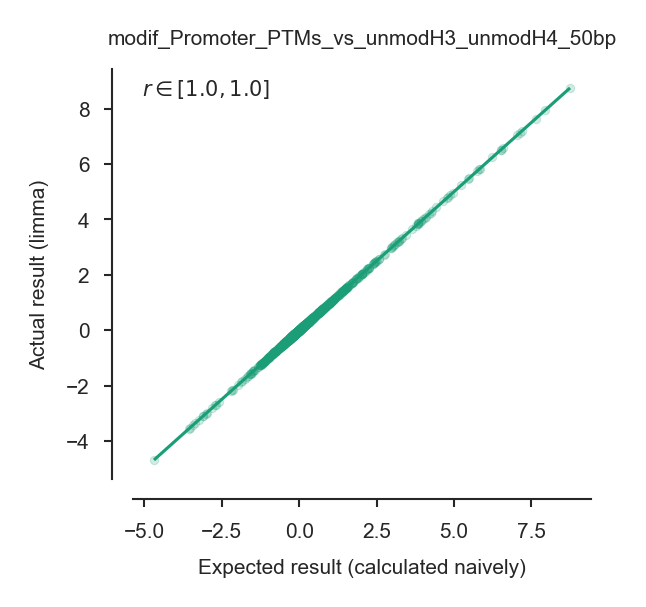

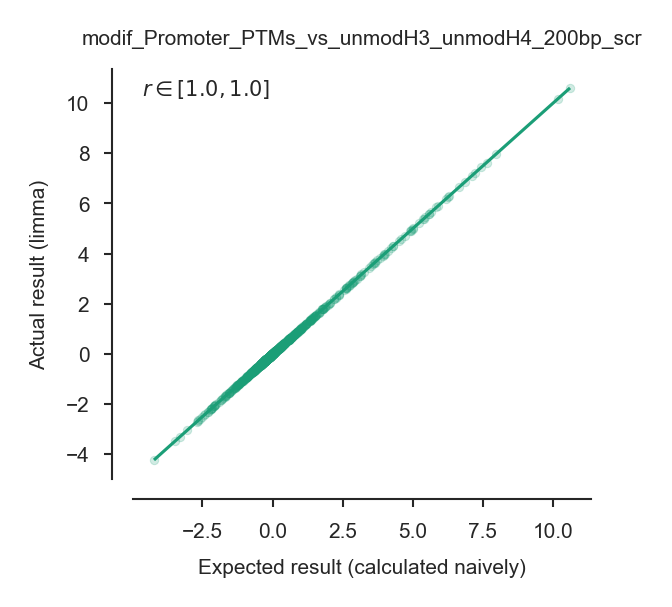

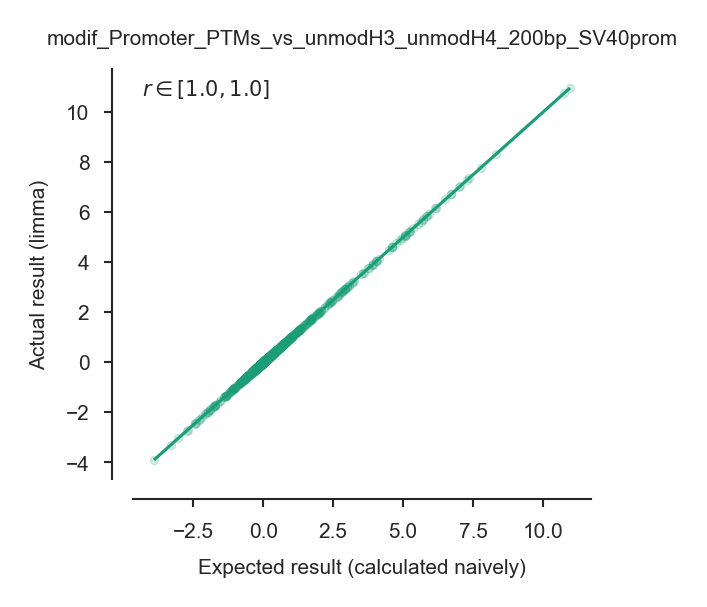

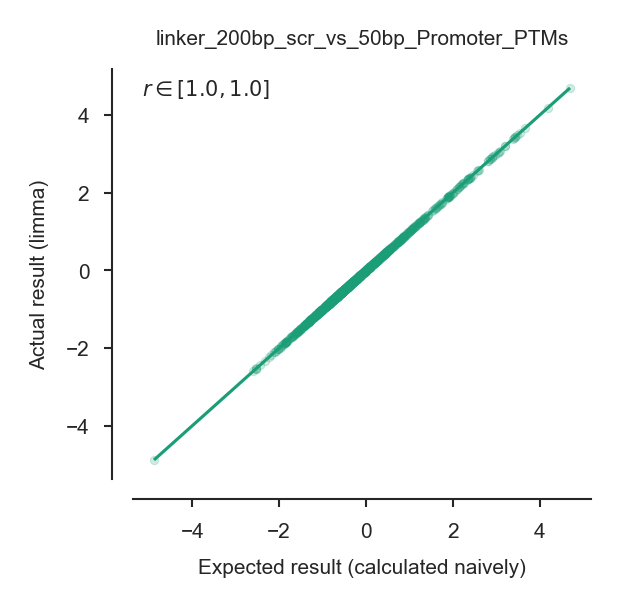

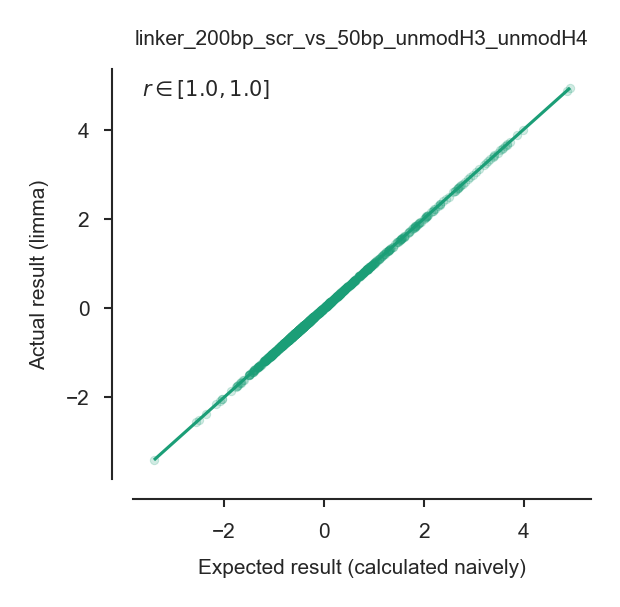

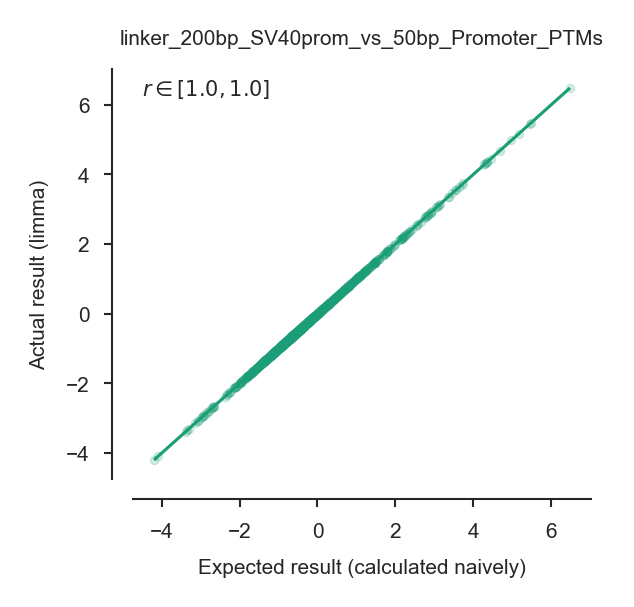

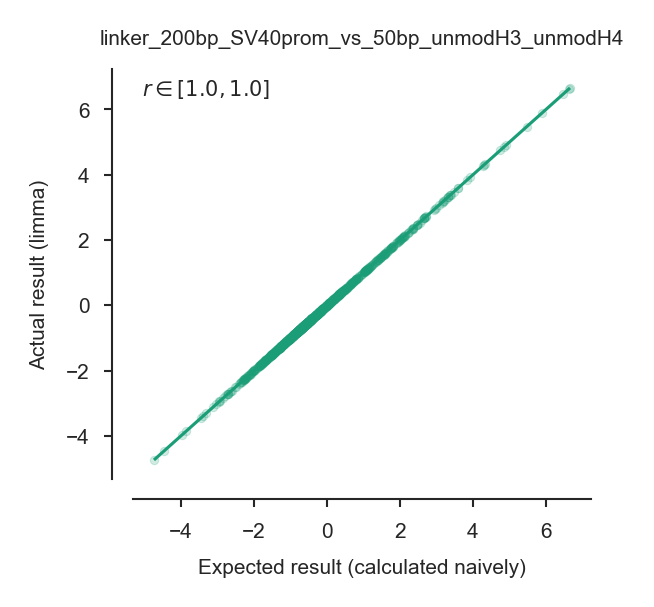

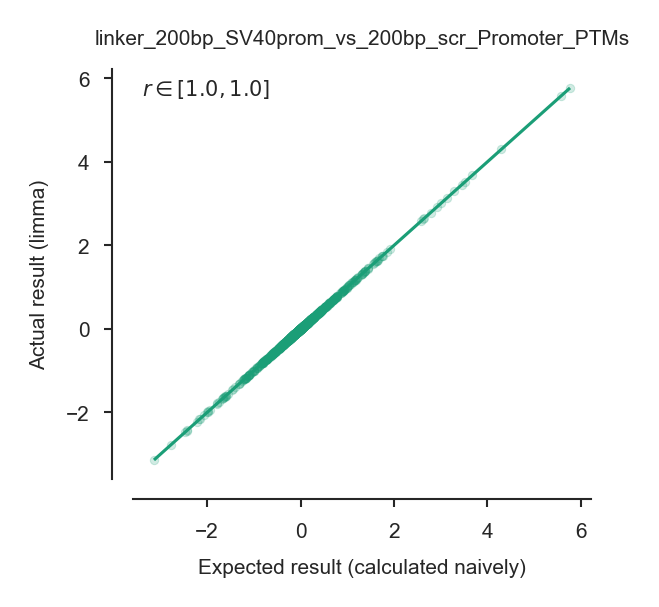

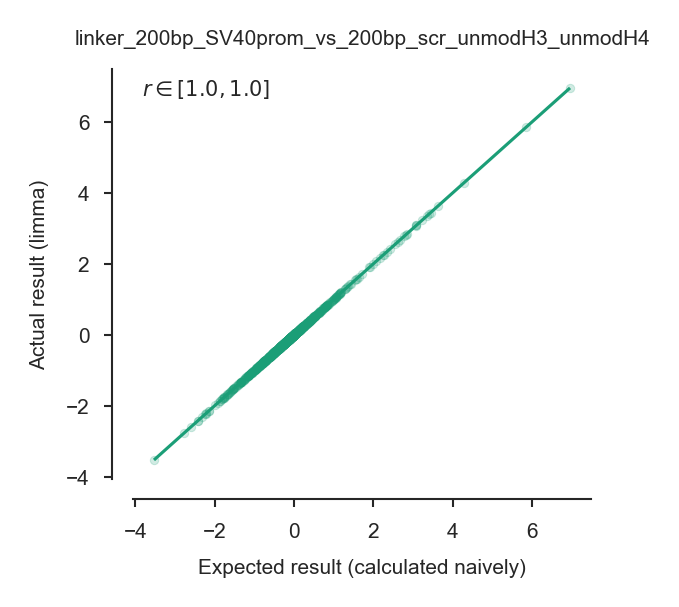

In [105]:
for column, expectation in expected_naively.items():
    fig = plt.figure()
    ax = plt.gca()
    
    _df = pd.DataFrame({'expectation': expectation, 'actual': results[column, 'logFC']})
    
    correlation = pg.corr(_df['expectation'], _df['actual'], method='pearson')
    assert np.abs(correlation.loc['pearson', 'r'] - 1) < 1e-6, '{}: Correlation should be perfect, got: {}'.format(column, correlation.loc['pearson', 'r']) # This should always be one
    correlation = correlation.loc['pearson', 'CI95%']
    
    sns.regplot(x='expectation', y='actual', scatter_kws=dict(alpha=0.2), data=_df)
    
    ax.text(0.02, 0.98, r'$r \in [{}, {}]$'.format(*correlation), transform=ax.transAxes, ha='left', va='top')
    ax.set_xlabel("Expected result (calculated naively)")
    ax.set_ylabel("Actual result (limma)")
    ax.set_title(column)
    sns.despine(ax=ax, offset=5)
    
    ax.grid(False)
    
    _fname = OUTPUT_DIRECTORY / f'04-modelling-sanity-checks-for-coefficient-interpretation-{column}.pdf'
    _caption = f"""
    Comparison of the {column} coefficient estimates computed by the model (y axis), and their expected values (x axis).
    The expected values were computed naively - by subtracting the coresponding means from each other.
    The actual values were computed using the limma statistical model.
    
    The scatterpoint highlight individual protein estimates, the line is a linear regression estimate.
    The 95% confidence interval for pearson R estimate is written in the top left corner.
    
    If the model is working correctly, we would expect a perfect fit here.
    """
    plt.savefig(_fname, bbox_inches='tight', dpi=DPI)
    with open(str(_fname) + '.caption.md', 'w') as f:
        f.write(_caption)
        print(_caption)
    

In [106]:
results.swaplevel(axis=1)['significant'].sum()

modif_Promoter_PTMs_vs_unmodH3_unmodH4_50bp              209
modif_Promoter_PTMs_vs_unmodH3_unmodH4_200bp_SV40prom    165
modif_Promoter_PTMs_vs_unmodH3_unmodH4_200bp_scr         176
linker_200bp_scr_vs_50bp_Promoter_PTMs                   666
linker_200bp_SV40prom_vs_50bp_Promoter_PTMs              788
linker_200bp_scr_vs_50bp_unmodH3_unmodH4                 545
linker_200bp_SV40prom_vs_50bp_unmodH3_unmodH4            849
linker_200bp_SV40prom_vs_200bp_scr_Promoter_PTMs          66
linker_200bp_SV40prom_vs_200bp_scr_unmodH3_unmodH4       126
dtype: int64

### Imputation

Imputation of results

While the model behaves correctly for most proteins, we want to:

1. flag the following result estimates:
    - estimates which are based only on one data point
    - imputed estimates (see below)
2. impute certain fold change estimates, namely:
    - mark proteins detected in treatments, but not detected in both controls as "infinitely enriched" (logFC=+inf)
    - mark proteins detected in both controls, but not in treatmets as "infinitely excluded" (logFC=-inf)
    - in cases where logFC could not be estimated because one (but not both!) controls are missing, calculate the logFC only from the control that is detected.

In [107]:
def flag_and_or_impute(estimate, treatments, controls):
    
    # Count number of datapoints for treatment and control
    number_non_null_treatments = (~treatments.isnull()).sum(axis=1)
    number_non_null_controls = (~controls.isnull()).sum(axis=1)
    
    # First check if our estimate is based on a single datapoint
    # This is true if treatments have only one non-null value
                                                            
    based_on_single_datapoint = number_non_null_treatments == 1
    # Or the controls have only one non-null value
    based_on_single_datapoint |= number_non_null_controls == 1
    
    # Now let's see if we need to impute some of the estimates
    
    
    # Start with copying the estimates
    imputed_estimate = estimate.copy()
    
    # Find datapoints w/o estimates
    no_estimate = estimate.isnull()
    
    # Impute positive infinities
    imputed_estimate.loc[
        # Where we have no estimate, but treatment data and no control data
        no_estimate & (number_non_null_treatments > 0)  & (number_non_null_controls == 0),
    ] = np.inf
    
    # Impute negative infinities
    imputed_estimate.loc[
        # Where we have no estimate, no treatment data but some control data
        no_estimate & (number_non_null_treatments == 0)  & (number_non_null_controls > 0),
    ] = -np.inf
    
    # Impute estimates where we have some treatment and control data, but still no estimate
    # (this happens when only one of the controls give a value, for instance)
    imputable_entries = no_estimate & (number_non_null_treatments > 0)  & (number_non_null_controls > 0)
    
    # Here we are using the results from the "sanity checks above" - that the mean estimates are
    # the same as model estimates..
    imputed_estimate.loc[
        imputable_entries,
    ] = treatments.loc[imputable_entries].mean(axis=1) - controls.loc[imputable_entries].mean(axis=1)
    
    
    # We can get the list of imputed estimates by comparing the null estimates between the imputed and (real) column:
    
    is_imputed = (~imputed_estimate.isnull()) & (no_estimate)
    
    # assert that for all non-null estimates imputed estimate is the same (i.e. that we didn't override)
    assert_array_equal(imputed_estimate.loc[~no_estimate], estimate.loc[~no_estimate])
    
    
    return pd.DataFrame({
        'logFC_imputed': imputed_estimate,
        'logFC_is_imputed': is_imputed,
        'logFC_based_on_single_datapoint': based_on_single_datapoint, 
    })

In [108]:
results_flags_and_imputations = {}

for contrast, (treat, control) in naive_links.items():
    results_flags_and_imputations[contrast] = flag_and_or_impute(
        results[contrast, 'logFC'], 
        data_to_model_by_experiment_label(treat),
        data_to_model_by_experiment_label(control),
    )
    
results_flags_and_imputations = pd.concat(results_flags_and_imputations, axis=1)
results_flags_and_imputations

modif_Promoter_PTMs_vs_unmodH3_unmodH4_50bp                   \
                                      logFC_imputed logFC_is_imputed   
AATF                                      -0.125577            False   
ABCA13                                    -0.137848            False   
ABCF2                                      0.953550            False   
ABLIM1                                    -0.039556            False   
ACACA                                     -0.013911            False   
...                                             ...              ...   
ZNF740                                     0.689207            False   
ZNF768                                     1.163944            False   
ZRANB2                                         -inf             True   
ZSCAN29                                   -0.499720            False   
ZZZ3                                            inf             True   

                                         \
        logFC_based_on_single_datapoint   
AATF                              False   
ABCA13                            False   
ABCF2                             False   
ABLIM1                            False   
ACACA                             False   
...                                 ...   
ZNF740                            False   
ZNF768                            False   
ZRANB2                            False   
ZSCAN29                           False   
ZZZ3                              False   

        modif_Promoter_PTMs_vs_unmodH3_unmodH4_200bp_scr                   \
                                           logFC_imputed logFC_is_imputed   
AATF                                           -0.220103            False   
ABCA13                                         -0.171489            False   
ABCF2                                           1.051085            False   
ABLIM1                                         -0.427366            False   
ACACA                                          -0.230999            False   
...                                                  ...              ...   
ZNF740                                          0.769877            False   
ZNF768                                          0.789843            False   
ZRANB2                                          0.272145            False   
ZSCAN29                                         0.079208            False   
ZZZ3                                                 inf             True   

                                         \
        logFC_based_on_single_datapoint   
AATF                              False   
ABCA13                            False   
ABCF2                             False   
ABLIM1                            False   
ACACA                             False   
...                                 ...   
ZNF740                            False   
ZNF768                            False   
ZRANB2                            False   
ZSCAN29                           False   
ZZZ3                              False   

        modif_Promoter_PTMs_vs_unmodH3_unmodH4_200bp_SV40prom  \
                                                logFC_imputed   
AATF                                             -0.138764      
ABCA13                                            0.055330      
ABCF2                                             1.193817      
ABLIM1                                           -0.082166      
ACACA                                            -0.118920      
...                                                    ...      
ZNF740                                            0.209984      
ZNF768                                            0.945516      
ZRANB2                                           -1.335758      
ZSCAN29                                           0.318109      
ZZZ3                                              1.640301      

                                                          \
        logFC_is_imputed logFC_based_on_sin

In [109]:
for contrast in naive_links:
    n_imputed = results_flags_and_imputations[contrast, 'logFC_is_imputed'].sum()
    print(f'{contrast}: number imputed: {n_imputed}')

modif_Promoter_PTMs_vs_unmodH3_unmodH4_50bp: number imputed: 59
modif_Promoter_PTMs_vs_unmodH3_unmodH4_200bp_scr: number imputed: 41
modif_Promoter_PTMs_vs_unmodH3_unmodH4_200bp_SV40prom: number imputed: 36
linker_200bp_scr_vs_50bp_Promoter_PTMs: number imputed: 28
linker_200bp_scr_vs_50bp_unmodH3_unmodH4: number imputed: 56
linker_200bp_SV40prom_vs_50bp_Promoter_PTMs: number imputed: 33
linker_200bp_SV40prom_vs_50bp_unmodH3_unmodH4: number imputed: 58
linker_200bp_SV40prom_vs_200bp_scr_Promoter_PTMs: number imputed: 9
linker_200bp_SV40prom_vs_200bp_scr_unmodH3_unmodH4: number imputed: 30


Add data comment columns

In [110]:
def comment_string(flags, column):
    
    if flags['logFC_is_imputed'] and flags['logFC_based_on_single_datapoint']:
        return f'logFC({column}) estimation failed and was imputed based on a single datapoint only'
    elif flags['logFC_is_imputed']:
        return f'logFC({column}) estimation failed and was imputed'
    elif flags['logFC_based_on_single_datapoint']:
        return f'logFC({column}) estimation was based on a single datapoint only'
    elif pd.isnull(flags['logFC_imputed']):
        return f'logFC({column}) estimation failed'
    

In [111]:
contrasts_matrix_as_df.columns

Index(['modif_Promoter_PTMs_vs_unmodH3_unmodH4_50bp',
       'modif_Promoter_PTMs_vs_unmodH3_unmodH4_200bp_SV40prom',
       'modif_Promoter_PTMs_vs_unmodH3_unmodH4_200bp_scr',
       'linker_200bp_scr_vs_50bp_Promoter_PTMs',
       'linker_200bp_SV40prom_vs_50bp_Promoter_PTMs',
       'linker_200bp_scr_vs_50bp_unmodH3_unmodH4',
       'linker_200bp_SV40prom_vs_50bp_unmodH3_unmodH4',
       'linker_200bp_SV40prom_vs_200bp_scr_Promoter_PTMs',
       'linker_200bp_SV40prom_vs_200bp_scr_unmodH3_unmodH4'],
      dtype='object')

In [112]:
comments_results_flags = {
    col: results_flags_and_imputations[col].apply(comment_string, column=col, axis=1) for col in contrasts_matrix_as_df.columns
}

Let's check the imputation results for the representative null proteins below, a reminder of what the data to model for these proteins looks like:

In [113]:
data_to_model.loc[REPRESENTATIVE_NULLS]

Experiment_Linker_Replicate  Promoter_PTMs_50bp_repl1  \
Label                                                   
MYBL1                                             NaN   
ARID2                                       27.872115   
GTF3C3                                      20.355733   
ING3                                        23.640809   
EPC1                                        21.109749   

Experiment_Linker_Replicate  Promoter_PTMs_200bp_scr_repl1  \
Label                                                        
MYBL1                                            22.230265   
ARID2                                            27.022339   
GTF3C3                                           21.017964   
ING3                                             23.065544   
EPC1                                             21.508323   

Experiment_Linker_Replicate  Promoter_PTMs_200bp_SV40prom_repl1  \
Label                                                             
MYBL1                                                 22.806570   
ARID2                                                 27.115198   
GTF3C3                                                20.641838   
ING3                                                  22.768276   
EPC1                                                  21.696648   

Experiment_Linker_Replicate  unmodH3_unmodH4_50bp_repl1  \
Label                                                     
MYBL1                                               NaN   
ARID2                                               NaN   
GTF3C3                                              NaN   
ING3                                                NaN   
EPC1                                                NaN   

Experiment_Linker_Replicate  unmodH3_unmodH4_200bp_scr_repl1  \
Label                                                          
MYBL1                                              21.221370   
ARID2                                                    NaN   
GTF3C3                                             20.599698   
ING3                                                     NaN   
EPC1                                                     NaN   

Experiment_Linker_Replicate  unmodH3_unmodH4_200bp_SV40prom_repl1  \
Label                                                               
MYBL1                                                   23.128063   
ARID2                                                   19.828911   
GTF3C3                                                        NaN   
ING3                                                          NaN   
EPC1                                                          NaN   

Experiment_Linker_Replicate  Promoter_PTMs_50bp_repl2  \
Label                                                   
MYBL1                                       19.462601   
ARID2                                       27.650954   
GTF3C3                                            NaN   
ING3                                        23.509194   
EPC1                                        21.635083   

Experiment_Linker_Replicate  Promoter_PTMs_200bp_scr_repl2  \
Label                                                        
MYBL1                                            21.858909   
ARID2                                            27.019563   
GTF3C3                                           20.810657   
ING3                                             22.864381   
EPC1                                             21.397356   

Experiment_Linker_Replicate  Promoter_PTMs_200bp_SV40prom_repl2  \
Label                                                             
MYBL1                                                 22.824394   
ARID2                                                 26.900705   
GTF3C3                                                      NaN   
ING3                                                  22.833403   
EPC1                                                  21.270236   

Experiment_Linker_Replicate  unmodH3_unmodH

The corresponding mean estimates for the coefficients minus simple mean of controls (for comparison) where approrpiate

In [114]:
results_flags_and_imputations.loc[REPRESENTATIVE_NULLS].loc(axis=1)[:, 'logFC_imputed']

modif_Promoter_PTMs_vs_unmodH3_unmodH4_50bp  \
                                     logFC_imputed   
MYBL1                                          inf   
ARID2                                          inf   
GTF3C3                                         inf   
ING3                                           inf   
EPC1                                           inf   

       modif_Promoter_PTMs_vs_unmodH3_unmodH4_200bp_scr  \
                                          logFC_imputed   
MYBL1                                          0.629685   
ARID2                                          7.955775   
GTF3C3                                         0.635601   
ING3                                           2.849759   
EPC1                                                inf   

       modif_Promoter_PTMs_vs_unmodH3_unmodH4_200bp_SV40prom  \
                                               logFC_imputed   
MYBL1                                           -0.237601      
ARID2                                            7.363703      
GTF3C3                                                inf      
ING3                                                  inf      
EPC1                                                  inf      

       linker_200bp_scr_vs_50bp_Promoter_PTMs  \
                                logFC_imputed   
MYBL1                                2.214205   
ARID2                               -0.595406   
GTF3C3                               0.529114   
ING3                                -0.006590   
EPC1                                -0.267751   

       linker_200bp_scr_vs_50bp_unmodH3_unmodH4  \
                                  logFC_imputed   
MYBL1                                       inf   
ARID2                                       inf   
GTF3C3                                      inf   
ING3                                        inf   
EPC1                                        NaN   

       linker_200bp_SV40prom_vs_50bp_Promoter_PTMs  \
                                     logFC_imputed   
MYBL1                                     3.341893   
ARID2                                    -0.774244   
GTF3C3                                    0.286105   
ING3                                     -0.205692   
EPC1                                     -0.017009   

       linker_200bp_SV40prom_vs_50bp_unmodH3_unmodH4  \
                                       logFC_imputed   
MYBL1                                            inf   
ARID2                                            inf   
GTF3C3                                           NaN   
ING3                                             NaN   
EPC1                                             NaN   

       linker_200bp_SV40prom_vs_200bp_scr_Promoter_PTMs  \
                                          logFC_imputed   
MYBL1                                          1.127688   
ARID2                                         -0.178838   
GTF3C3                                        -0.243010   
ING3                                          -0.199103   
EPC1                                           0.250742   

       linker_200bp_SV40prom_vs_200bp_scr_unmodH3_unmodH4  
                                            logFC_imputed  
MYBL1                                            1.994973  
ARID2                                            0.413234  
GTF3C3                                               -inf  
ING3                                                 -inf  
EPC1                                                  NaN


## Output


At this point this notebook is finished, so it's time to collect the results and visualise

Let's start with a combined "comment column", which joins the filtering comment and the flag comments

In [115]:
full_comments = pd.DataFrame({'filter_comment': data_comment, 'norm_comment': comments_norm, **comments_results_flags})
full_comments

filter_comment norm_comment  \
AATF               NaN          NaN   
ABCA13             NaN          NaN   
ABCF2              NaN          NaN   
ABLIM1             NaN          NaN   
ACACA              NaN          NaN   
...                ...          ...   
ZNF740             NaN          NaN   
ZNF768             NaN          NaN   
ZRANB2             NaN          NaN   
ZSCAN29            NaN          NaN   
ZZZ3               NaN          NaN   

               modif_Promoter_PTMs_vs_unmodH3_unmodH4_50bp  \
AATF                                                  None   
ABCA13                                                None   
ABCF2                                                 None   
ABLIM1                                                None   
ACACA                                                 None   
...                                                    ...   
ZNF740                                                None   
ZNF768                                                None   
ZRANB2   logFC(modif_Promoter_PTMs_vs_unmodH3_unmodH4_5...   
ZSCAN29                                               None   
ZZZ3     logFC(modif_Promoter_PTMs_vs_unmodH3_unmodH4_5...   

        modif_Promoter_PTMs_vs_unmodH3_unmodH4_200bp_SV40prom  \
AATF                                                  None      
ABCA13                                                None      
ABCF2                                                 None      
ABLIM1                                                None      
ACACA                                                 None      
...                                                    ...      
ZNF740                                                None      
ZNF768                                                None      
ZRANB2                                                None      
ZSCAN29                                               None      
ZZZ3                                                  None      

          modif_Promoter_PTMs_vs_unmodH3_unmodH4_200bp_scr  \
AATF                                                  None   
ABCA13                                                None   
ABCF2                                                 None   
ABLIM1                                                None   
ACACA                                                 None   
...                                                    ...   
ZNF740                                                None   
ZNF768                                                None   
ZRANB2                                                None   
ZSCAN29                                               None   
ZZZ3     logFC(modif_Promoter_PTMs_vs_unmodH3_unmodH4_2...   

                    linker_200bp_scr_vs_50bp_Promoter_PTMs  \
AATF                                                  None   
ABCA13                                                None   
ABCF2                                                 None   
ABLIM1                                                None   
ACACA                                                 None   
...                                                    ...   
ZNF740                                                None   
ZNF768                                                None   
ZRANB2   logFC(linker_200bp_scr_vs_50bp_Promoter_PTMs) ...   
ZSCAN29                                               None   
ZZZ3                                                  None   

               linker_200bp_SV40prom_vs_50bp_Promoter_PTMs  \
AATF                                                  None   
ABCA13                                                None   
ABCF2                                                 None   
ABLIM1                                                None   
ACACA                                                 None   
...                                                    ...   
ZNF740                                                None   
ZNF768                     

Use a separator of ';'

In [116]:
full_comments = full_comments.apply(lambda x: '; '.join(x.dropna()), axis=1)
full_comments

AATF                                                        
ABCA13                                                      
ABCF2                                                       
ABLIM1                                                      
ACACA                                                       
                                 ...                        
ZNF740                                                      
ZNF768                                                      
ZRANB2     logFC(modif_Promoter_PTMs_vs_unmodH3_unmodH4_5...
ZSCAN29                                                     
ZZZ3       logFC(modif_Promoter_PTMs_vs_unmodH3_unmodH4_5...
Length: 1600, dtype: object

In [117]:
full_comments.value_counts()

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               1431
logFC(modif_Promoter_PTMs_vs_unmodH3_unmodH4_50bp) estimation was based on a single datapoint only; logFC(linker_200bp_scr_vs_50bp_Promoter_PTMs) estimation was bas

Now gather all the data that we would need to save:

In [118]:
_comments = pd.DataFrame(full_comments.copy())
_comments.columns = pd.MultiIndex.from_tuples([('comment', 'comment')])

_coef_estimates = coef_estimates_design.copy()
_coef_estimates.columns = pd.MultiIndex.from_tuples([('coefficient_estimates', c) for c in _coef_estimates.columns])

_norm_data = data_numeric_log2_normalised.copy()
_norm_data.columns = pd.MultiIndex.from_tuples([('normalised_data', c) for c in _norm_data.columns])

_norm_data_to_reference = data_numeric_log2_normalised_reference_normalised.copy()
_norm_data_to_reference.columns = pd.MultiIndex.from_tuples([('normalised_data_to_reference_experiment', c) for c in _norm_data_to_reference.columns])


In [119]:
full_results = _norm_data.join(_norm_data_to_reference).join(_comments).join(results).join(_coef_estimates).join(results_flags_and_imputations)
full_results

normalised_data                                \
       Promoter_PTMs_50bp_repl1 Promoter_PTMs_200bp_scr_repl1   
Label                                                           
MYH9                  31.166748                     30.858335   
SPTAN1                29.878543                     29.162200   
PRKDC                 30.348566                     28.903597   
SPTBN1                30.336882                     30.054484   
ACTB                  34.474818                     33.868815   
...                         ...                           ...   
ADD1                  23.867955                     23.280832   
CCNK                  20.456071                     19.869493   
DCAF13                      NaN                     19.896284   
YTHDF2                25.730154                     26.487132   
BAX                   22.481332                     20.252429   

                                                                      \
       Promoter_PTMs_200bp_SV40prom_repl1 unmodH3_unmodH4_50bp_repl1   
Label                                                                  
MYH9                            30.758976                  31.526223   
SPTAN1                          29.179715                  30.116440   
PRKDC                           28.957490                  30.031864   
SPTBN1                          30.104161                  30.083646   
ACTB                            33.703765                  34.576133   
...                                   ...                        ...   
ADD1                            22.665685                  21.617533   
CCNK                            20.842011                  19.614966   
DCAF13                          19.532747                  19.080878   
YTHDF2                          26.261445                  26.200518   
BAX                             21.036868                  22.581442   

                                                                             \
       unmodH3_unmodH4_200bp_scr_repl1 unmodH3_unmodH4_200bp_SV40prom_repl1   
Label                                                                         
MYH9                         31.010420                            30.819292   
SPTAN1                       29.439311                            29.368745   
PRKDC                        29.437866                            29.094567   
SPTBN1                       29.600386                            28.860387   
ACTB                         34.004750                            33.957784   
...                                ...                                  ...   
ADD1                         22.733905                            22.863463   
CCNK                         19.921943                                  NaN   
DCAF13                       19.677062                            20.451744   
YTHDF2                       26.785723                            26.376115   
BAX                          21.700987                            19.433958   

                                                               \
       Promoter_PTMs_50bp_repl2 Promoter_PTMs_200bp_scr_repl2   
Label                                                           
MYH9                  31.164662                     30.769239   
SPTAN1                29.635929                     29.050939   
PRKDC                 29.037081                     28.526610   
SPTBN1                30.269337                     30.041392   
ACTB                  34.116724                     33.657320   
...                         ...                           ...   
ADD1                  23.764150                     23.493793   
CCNK                  21.354433                     19.263740   
DCAF13                18.871758                     18.468884   
YTHDF2                26.217590                     25.987315   
BAX                   22.395182                     20.268958   

                                                                      ...  \
 

For storage, remove multi-index:

In [120]:
full_results_no_multiindex = full_results.copy()
full_results_no_multiindex.columns = ['___'.join(c) for c in full_results.columns]

In [121]:
full_results_no_multiindex.to_csv(OUTPUT_DIRECTORY / f'07-output-full_results.{DATASET}.csv')

In [122]:
headers['Linker'].unique()

array(['50bp', '200bp_scr', '200bp_SV40prom'], dtype=object)

## Visualisation

In [123]:
results

modif_Promoter_PTMs_vs_unmodH3_unmodH4_50bp                           \
                                             logFC          t       P.Value   
H2AZ2                                     7.035376  51.930118  6.644281e-18   
TAF12                                     7.210773  38.075155  5.837786e-16   
CDK9                                      5.241576  31.077564  1.077559e-14   
INO80E                                    6.522545  26.679288  9.534919e-14   
BRD9                                      3.777210  26.075325  1.321202e-13   
...                                            ...        ...           ...   
GTF3C3                                         NaN        NaN           NaN   
TAF6L                                          NaN        NaN           NaN   
ZBTB7A                                         NaN        NaN           NaN   
DOCK9                                          NaN        NaN           NaN   
CXXC1                                          NaN        NaN           NaN   

                                                                           \
           adj.P.Val          B significant significant_with_large_log2fc   
H2AZ2   1.007273e-14  29.310271        True                          True   
TAF12   4.425042e-13  26.076714        True                          True   
CDK9    5.445267e-12  23.657889        True                          True   
INO80E  3.613734e-11  21.721434        True                          True   
BRD9    4.005883e-11  21.423770        True                          True   
...              ...        ...         ...                           ...   
GTF3C3           NaN        NaN       False                         False   
TAF6L            NaN        NaN       False                         False   
ZBTB7A           NaN        NaN       False                         False   
DOCK9            NaN        NaN       False                         False   
CXXC1            NaN        NaN       False                         False   

       modif_Promoter_PTMs_vs_unmodH3_unmodH4_200bp_SV40prom             \
                                                       logFC          t   
H2AZ2                                            7.772622     57.371946   
TAF12                                            5.063551     26.737145   
CDK9                                             4.898577     29.043906   
INO80E                                           6.506726     26.614583   
BRD9                                             3.759704     25.954471   
...                                                   ...           ...   
GTF3C3                                                NaN           NaN   
TAF6L                                            1.249792      1.583643   
ZBTB7A                                          -1.348768     -2.515970   
DOCK9                                            0.962818      0.995741   
CXXC1                                                 NaN           NaN   

                      ... linker_200bp_SV40prom_vs_200bp_scr_Promoter_PTMs  \
             P.Value  ...                                                B   
H2AZ2   1.573053e-18  ...                                        -7.017720   
TAF12   9.245059e-14  ...                                        -6.624193   
CDK9    2.837622e-14  ...                                        -6.869069   
INO80E  9.870620e-14  ...                                        -5.445122   
BRD9    1.411537e-13  ...                                        -6.820165   
...              ...  ...                                              ...   
GTF3C3           NaN  ...                                        -6.436969   
TAF6L   1.553511e-01  ...                                        -6.546469   
ZBTB7A  4.349777e-02  ...                                        -3.067866   
DOCK9   3.860659e-01  ...                                        -6.504546   
CXXC1            NaN  ...                                        

In [124]:
import textwrap

/usr/local/Caskroom/miniconda/base/envs/marcs-variable-linker-pds/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/marcs-variable-linker-pds/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


/usr/local/Caskroom/miniconda/base/envs/marcs-variable-linker-pds/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/marcs-variable-linker-pds/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


/usr/local/Caskroom/miniconda/base/envs/marcs-variable-linker-pds/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/marcs-variable-linker-pds/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


/usr/local/Caskroom/miniconda/base/envs/marcs-variable-linker-pds/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/marcs-variable-linker-pds/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(



    A scatterplot diagram of model estimates.

    The first plot simply plots the whole data, the second plot highlights proteins used to normalise the data, while the remaining three plots highlight proteins for which
    the corresponding estimates are statistically non zero. (limma, at FDR 0.05, BH correction).
    Labels are displayed for a handful of outlier proteins.
    


/usr/local/Caskroom/miniconda/base/envs/marcs-variable-linker-pds/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/marcs-variable-linker-pds/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


/usr/local/Caskroom/miniconda/base/envs/marcs-variable-linker-pds/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/marcs-variable-linker-pds/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


/usr/local/Caskroom/miniconda/base/envs/marcs-variable-linker-pds/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/marcs-variable-linker-pds/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


/usr/local/Caskroom/miniconda/base/envs/marcs-variable-linker-pds/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/marcs-variable-linker-pds/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(



    A scatterplot diagram of model estimates.

    The first plot simply plots the whole data, the second plot highlights proteins used to normalise the data, while the remaining three plots highlight proteins for which
    the corresponding estimates are statistically non zero. (limma, at FDR 0.05, BH correction).
    Labels are displayed for a handful of outlier proteins.
    


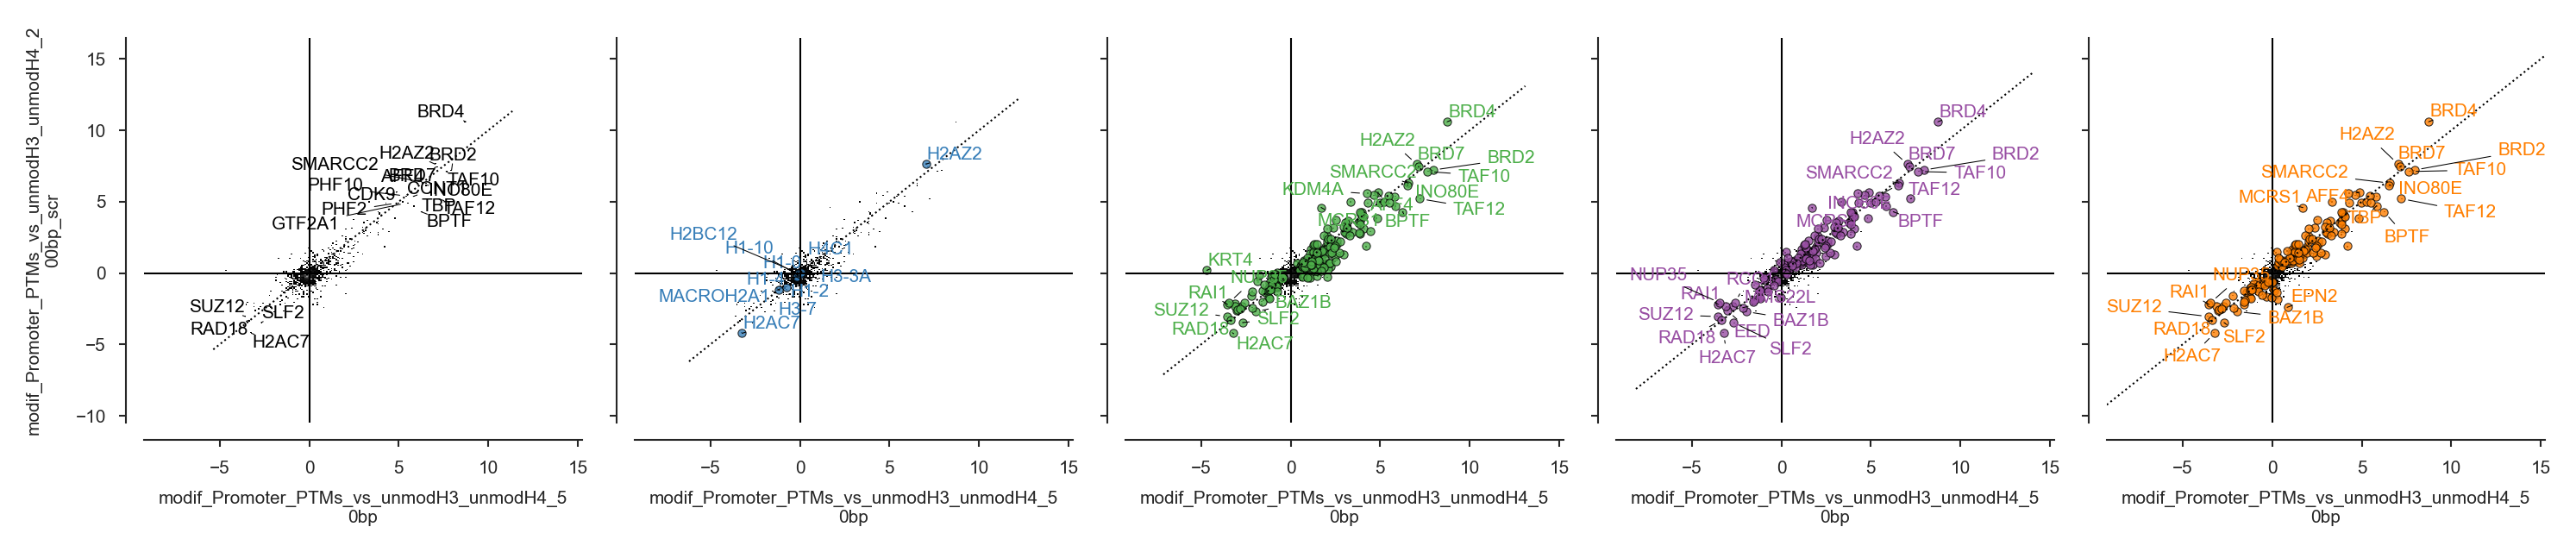

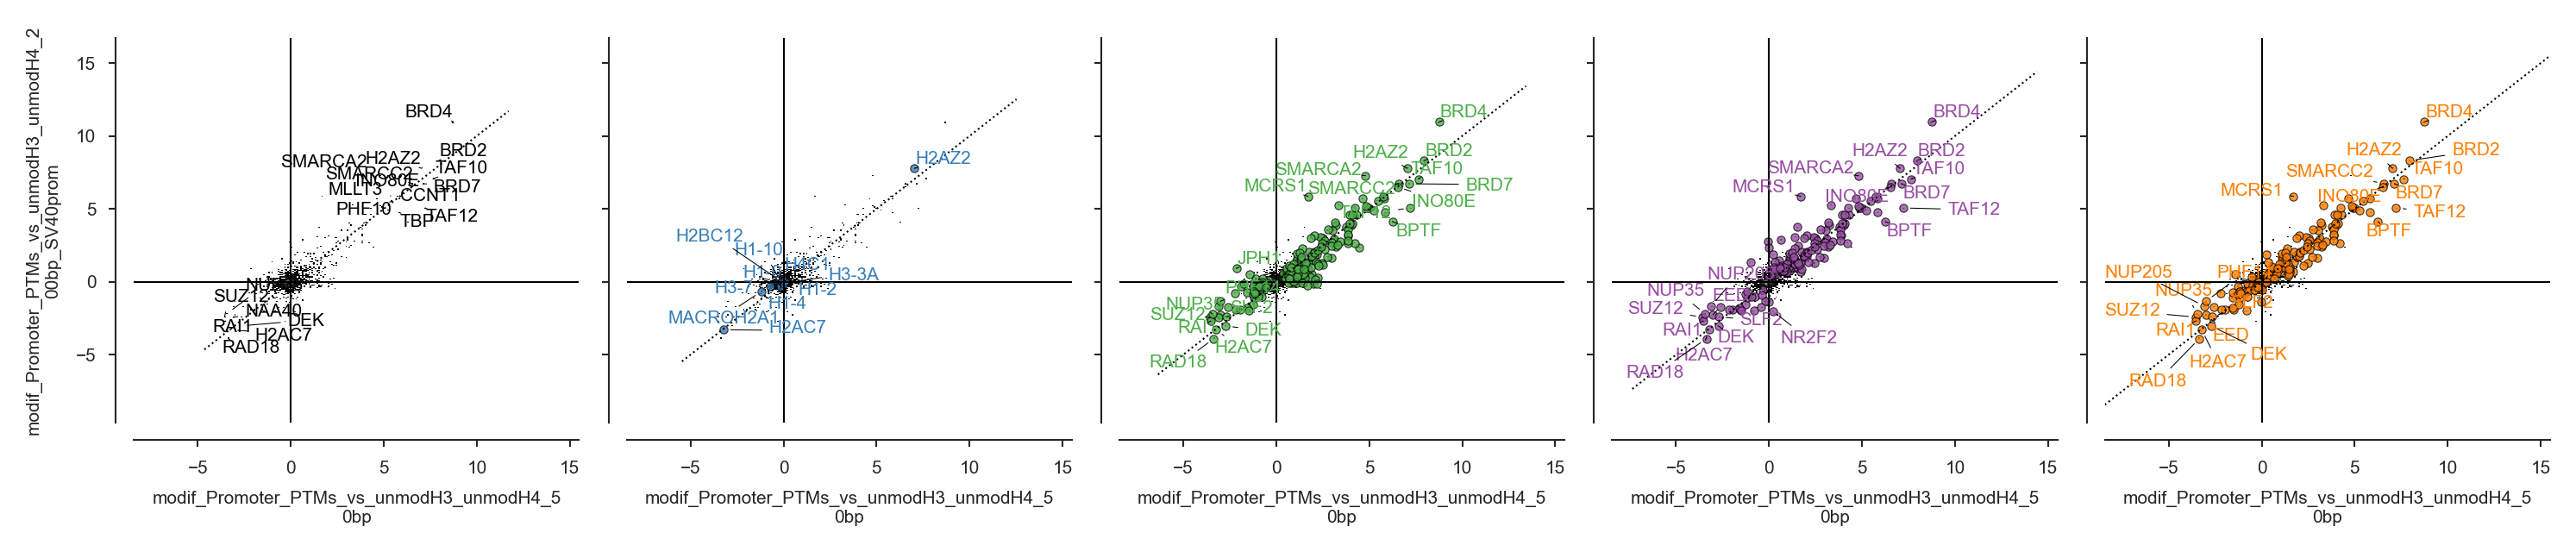

In [125]:
from sklearn.ensemble import IsolationForest
from adjustText import adjust_text
import itertools

if DATASET == 'long-linkers-prom':
    combinations =  [
        ('Promoter_PTMs', '200bp_scr'),
        ('Promoter_PTMs', '200bp_SV40prom')
    ] 
    
elif DATASET == 'long-linkers-enh':
    
    combinations = list(itertools.product(['H3K27ac', 'H3K4me1K27ac', 'H3K4me1'], ['200bp_scr', '200bp_SV40enh']))
else:    
    combinations = list(itertools.product(['H3K27me3', 'H3K9me3'], ['35bp', '40bp', '45bp', '55bp']))


for experiment, linker in combinations:

    fig = plt.figure(figsize=(50*FIVE_MM_IN_INCH, 10*FIVE_MM_IN_INCH), constrained_layout=True)

    axes = fig.subplots(nrows=1, ncols=5, sharex=True, sharey=True)

    _x = (f'modif_{experiment}_vs_{ref_experiment}_{ref_linker}', 'logFC')
    _y = (f'modif_{experiment}_vs_{ref_experiment}_{linker}', 'logFC')
    _df = full_results.dropna(subset=[_x, _y])
    _approx_nlabels = 20

    for ax, col, color in zip(axes, [None] + ['normalisation_proteins'] + list(contrasts_matrix_as_df.columns), sns.color_palette('Set1')):

        sns.histplot(
            x=_x, 
            y=_y, 
            data=_df,
            cmap=sns.blend_palette(['#000000','#969696'], as_cmap=True),
            ax=ax,
        )

        if col is None:
            if_ = IsolationForest(random_state=42, contamination=np.clip(_approx_nlabels/len(_df), 1e-5, 0.5))

            outliers = if_.fit_predict(_df[[_x, _y]])
            outliers = pd.Series((outliers == -1), index=_df.index)

            texts = []
            for ix in outliers[outliers].index:
                texts.append(ax.text(_df.loc[ix, _x], _df.loc[ix, _y], ix, color='black'))

            adjust_text(texts, arrowprops=dict(arrowstyle='-'), ax=ax)
        elif col == 'normalisation_proteins':


            ax.scatter(
                _df.loc[HISTONES, _x],
                _df.loc[HISTONES, _y],
                color=color,
                edgecolor='black',
                alpha=0.8,
                s=5,
                label=col,
            )

            texts = []
            for ix in HISTONES:
                texts.append(ax.text(_df.loc[ix, _x], _df.loc[ix, _y], ix, color=color))

            adjust_text(texts, arrowprops=dict(arrowstyle='-'), ax=ax)

        else:
            subdf = _df[_df[col, 'significant'].fillna(False)]

            if_ = IsolationForest(random_state=42, contamination=np.clip(_approx_nlabels/len(subdf), 1e-5, 0.5))
            outliers = if_.fit_predict(subdf[[_x, _y]])
            outliers = pd.Series((outliers == -1), index=subdf.index)

            ax.scatter(
                subdf[_x],
                subdf[_y],
                color=color,
                edgecolor='black',
                alpha=0.8,
                s=5,
                label=col,
            )

#             ax.legend(title="Significant")

            texts = []
            for ix in outliers[outliers].index:
                texts.append(ax.text(_df.loc[ix, _x], _df.loc[ix, _y], ix, color=color))

            adjust_text(texts, arrowprops=dict(arrowstyle='-'), ax=ax)

        ax.grid(False)

        ax.axvline(0, color='black', linestyle='-', linewidth=0.5)
        ax.axhline(0, color='black', linestyle='-', linewidth=0.5)

        xlim = ax.get_xlim()
        ylim = ax.get_ylim()

        min_ = np.min([xlim, ylim])
        max_ = np.max([xlim, ylim])

        ax.plot([min_, max_], [min_, max_], linestyle=':', color='k')
        ax.set_xlim(*xlim, *ylim)
        ax.set_xlabel('\n'.join(textwrap.wrap(_x[0], 40)))
        ax.set_ylabel('\n'.join(textwrap.wrap(_y[0], 40)))

        sns.despine(offset=5, ax=ax)

    _fname = OUTPUT_DIRECTORY / f'09-scatterplot-full-results_modif_logfc_{experiment}_{linker}.pdf'
    _caption = f"""
    A scatterplot diagram of model estimates.

    The first plot simply plots the whole data, the second plot highlights proteins used to normalise the data, while the remaining three plots highlight proteins for which
    the corresponding estimates are statistically non zero. (limma, at FDR {FDR_THRESHOLD}, BH correction).
    Labels are displayed for a handful of outlier proteins.
    """
    plt.savefig(_fname, bbox_inches='tight', dpi=DPI)
    with open(str(_fname) + '.caption.md', 'w') as f:
        f.write(_caption)
        print(_caption)

Linker datasets:

/usr/local/Caskroom/miniconda/base/envs/marcs-variable-linker-pds/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/marcs-variable-linker-pds/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


/usr/local/Caskroom/miniconda/base/envs/marcs-variable-linker-pds/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/marcs-variable-linker-pds/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


/usr/local/Caskroom/miniconda/base/envs/marcs-variable-linker-pds/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/marcs-variable-linker-pds/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


/usr/local/Caskroom/miniconda/base/envs/marcs-variable-linker-pds/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/marcs-variable-linker-pds/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(



    A scatterplot diagram of model estimates.

    The first plot simply plots the whole data, the second plot highlights proteins used to normalise the data, while the remaining three plots highlight proteins for which
    the corresponding estimates are statistically non zero. (limma, at FDR 0.05, BH correction).
    Labels are displayed for a handful of outlier proteins.
    


/usr/local/Caskroom/miniconda/base/envs/marcs-variable-linker-pds/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/marcs-variable-linker-pds/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


/usr/local/Caskroom/miniconda/base/envs/marcs-variable-linker-pds/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/marcs-variable-linker-pds/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


/usr/local/Caskroom/miniconda/base/envs/marcs-variable-linker-pds/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/marcs-variable-linker-pds/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


/usr/local/Caskroom/miniconda/base/envs/marcs-variable-linker-pds/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/marcs-variable-linker-pds/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(



    A scatterplot diagram of model estimates.

    The first plot simply plots the whole data, the second plot highlights proteins used to normalise the data, while the remaining three plots highlight proteins for which
    the corresponding estimates are statistically non zero. (limma, at FDR 0.05, BH correction).
    Labels are displayed for a handful of outlier proteins.
    


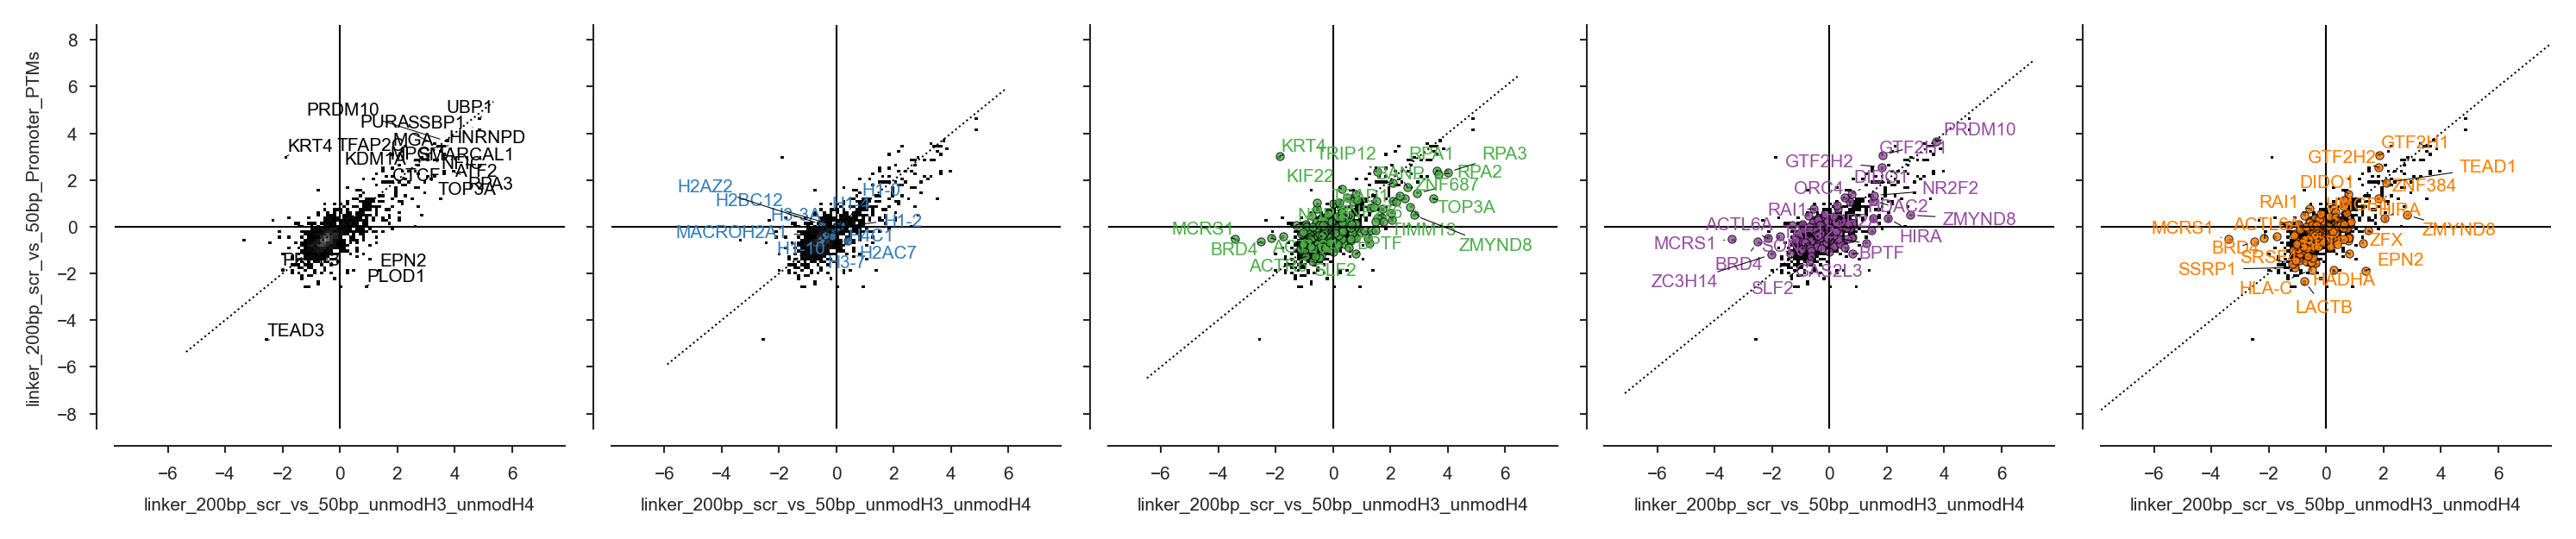

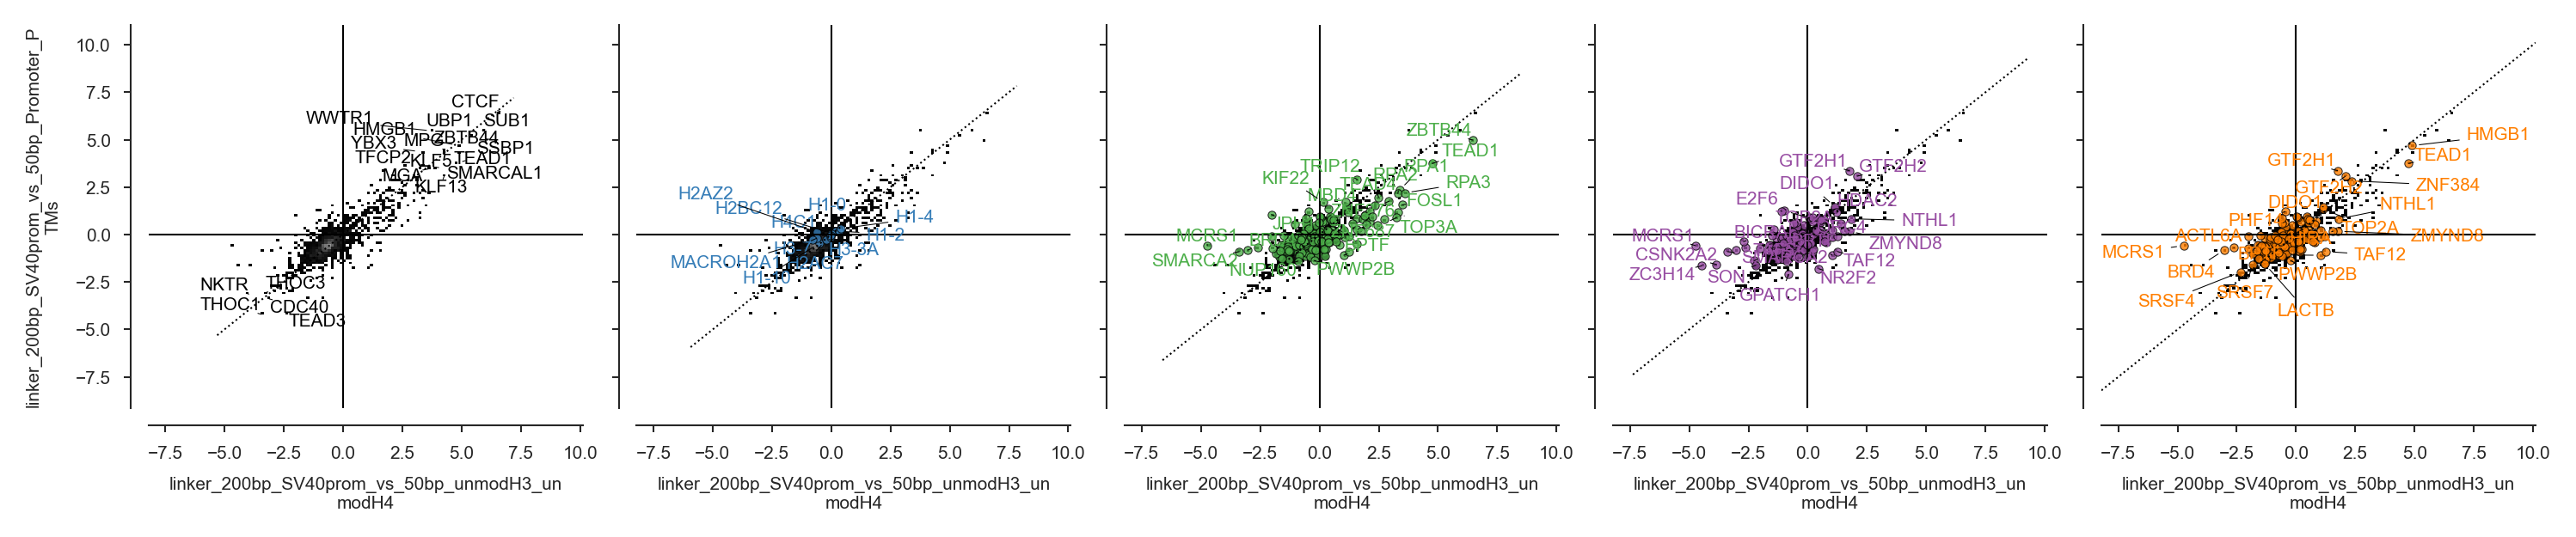

In [126]:
from sklearn.ensemble import IsolationForest
from adjustText import adjust_text
import itertools

if DATASET == 'long-linkers-prom':
    combinations =  [
        ('Promoter_PTMs', '200bp_scr'),
        ('Promoter_PTMs', '200bp_SV40prom'),
        # ('unmodH3_unmodH4', '200bp_scr'),
        # ('unmodH3_unmodH4', '200bp_SV40prom'),
    ] 
    
elif DATASET == 'long-linkers-enh':
    
    combinations = list(itertools.product(['H3K27ac', 'H3K4me1K27ac', 'H3K4me1'], ['200bp_scr', '200bp_SV40enh']))
else:    
    combinations = list(itertools.product(['H3K27me3', 'H3K9me3'], ['35bp', '40bp', '45bp', '55bp']))


for experiment, linker in combinations:

    fig = plt.figure(figsize=(50*FIVE_MM_IN_INCH, 10*FIVE_MM_IN_INCH), constrained_layout=True)

    axes = fig.subplots(nrows=1, ncols=5, sharex=True, sharey=True)

    _x = (f'linker_{linker}_vs_{ref_linker}_{ref_experiment}', 'logFC')
    _y = (f'linker_{linker}_vs_{ref_linker}_{experiment}', 'logFC')
    _df = full_results.dropna(subset=[_x, _y])
    _approx_nlabels = 20

    for ax, col, color in zip(axes, [None] + ['normalisation_proteins'] + list(contrasts_matrix_as_df.columns), sns.color_palette('Set1')):

        sns.histplot(
            x=_x, 
            y=_y, 
            data=_df,
            cmap=sns.blend_palette(['#000000','#969696'], as_cmap=True),
            ax=ax,
        )

        if col is None:
            if_ = IsolationForest(random_state=42, contamination=np.clip(_approx_nlabels/len(_df), 1e-5, 0.5))

            outliers = if_.fit_predict(_df[[_x, _y]])
            outliers = pd.Series((outliers == -1), index=_df.index)

            texts = []
            for ix in outliers[outliers].index:
                texts.append(ax.text(_df.loc[ix, _x], _df.loc[ix, _y], ix, color='black'))

            adjust_text(texts, arrowprops=dict(arrowstyle='-'), ax=ax)
        elif col == 'normalisation_proteins':


            ax.scatter(
                _df.loc[HISTONES, _x],
                _df.loc[HISTONES, _y],
                color=color,
                edgecolor='black',
                alpha=0.8,
                s=5,
                label=col,
            )

            texts = []
            for ix in HISTONES:
                texts.append(ax.text(_df.loc[ix, _x], _df.loc[ix, _y], ix, color=color))

            adjust_text(texts, arrowprops=dict(arrowstyle='-'), ax=ax)

        else:
            subdf = _df[_df[col, 'significant'].fillna(False)]

            if_ = IsolationForest(random_state=42, contamination=np.clip(_approx_nlabels/len(subdf), 1e-5, 0.5))
            outliers = if_.fit_predict(subdf[[_x, _y]])
            outliers = pd.Series((outliers == -1), index=subdf.index)

            ax.scatter(
                subdf[_x],
                subdf[_y],
                color=color,
                edgecolor='black',
                alpha=0.8,
                s=5,
                label=col,
            )

#             ax.legend(title="Significant")

            texts = []
            for ix in outliers[outliers].index:
                texts.append(ax.text(_df.loc[ix, _x], _df.loc[ix, _y], ix, color=color))

            adjust_text(texts, arrowprops=dict(arrowstyle='-'), ax=ax)

        ax.grid(False)

        ax.axvline(0, color='black', linestyle='-', linewidth=0.5)
        ax.axhline(0, color='black', linestyle='-', linewidth=0.5)

        xlim = ax.get_xlim()
        ylim = ax.get_ylim()

        min_ = np.min([xlim, ylim])
        max_ = np.max([xlim, ylim])

        ax.plot([min_, max_], [min_, max_], linestyle=':', color='k')
        ax.set_xlim(*xlim, *ylim)
        ax.set_xlabel('\n'.join(textwrap.wrap(_x[0], 40)))
        ax.set_ylabel('\n'.join(textwrap.wrap(_y[0], 40)))

        sns.despine(offset=5, ax=ax)

    _fname = OUTPUT_DIRECTORY / f'09-scatterplot-full-results_modif_linker_{experiment}_{linker}.pdf'
    _caption = f"""
    A scatterplot diagram of model estimates.

    The first plot simply plots the whole data, the second plot highlights proteins used to normalise the data, while the remaining three plots highlight proteins for which
    the corresponding estimates are statistically non zero. (limma, at FDR {FDR_THRESHOLD}, BH correction).
    Labels are displayed for a handful of outlier proteins.
    """
    plt.savefig(_fname, bbox_inches='tight', dpi=DPI)
    with open(str(_fname) + '.caption.md', 'w') as f:
        f.write(_caption)
        print(_caption)

/usr/local/Caskroom/miniconda/base/envs/marcs-variable-linker-pds/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


/usr/local/Caskroom/miniconda/base/envs/marcs-variable-linker-pds/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


/usr/local/Caskroom/miniconda/base/envs/marcs-variable-linker-pds/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/marcs-variable-linker-pds/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


/usr/local/Caskroom/miniconda/base/envs/marcs-variable-linker-pds/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/marcs-variable-linker-pds/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


/usr/local/Caskroom/miniconda/base/envs/marcs-variable-linker-pds/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/marcs-variable-linker-pds/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(



    A scatterplot diagram of model estimates.

    The first plot simply plots the whole data, the second plot highlights proteins used to normalise the data, while the remaining three plots highlight proteins for which
    the corresponding estimates are statistically non zero. (limma, at FDR 0.05, BH correction).
    Labels are displayed for a handful of outlier proteins.
    


/usr/local/Caskroom/miniconda/base/envs/marcs-variable-linker-pds/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


/usr/local/Caskroom/miniconda/base/envs/marcs-variable-linker-pds/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


/usr/local/Caskroom/miniconda/base/envs/marcs-variable-linker-pds/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/marcs-variable-linker-pds/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


/usr/local/Caskroom/miniconda/base/envs/marcs-variable-linker-pds/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/marcs-variable-linker-pds/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


/usr/local/Caskroom/miniconda/base/envs/marcs-variable-linker-pds/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/marcs-variable-linker-pds/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(



    A scatterplot diagram of model estimates.

    The first plot simply plots the whole data, the second plot highlights proteins used to normalise the data, while the remaining three plots highlight proteins for which
    the corresponding estimates are statistically non zero. (limma, at FDR 0.05, BH correction).
    Labels are displayed for a handful of outlier proteins.
    


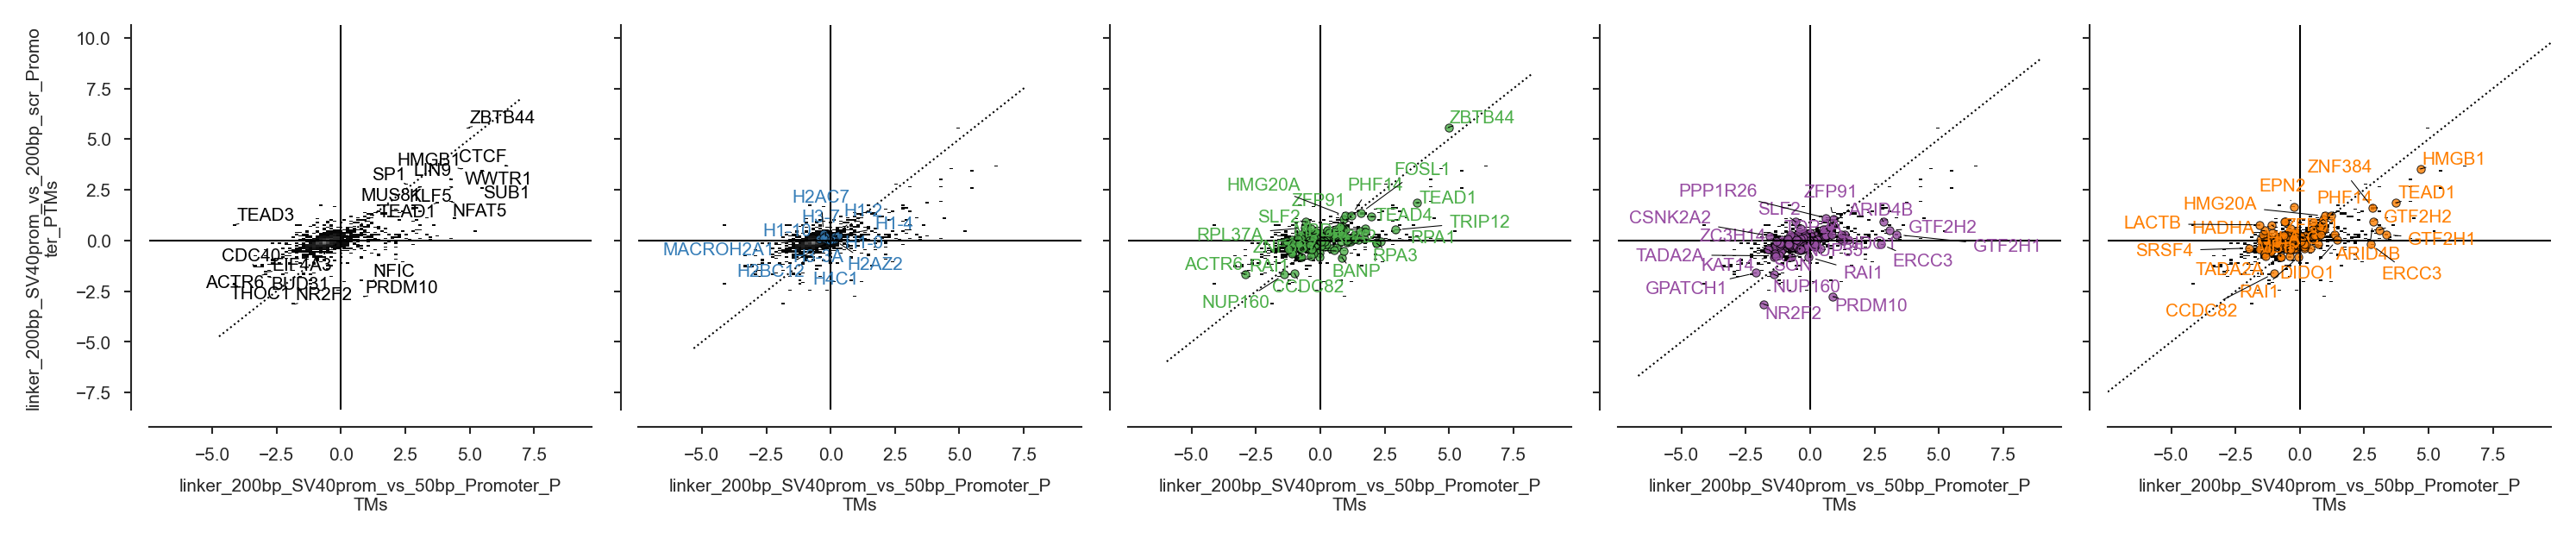

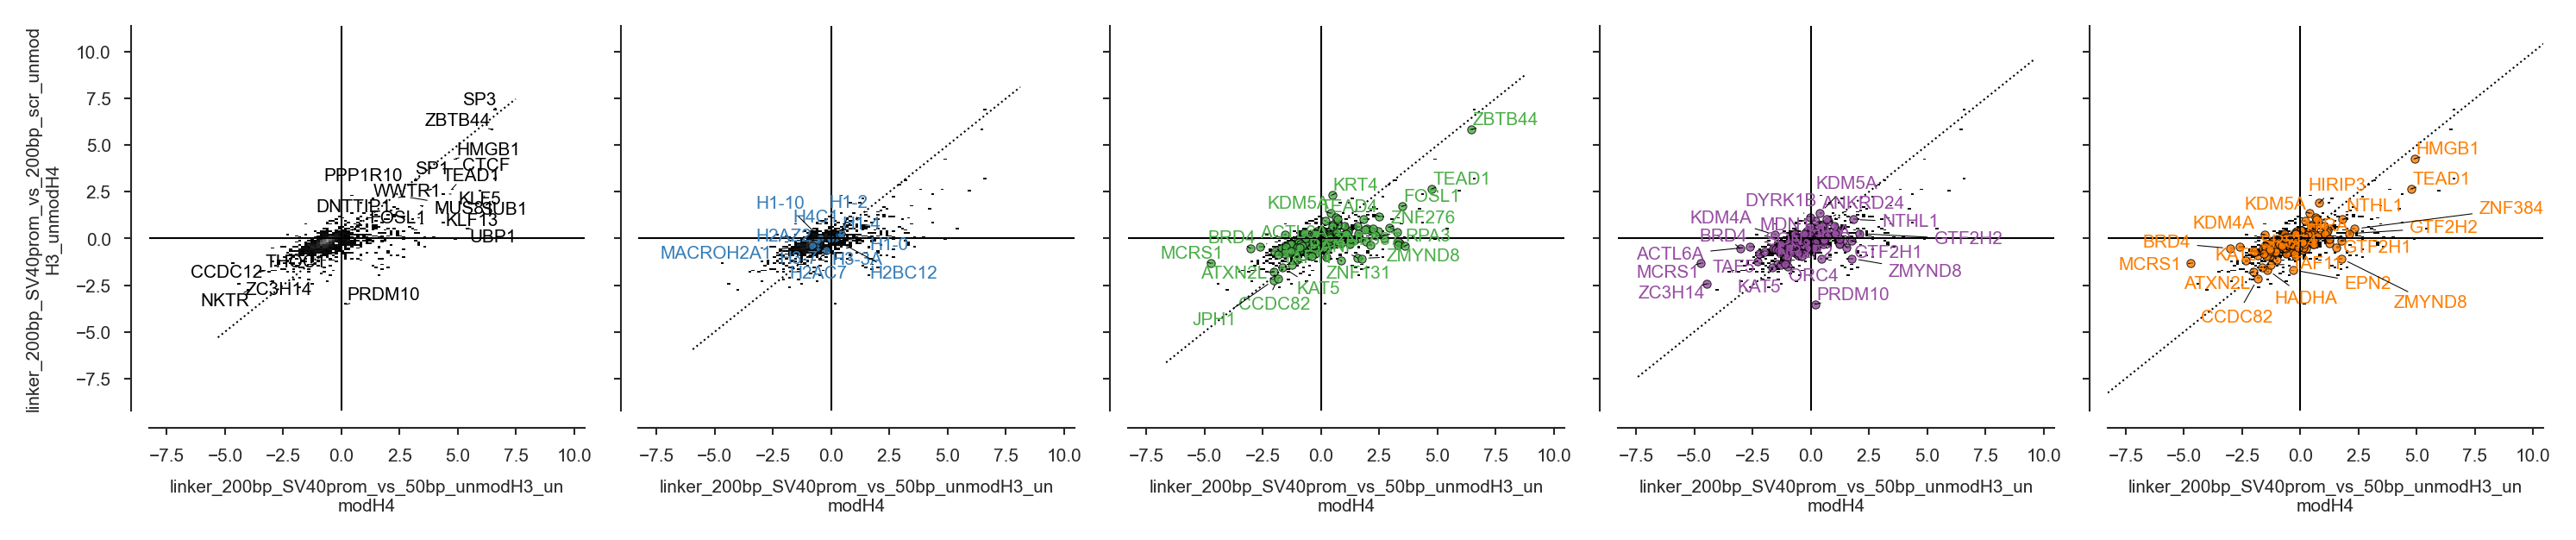

In [127]:
from sklearn.ensemble import IsolationForest
from adjustText import adjust_text
import itertools

if DATASET == 'long-linkers-prom':
    combinations =  [
        ('Promoter_PTMs', '200bp_SV40prom'),
        ('unmodH3_unmodH4', '200bp_SV40prom'),
    ] 
    
elif DATASET == 'long-linkers-enh':
    combinations =  list(itertools.product(['H3K27ac', 'H3K4me1K27ac', 'H3K4me1', 'H3unmod'], ['200bp_SV40enh']))
    # combinations = list(itertools.product(['H3K27ac', 'H3K4me1K27ac', 'H3K4me1'], ['50bp', '200bp_SV40enh']))
else:
    combinations=[]
    # combinations = list(itertools.product(['H3K27me3', 'H3K9me3'], ['35bp', '40bp', '45bp', '55bp']))


for experiment, linker in combinations:

    fig = plt.figure(figsize=(50*FIVE_MM_IN_INCH, 10*FIVE_MM_IN_INCH), constrained_layout=True)

    axes = fig.subplots(nrows=1, ncols=5, sharex=True, sharey=True)

    _x = (f'linker_{linker}_vs_{ref_linker}_{experiment}', 'logFC')
    _y = (f'linker_{linker}_vs_200bp_scr_{experiment}', 'logFC')
    _df = full_results.dropna(subset=[_x, _y])
    _approx_nlabels = 20

    for ax, col, color in zip(axes, [None] + ['normalisation_proteins'] + list(contrasts_matrix_as_df.columns), sns.color_palette('Set1')):

        sns.histplot(
            x=_x, 
            y=_y, 
            data=_df,
            cmap=sns.blend_palette(['#000000','#969696'], as_cmap=True),
            ax=ax,
        )

        if col is None:
            if_ = IsolationForest(random_state=42, contamination=np.clip(_approx_nlabels/len(_df), 1e-5, 0.5))

            outliers = if_.fit_predict(_df[[_x, _y]])
            outliers = pd.Series((outliers == -1), index=_df.index)

            texts = []
            for ix in outliers[outliers].index:
                texts.append(ax.text(_df.loc[ix, _x], _df.loc[ix, _y], ix, color='black'))

            adjust_text(texts, arrowprops=dict(arrowstyle='-'), ax=ax)
        elif col == 'normalisation_proteins':


            ax.scatter(
                _df.loc[HISTONES, _x],
                _df.loc[HISTONES, _y],
                color=color,
                edgecolor='black',
                alpha=0.8,
                s=5,
                label=col,
            )

            texts = []
            for ix in HISTONES:
                texts.append(ax.text(_df.loc[ix, _x], _df.loc[ix, _y], ix, color=color))

            adjust_text(texts, arrowprops=dict(arrowstyle='-'), ax=ax)

        else:
            subdf = _df[_df[col, 'significant'].fillna(False)]

            if_ = IsolationForest(random_state=42, contamination=np.clip(_approx_nlabels/len(subdf), 1e-5, 0.5))
            outliers = if_.fit_predict(subdf[[_x, _y]])
            outliers = pd.Series((outliers == -1), index=subdf.index)

            ax.scatter(
                subdf[_x],
                subdf[_y],
                color=color,
                edgecolor='black',
                alpha=0.8,
                s=5,
                label=col,
            )

#             ax.legend(title="Significant")

            texts = []
            for ix in outliers[outliers].index:
                texts.append(ax.text(_df.loc[ix, _x], _df.loc[ix, _y], ix, color=color))

            adjust_text(texts, arrowprops=dict(arrowstyle='-'), ax=ax)

        ax.grid(False)

        ax.axvline(0, color='black', linestyle='-', linewidth=0.5)
        ax.axhline(0, color='black', linestyle='-', linewidth=0.5)

        xlim = ax.get_xlim()
        ylim = ax.get_ylim()

        min_ = np.min([xlim, ylim])
        max_ = np.max([xlim, ylim])

        ax.plot([min_, max_], [min_, max_], linestyle=':', color='k')
        ax.set_xlim(*xlim, *ylim)
        ax.set_xlabel('\n'.join(textwrap.wrap(_x[0], 40)))
        ax.set_ylabel('\n'.join(textwrap.wrap(_y[0], 40)))

        sns.despine(offset=5, ax=ax)

    _fname = OUTPUT_DIRECTORY / f'09-scatterplot-full-results_modif_linker_{experiment}_{linker}.pdf'
    _caption = f"""
    A scatterplot diagram of model estimates.

    The first plot simply plots the whole data, the second plot highlights proteins used to normalise the data, while the remaining three plots highlight proteins for which
    the corresponding estimates are statistically non zero. (limma, at FDR {FDR_THRESHOLD}, BH correction).
    Labels are displayed for a handful of outlier proteins.
    """
    plt.savefig(_fname, bbox_inches='tight', dpi=DPI)
    with open(str(_fname) + '.caption.md', 'w') as f:
        f.write(_caption)
        print(_caption)